In [15]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import sys
sys.path.append("../src/")
sys.path.append("D:/metabolome_inference/metabolome_inference/src/")
from integrAitor import rawData,integrAitor,Classifier,Smoother,normalizeMatrix,safeNormalize
import detection_helper
import scipy.stats as stats
import seaborn as sb


In [2]:
datadir = "../data/mzMLs/"
resolution = 100
ppm = 10

In [3]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = {}
ms1 = {file:deimos.read_mzml(datadir + file)["ms1"] for file in files}
raw_data = {}
for file in files:
    temp = rawData()
    temp.readRawDataFile(datadir + file,ppm)
    raw_data[file] = temp
    

['M3T-Std_neg_DDA_1mz.mzML', 'M3T-Std_neg_DDA_3mz.mzML', 'M3T-Std_neg_DDA_5mz.mzML']


In [4]:
if __name__ == "__main__":
    # initialize ms1 peak container
    ms1_peaks = {}
    # iterate over ms1 datasets
    for k in ms1.keys():
        # partition data into chunks to limit memory usage
        # more on partitioning/mapping later in this notebook
        partitions = deimos.partition(ms1[k],
                                      split_on='mz',
                                      size=500,
                                      overlap=0.05)

        # map peakpicking algorithm to each partition
        # note that more configuration parameters are available
        ms1_peaks[k] = partitions.map(deimos.peakpick.local_maxima,
                                      dims=['mz', 'retention_time'],bins=[2.7, 3.64],
                                      processes=10)

Text(0, 0.5, '# of features')

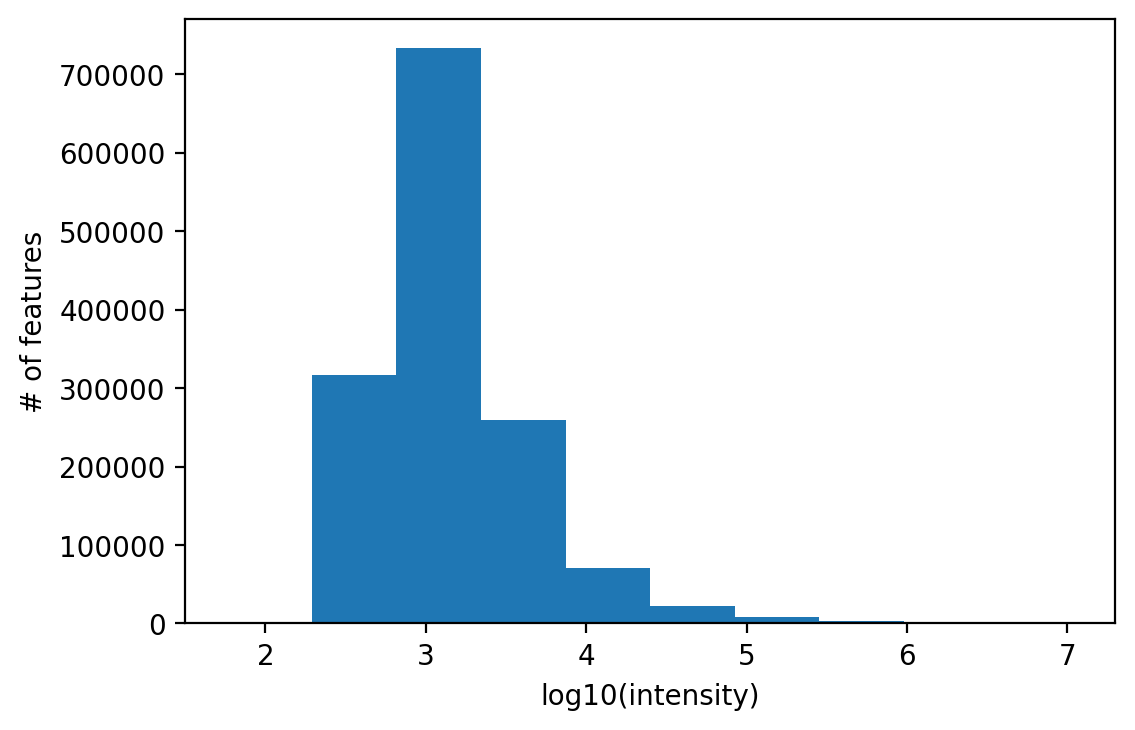

In [5]:
ints = []
for file in ms1_peaks:
    ints += list(np.log10(ms1_peaks[file]["intensity"].values))
plt.hist(ints)
plt.xlabel("log10(intensity)")
plt.ylabel("# of features")

In [6]:
# threshold by intensity
ms1_peaks_thresh = {key:deimos.threshold(value, threshold=10000) for key,value in ms1_peaks.items()}

In [7]:
dets = []
for file in ms1_peaks_thresh:
    dets.append(len(ms1_peaks_thresh[file]))
print(np.mean(dets),np.std(dets))

26265.666666666668 1407.368545272425


In [8]:
#format X
if __name__ == "__main__":
    X = np.zeros((int(np.sum([len(ms1_peaks_thresh[f]) for f in files])),resolution))
    integ = integrAitor(numCores = 10,resolution=resolution)
    keys = []
    i = 0

    for file in files:
        tmp = integ.makeDataMatrix([raw_data[file]],ms1_peaks_thresh[file]["mz"].values,
                                 ms1_peaks_thresh[file]["retention_time"].values-.5,
                                 ms1_peaks_thresh[file]["retention_time"].values+.5)
        X[i:i+len(tmp),:] = tmp        
        i += len(tmp)
        keys += [[file,ind] for ind in ms1_peaks_thresh[file].index.values]

X = X[:i]
print(X.shape)

forming matrix |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
forming matrix |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
forming matrix |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
(78797, 100)


In [9]:
X_train,X_test = train_test_split(X,test_size=.2,shuffle=True)

In [10]:
if __name__ == "__main__":
    X_smoothed,_,_,_ = integ.curatePeaks(X_train)

fitting smoother...
Epoch 1/10
887/887 [==============================] - 21s 22ms/step - loss: 0.1903 - mean_absolute_error: 0.1152 - val_loss: 0.0553 - val_mean_absolute_error: 0.0037
Epoch 2/10
887/887 [==============================] - 19s 21ms/step - loss: 0.0547 - mean_absolute_error: 0.0028 - val_loss: 0.0540 - val_mean_absolute_error: 0.0019
Epoch 3/10
887/887 [==============================] - 19s 22ms/step - loss: 0.0540 - mean_absolute_error: 0.0017 - val_loss: 0.0538 - val_mean_absolute_error: 0.0016
Epoch 4/10
887/887 [==============================] - 19s 22ms/step - loss: 0.0538 - mean_absolute_error: 0.0015 - val_loss: 0.0538 - val_mean_absolute_error: 0.0014
Epoch 5/10
887/887 [==============================] - 19s 21ms/step - loss: 0.0538 - mean_absolute_error: 0.0014 - val_loss: 0.0537 - val_mean_absolute_error: 0.0014
Epoch 6/10
887/887 [==============================] - 19s 21ms/step - loss: 0.0537 - mean_absolute_error: 0.0013 - val_loss: 0.0537 - val_mean_absolut

Epoch 7/10
2655/2655 [==============================] - 15s 6ms/step - loss: 0.0022 - mean_absolute_error: 5.2686e-04 - val_loss: 2.2318e-04 - val_mean_absolute_error: 1.5976e-05
Epoch 8/10
2655/2655 [==============================] - 14s 5ms/step - loss: 0.0016 - mean_absolute_error: 3.9515e-04 - val_loss: 2.1377e-04 - val_mean_absolute_error: 1.7632e-05
Epoch 9/10
2655/2655 [==============================] - 13s 5ms/step - loss: 0.0015 - mean_absolute_error: 3.9327e-04 - val_loss: 4.7253e-05 - val_mean_absolute_error: 1.2398e-06
Epoch 10/10
2655/2655 [==============================] - 12s 5ms/step - loss: 0.0017 - mean_absolute_error: 3.8124e-04 - val_loss: 9.4060e-05 - val_mean_absolute_error: 5.5308e-06
round 5: 331 unclassified features
Epoch 1/10
2655/2655 [==============================] - 12s 4ms/step - loss: 0.5116 - mean_absolute_error: 0.3264 - val_loss: 0.0251 - val_mean_absolute_error: 0.0033
Epoch 2/10
2655/2655 [==============================] - 11s 4ms/step - loss: 0.01

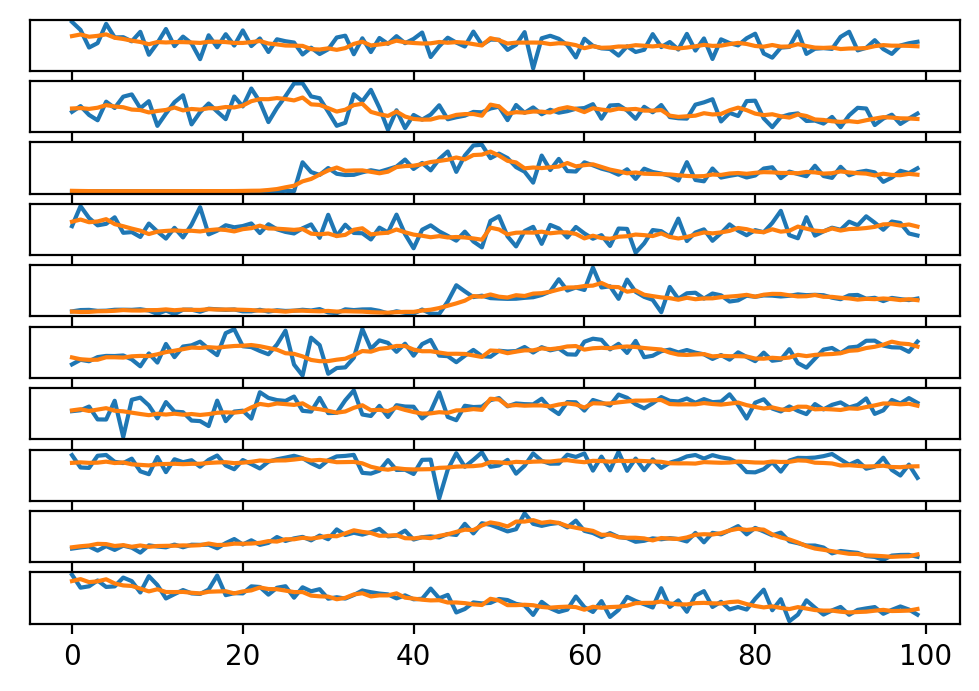

In [16]:
randomInts = rd.sample(list(range(len(X_train))),k=10)
fig, axes = plt.subplots(10,1)
for x,ax in zip(randomInts,axes):
    ax.plot(safeNormalize(X_train[x]),label="original")
    ax.plot(X_smoothed[x],label="output")
    ax.set_yticks([],[])
    #ax.legend()

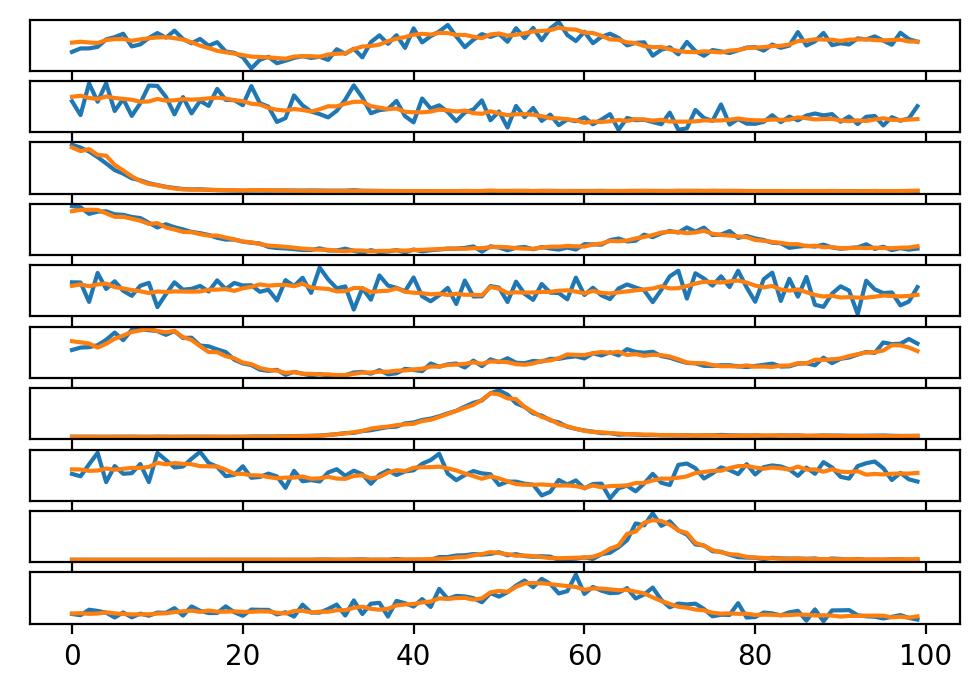

In [17]:
randomInts = rd.sample(list(range(len(X_test))),k=10)
fig, axes = plt.subplots(10,1)
X_test_smoothed = integ.smoother.predict(normalizeMatrix(X_test))
for x,ax in zip(randomInts,axes):
    ax.plot(safeNormalize(X_test[x]),label="original")
    ax.plot(X_test_smoothed[x],label="output")
    ax.set_yticks([],[])
    #ax.legend()

In [18]:
if __name__ == "__main__":
    X_smoothed,tics,y,progress = integ.curatePeaks(X)

fitting smoother...
Epoch 1/10
1109/1109 [==============================] - 24s 21ms/step - loss: 0.1798 - mean_absolute_error: 0.1063 - val_loss: 0.0536 - val_mean_absolute_error: 0.0039
Epoch 2/10
1109/1109 [==============================] - 23s 21ms/step - loss: 0.0547 - mean_absolute_error: 0.0025 - val_loss: 0.0524 - val_mean_absolute_error: 0.0023
Epoch 3/10
1109/1109 [==============================] - 23s 21ms/step - loss: 0.0540 - mean_absolute_error: 0.0016 - val_loss: 0.0522 - val_mean_absolute_error: 0.0020
Epoch 4/10
1109/1109 [==============================] - 23s 21ms/step - loss: 0.0540 - mean_absolute_error: 0.0014 - val_loss: 0.0521 - val_mean_absolute_error: 0.0019
Epoch 5/10
1109/1109 [==============================] - 22s 20ms/step - loss: 0.0539 - mean_absolute_error: 0.0013 - val_loss: 0.0521 - val_mean_absolute_error: 0.0018
Epoch 6/10
1109/1109 [==============================] - 22s 20ms/step - loss: 0.0539 - mean_absolute_error: 0.0012 - val_loss: 0.0520 - val_

3321/3321 [==============================] - 19s 6ms/step - loss: 0.0026 - mean_absolute_error: 8.4618e-04 - val_loss: 2.7421e-04 - val_mean_absolute_error: 3.1398e-05
Epoch 8/10
3321/3321 [==============================] - 19s 6ms/step - loss: 0.0019 - mean_absolute_error: 7.1997e-04 - val_loss: 1.4634e-04 - val_mean_absolute_error: 1.1661e-05
Epoch 9/10
3321/3321 [==============================] - 19s 6ms/step - loss: 0.0019 - mean_absolute_error: 6.9158e-04 - val_loss: 2.7382e-04 - val_mean_absolute_error: 4.7784e-05
Epoch 10/10
3321/3321 [==============================] - 19s 6ms/step - loss: 0.0018 - mean_absolute_error: 6.3454e-04 - val_loss: 1.8242e-04 - val_mean_absolute_error: 2.6676e-05
round 5: 195 unclassified features
Epoch 1/10
3322/3322 [==============================] - 20s 6ms/step - loss: 0.3985 - mean_absolute_error: 0.2535 - val_loss: 0.0061 - val_mean_absolute_error: 2.4925e-04
Epoch 2/10
3322/3322 [==============================] - 19s 6ms/step - loss: 0.0071 - me

[78797, 916, 360, 252, 195]


Text(0, 0.5, 'log10(# of uncertain peaks)')

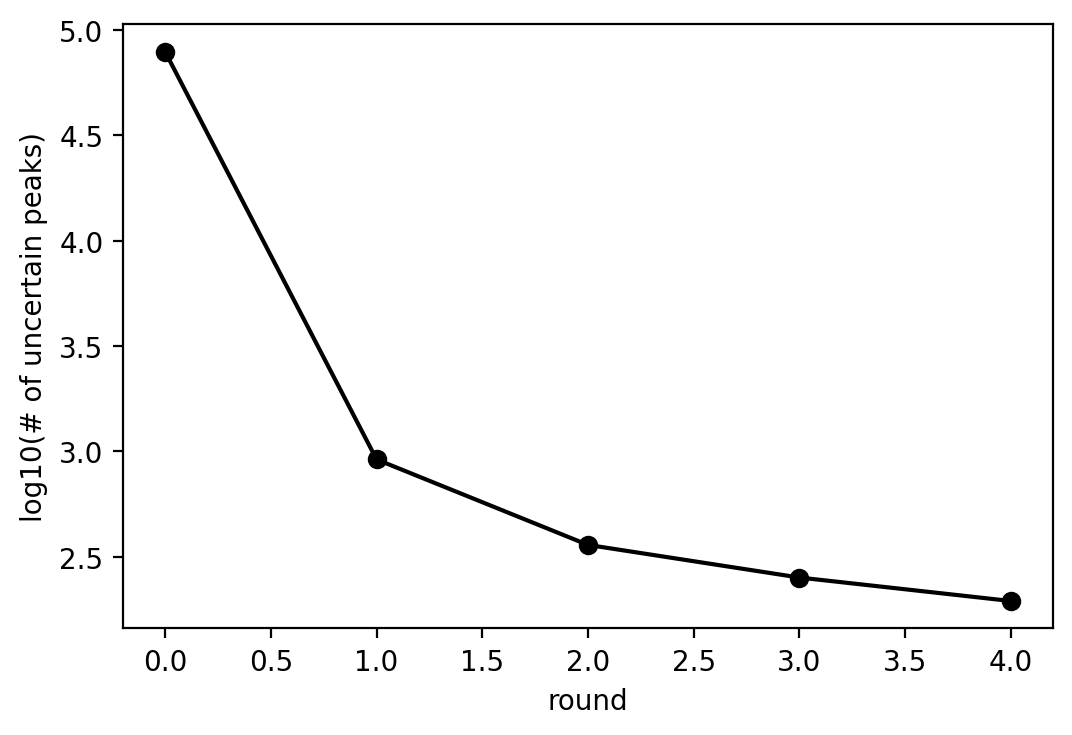

In [19]:
print(progress)
plt.plot(list(range(len(progress))),np.log10(progress),color="black")
plt.scatter(list(range(len(progress))),np.log10(progress),color="black")
plt.xlabel("round")
plt.ylabel("log10(# of uncertain peaks)")

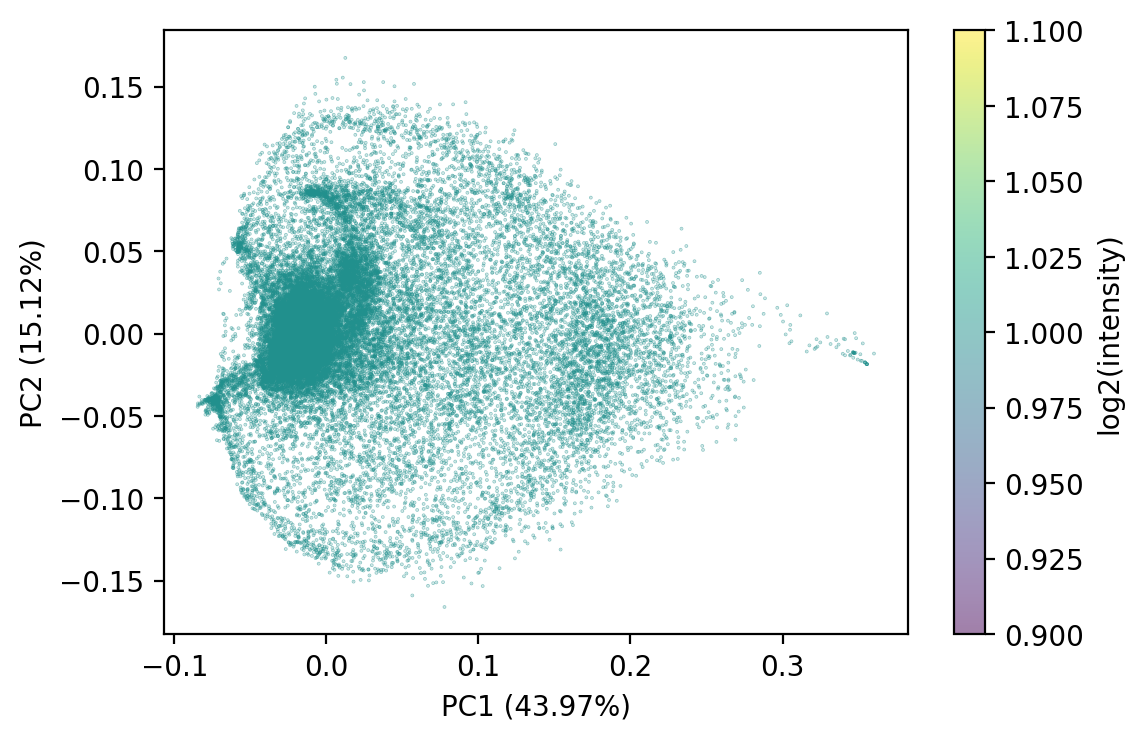

In [20]:
pca = PCA(2)
loads = pca.fit_transform(X_smoothed)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log2(intensity)")

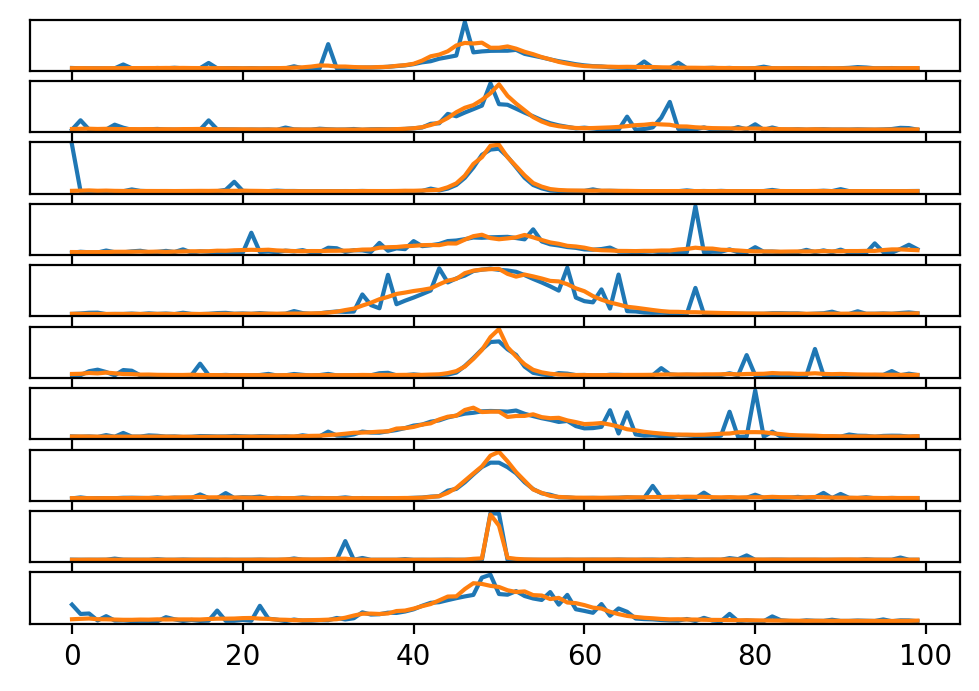

In [21]:
randomInts = rd.sample(list(range(len(X))),k=10)
X_signal,_ = integ.generateSignalPeaks(X,tics)
X_signal = normalizeMatrix(X_signal)
X_signal_smoothed = integ.smoother.predict(X_signal)
fig, axes = plt.subplots(10,1)
for x,ax in zip(randomInts,axes):
    ax.plot(X_signal[x],label="original")
    ax.plot(X_signal_smoothed[x],label="output")
    ax.set_yticks([],[])


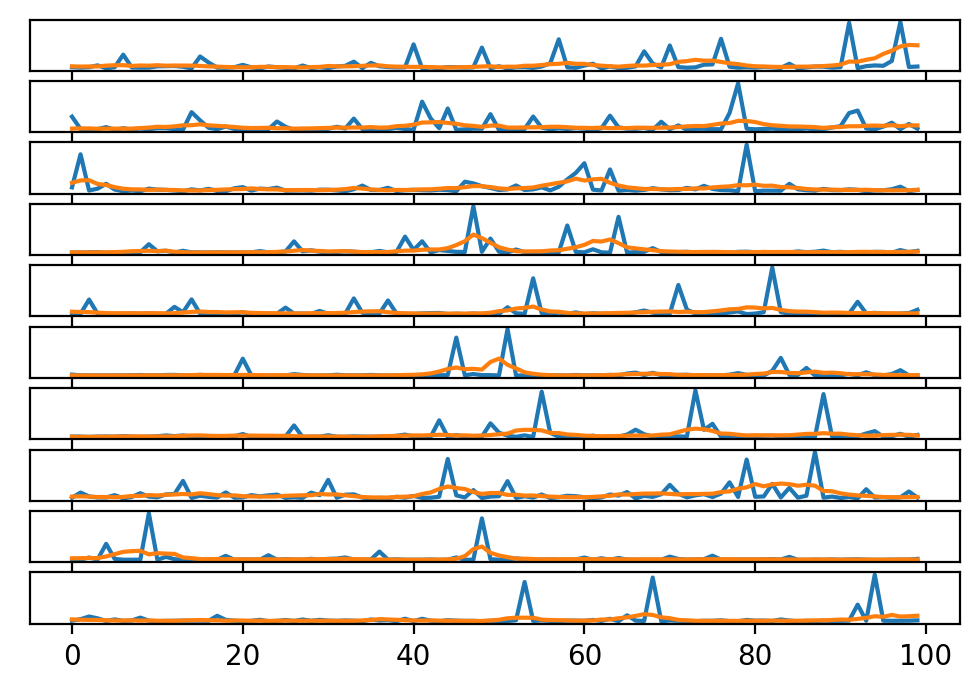

In [22]:
randomInts = rd.sample(list(range(len(X))),k=10)
X_noise,_ = integ.generateNoisePeaks(X,tics)
X_noise = normalizeMatrix(X_noise)
X_noise_smoothed = integ.smoother.predict(X_noise)
fig, axes = plt.subplots(10,1)
for x,ax in zip(randomInts,axes):
    ax.plot(X_noise[x],label="original")
    ax.plot(X_noise_smoothed[x],label="output")
    ax.set_yticks([],[])


[0.20077557 0.06177706]


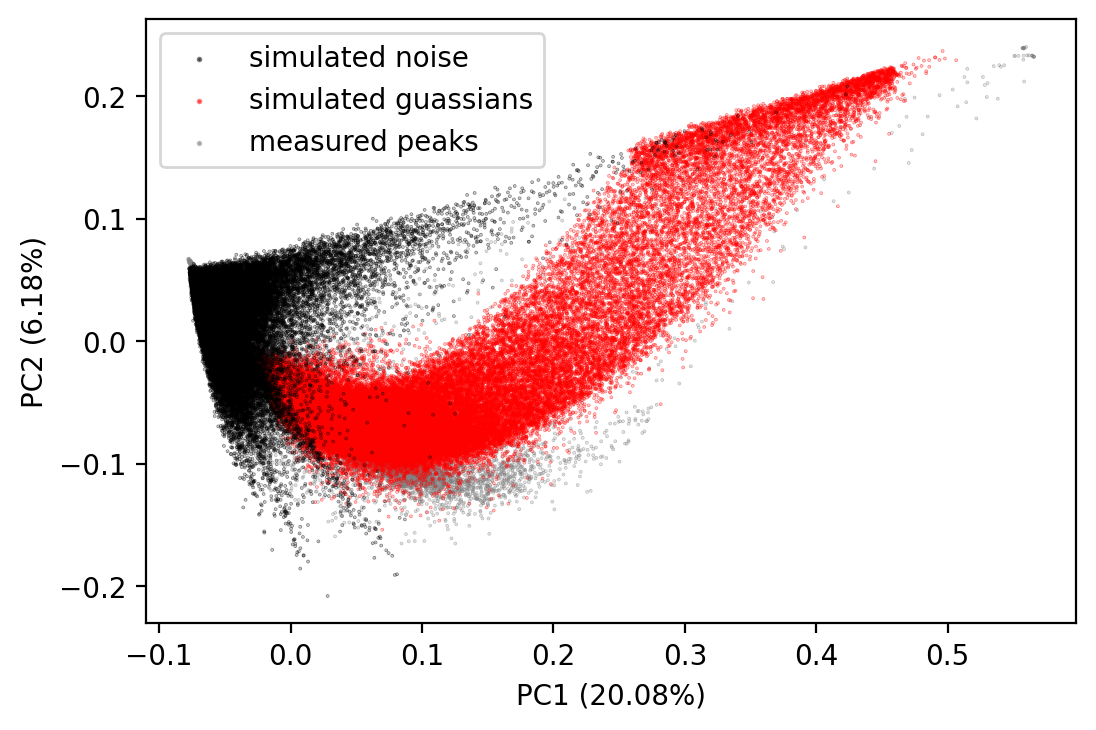

In [23]:
tmp = np.concatenate((X_smoothed,X_signal,X_noise))
cs = ["grey" for _ in X] + ["red" for _ in X_signal] + ["black" for _ in X_noise]
loads = pca.fit_transform(tmp)
print(pca.explained_variance_ratio_[:2])
def getColor(s):
    if s < 0.01:
        return "black"
    if s > 0.99:
        return "red"
    else:
        return "grey"
plt.scatter([0],[0],color="black",label="simulated noise",s=1,alpha=.5)
plt.scatter([0],[0],color="red",label="simulated guassians",s=1,alpha=.5)
plt.scatter([0],[0],color="grey",label="measured peaks",s=1,alpha=.5)

plt.scatter(loads[:,0],loads[:,1],s=.1,alpha=.5,c=cs)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.legend()

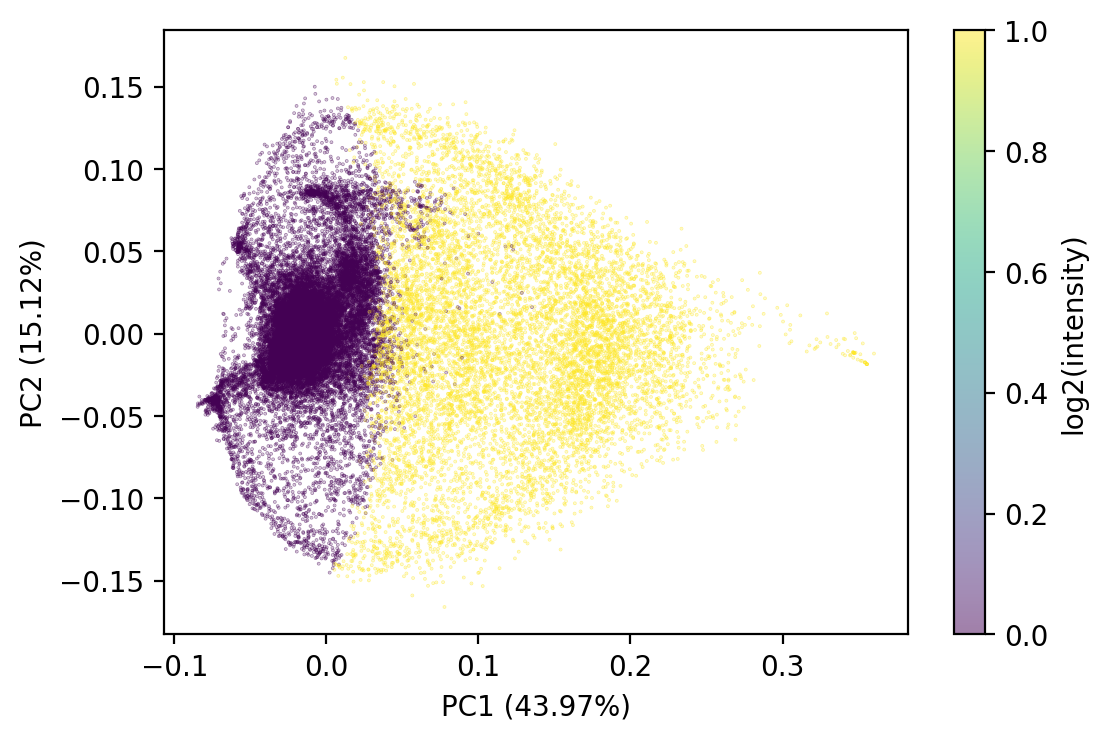

In [24]:
pca = PCA(2)
loads = pca.fit_transform(X_smoothed)
plt.scatter(loads[:,0],loads[:,1],c=y,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log2(intensity)")

In [25]:
ms1_peaks_curated = {file:[] for file in files}
for [file,index],score in zip(keys,y):
    if score > .5:
        ms1_peaks_curated[file].append(index)
for file in ms1_peaks_curated:
    ms1_peaks_curated[file] = ms1_peaks_thresh[file].loc[ms1_peaks_curated[file],:]

Text(0, 0.5, '% of features')

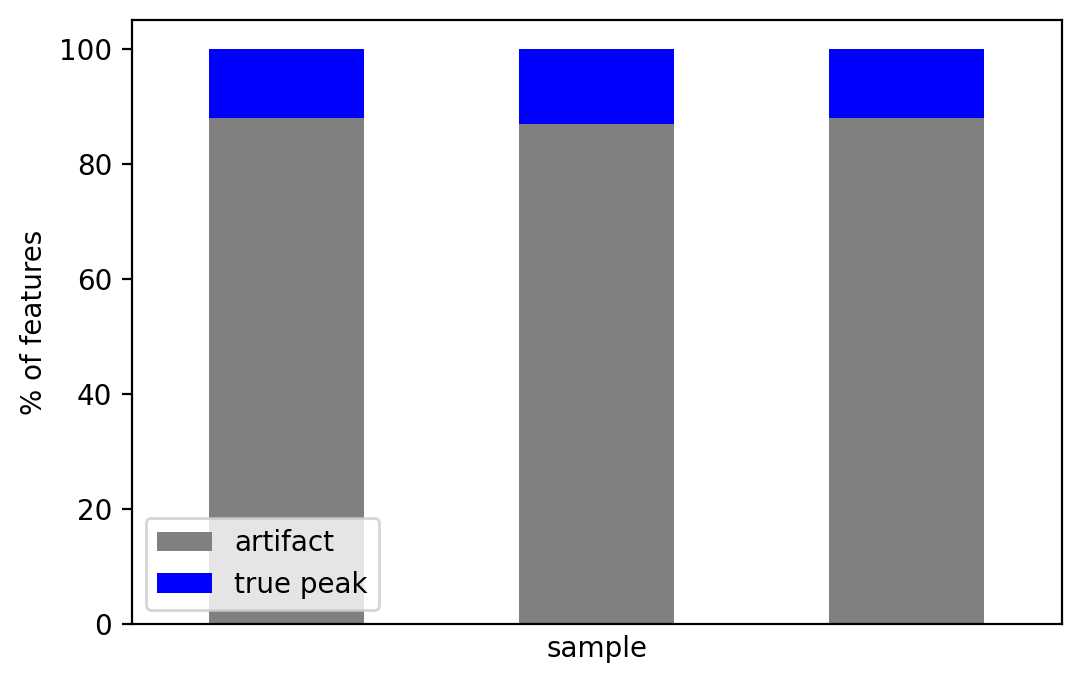

In [26]:
df = {}
for file in ms1_peaks_thresh:
    for index,row in ms1_peaks_thresh[file].iterrows():
        if index in ms1_peaks_curated[file].index.values:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

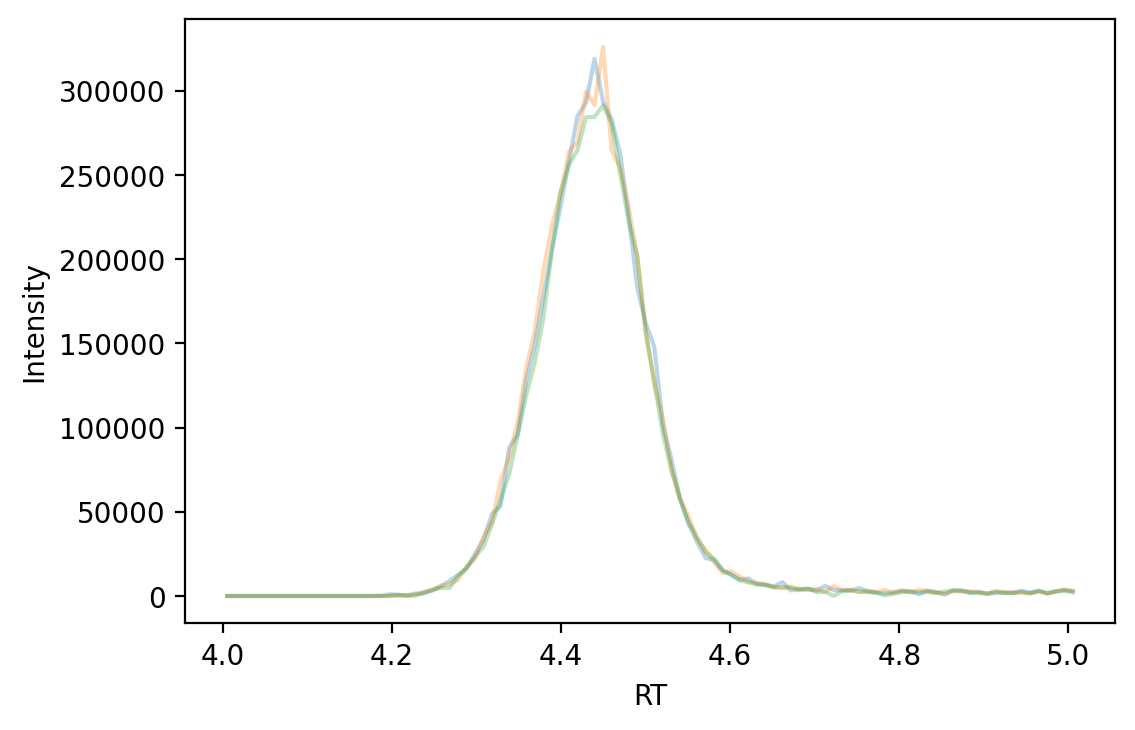

In [27]:
file = files[0]
inds = list(ms1_peaks_thresh[file].index.values)
rd.shuffle(inds)
for i in inds:
    if i in ms1_peaks_curated[file].index.values:
        integ.plot_overlayedEIC([raw_data[f] for f in files],ms1_peaks_curated[file].at[i,"mz"],ms1_peaks_curated[file].at[i,"retention_time"]-.5,ms1_peaks_curated[file].at[i,"retention_time"] + .5)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

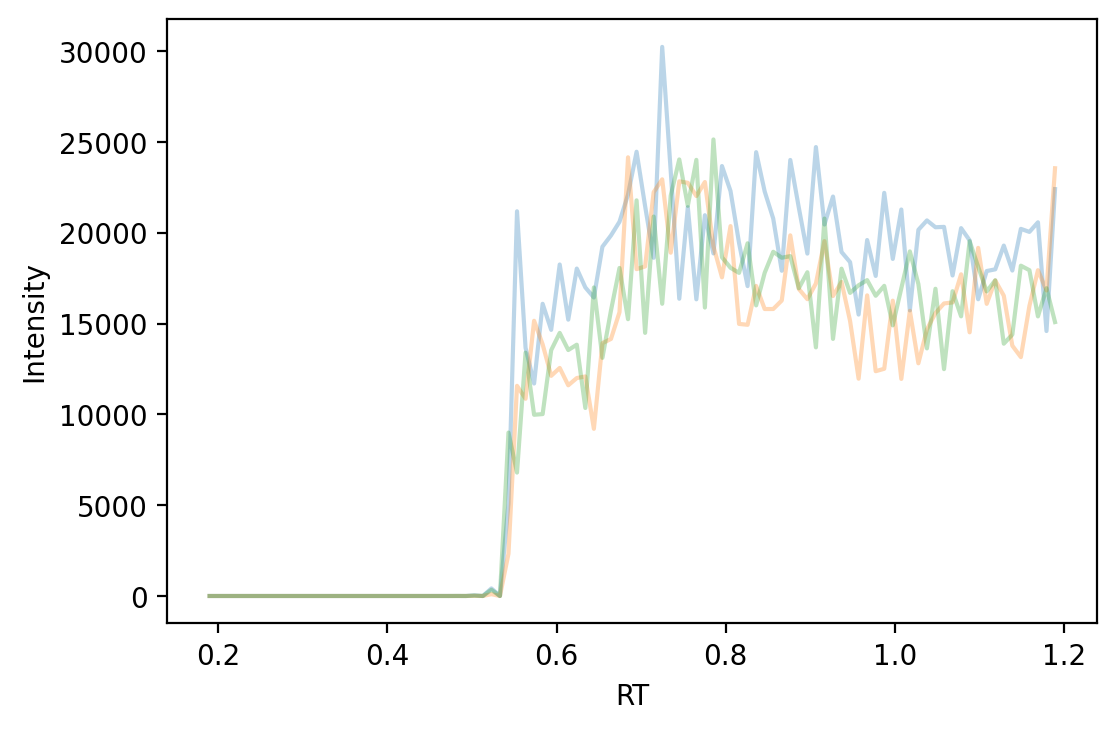

In [28]:
file = files[0]
inds = list(ms1_peaks_thresh[file].index.values)
rd.shuffle(inds)
for i in inds:
    if i not in ms1_peaks_curated[file].index.values:
        integ.plot_overlayedEIC([raw_data[f] for f in files],ms1_peaks_thresh[file].at[i,"mz"],ms1_peaks_thresh[file].at[i,"retention_time"]-.5,ms1_peaks_thresh[file].at[i,"retention_time"] + .5)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [29]:
real_peaks = pd.read_csv("../data/peaks_neg_m3t.csv")
real_peaks

Unnamed: 0                                     Name  rt_start  rt_end  \
0            0                Fructose 1,6-bisphosphate      8.97    9.57   
1            1                              Citric acid      8.88    9.22   
2            2                          Acetoacetyl-CoA      6.39    6.87   
3            3                               Acetyl-CoA      6.31    6.75   
4            4                          Chelidamic Acid      6.85    7.46   
..         ...                                      ...       ...     ...   
66          70                                   URACIL      1.90    2.46   
67          71                                  URIDINE      2.94    3.59   
68          72  URIDINE DIPHOSPHATE-N-ACETYLGLUCOSAMINE      7.20    7.56   
69          73                                   VALINE      4.78    5.30   
70          74                             OXOGLUTARATE      7.25    7.59   

           CAS                     InChiKey  pubchemID mzCloudID  \
0     488-69-7  RNBGYGVWRKECFJ-ZXXMMSQZSA-N     445557        -1   
1      77-92-9  KRKNYBCHXYNGOX-UHFFFAOYSA-N        311      r352   
2    1420-36-6  OJFDKHTZOUZBOS-CITAKDKDSA-N      92153        -1   
3      72-89-9  ZSLZBFCDCINBPY-ZSJPKINUSA-N     444493     r4596   
4     499-51-4  XTLJJHGQACAZMS-UHFFFAOYSA-N       8743        -1   
..         ...                          ...        ...       ...   
66     66-22-8  ISAKRJDGNUQOIC-UHFFFAOYSA-N       1174     r2531   
67     58-96-8  DRTQHJPVMGBUCF-XVFCMESISA-N       6029     r1408   
68    528-04-1  LFTYTUAZOPRMMI-CFRASDGPSA-N     445675     r2920   
69     72-18-4  KZSNJWFQEVHDMF-BYPYZUCNSA-N       6287      r772   
70  22202-68-2  KPGXRSRHYNQIFN-UHFFFAOYSA-N         51      r305   

           formula          mz  
0       C6H14O12P2  338.988774  
1           C6H8O7  191.019727  
2   C25H40N7O18P3S  850.129063  
3   C23H38N7O17P3S  808.118499  
4          C7H5NO5  182.009496  
..             ...         ...  
66        C4H4N2O2  111.020001  
67       C9H12N2O6  243.062260  
68   C17H27N3O17P2  606.074295  
69        C5H11NO2  116.071703  
70          C5H6O5  145.014247  

[71 rows x 10 columns]

In [30]:
real_peaks = [[row["mz"],row["rt_start"]/2+row["rt_end"]/2,row["Name"]] for index,row in real_peaks.iterrows()]

In [31]:
plt_dict = {}
ppmTol = 5
rtTol = .5
for file in files: 
    
        
    numDetected = 0
    detectedPeaks = []
    undetectedPeaks = []

    for mz,rt,name in real_peaks:
        delta = ppmTol * mz / 1e6
        maxMz = mz + delta
        minMz = mz - delta
        found = False
        for index,row in ms1_peaks_thresh[file].iterrows():
            if row["mz"] > minMz and row["mz"] < maxMz:
                if abs(rt-row["retention_time"]) < rtTol:
                    numDetected += 1
                    found = True
                    detectedPeaks.append([mz,rt,name])
                    break
        if not found:
            undetectedPeaks.append([mz,rt,name])
    
    numFound = 0
    
    for mz,rt,name in detectedPeaks:
        delta = ppmTol * mz / 1e6
        maxMz = mz + delta
        minMz = mz - delta
        found = False
        
        for index,row in ms1_peaks_curated[file].iterrows():
            if row["mz"] > minMz and row["mz"] < maxMz:
                if abs(rt-row["retention_time"]) < rtTol:
                    found = True
                    break
        if found:
             plt_dict[len(plt_dict)] = {"metabolite":name,"classification":"true peak","sample" : file}
        else:
             plt_dict[len(plt_dict)] = {"metabolite":name,"classification":"artifact","sample" : file}
    for mz,rt,name in undetectedPeaks:
        plt_dict[len(plt_dict)] = {"metabolite":name,"classification":"undetected","sample" : file}
    
   
df = pd.DataFrame.from_dict(plt_dict,orient="index")

In [32]:
df

metabolite classification                    sample
0    Fructose 1,6-bisphosphate      true peak  M3T-Std_neg_DDA_1mz.mzML
1                  Citric acid       artifact  M3T-Std_neg_DDA_1mz.mzML
2              Acetoacetyl-CoA      true peak  M3T-Std_neg_DDA_1mz.mzML
3                   Acetyl-CoA      true peak  M3T-Std_neg_DDA_1mz.mzML
4              Chelidamic Acid      true peak  M3T-Std_neg_DDA_1mz.mzML
..                         ...            ...                       ...
208                     VALINE      true peak  M3T-Std_neg_DDA_5mz.mzML
209               OXOGLUTARATE      true peak  M3T-Std_neg_DDA_5mz.mzML
210                   ARGININE     undetected  M3T-Std_neg_DDA_5mz.mzML
211                     LYSINE     undetected  M3T-Std_neg_DDA_5mz.mzML
212       S-ADENOSYLMETHIONINE     undetected  M3T-Std_neg_DDA_5mz.mzML

[213 rows x 3 columns]

In [33]:
misClass = df[df["classification"] == "artifact"]
misClass

metabolite classification                    sample
1      Citric acid       artifact  M3T-Std_neg_DDA_1mz.mzML
5    cis-Aconitate       artifact  M3T-Std_neg_DDA_1mz.mzML
8          Glucose       artifact  M3T-Std_neg_DDA_1mz.mzML
16       L-ALANINE       artifact  M3T-Std_neg_DDA_1mz.mzML
20    BETA-ALANINE       artifact  M3T-Std_neg_DDA_1mz.mzML
34       HISTIDINE       artifact  M3T-Std_neg_DDA_1mz.mzML
37      ISOCITRATE       artifact  M3T-Std_neg_DDA_1mz.mzML
47         PROLINE       artifact  M3T-Std_neg_DDA_1mz.mzML
58          VALINE       artifact  M3T-Std_neg_DDA_1mz.mzML
72     Citric acid       artifact  M3T-Std_neg_DDA_3mz.mzML
76   cis-Aconitate       artifact  M3T-Std_neg_DDA_3mz.mzML
79         Glucose       artifact  M3T-Std_neg_DDA_3mz.mzML
85         ADENINE       artifact  M3T-Std_neg_DDA_3mz.mzML
87       L-ALANINE       artifact  M3T-Std_neg_DDA_3mz.mzML
91    BETA-ALANINE       artifact  M3T-Std_neg_DDA_3mz.mzML
107      HISTIDINE       artifact  M3T-Std_neg_DDA_3mz.mzML
109     ISOCITRATE       artifact  M3T-Std_neg_DDA_3mz.mzML
143    Citric acid       artifact  M3T-Std_neg_DDA_5mz.mzML
150        Glucose       artifact  M3T-Std_neg_DDA_5mz.mzML
160      L-ALANINE       artifact  M3T-Std_neg_DDA_5mz.mzML
164   BETA-ALANINE       artifact  M3T-Std_neg_DDA_5mz.mzML
180      HISTIDINE       artifact  M3T-Std_neg_DDA_5mz.mzML
183     ISOCITRATE       artifact  M3T-Std_neg_DDA_5mz.mzML

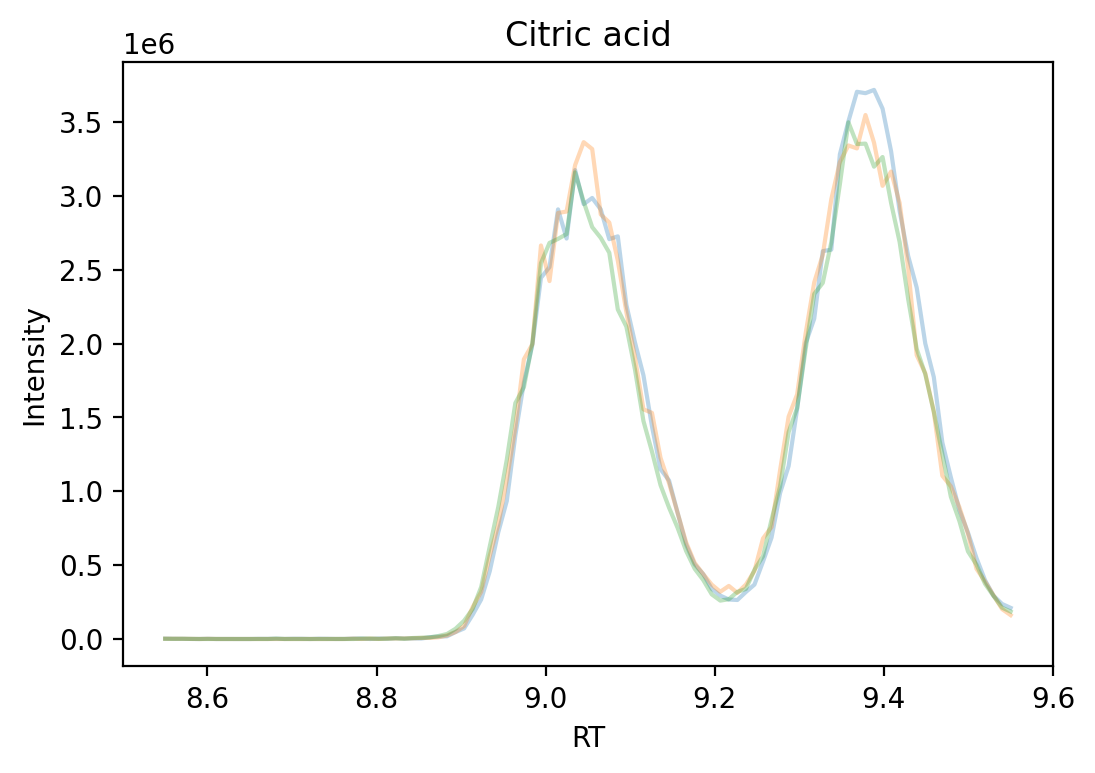

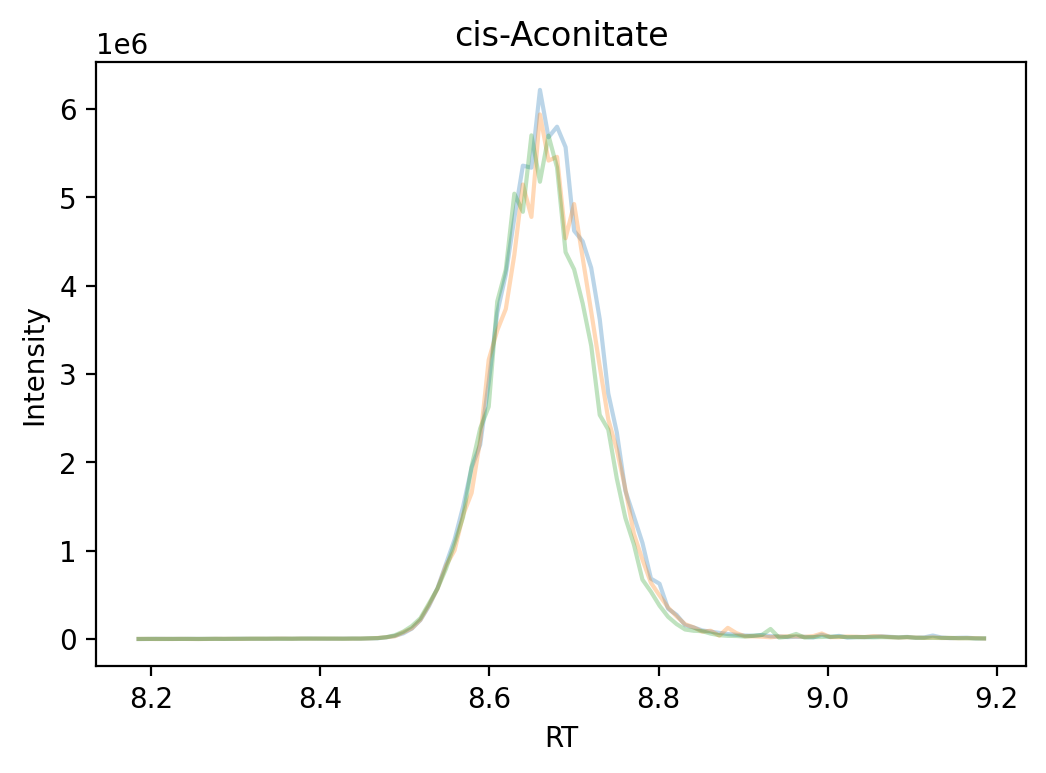

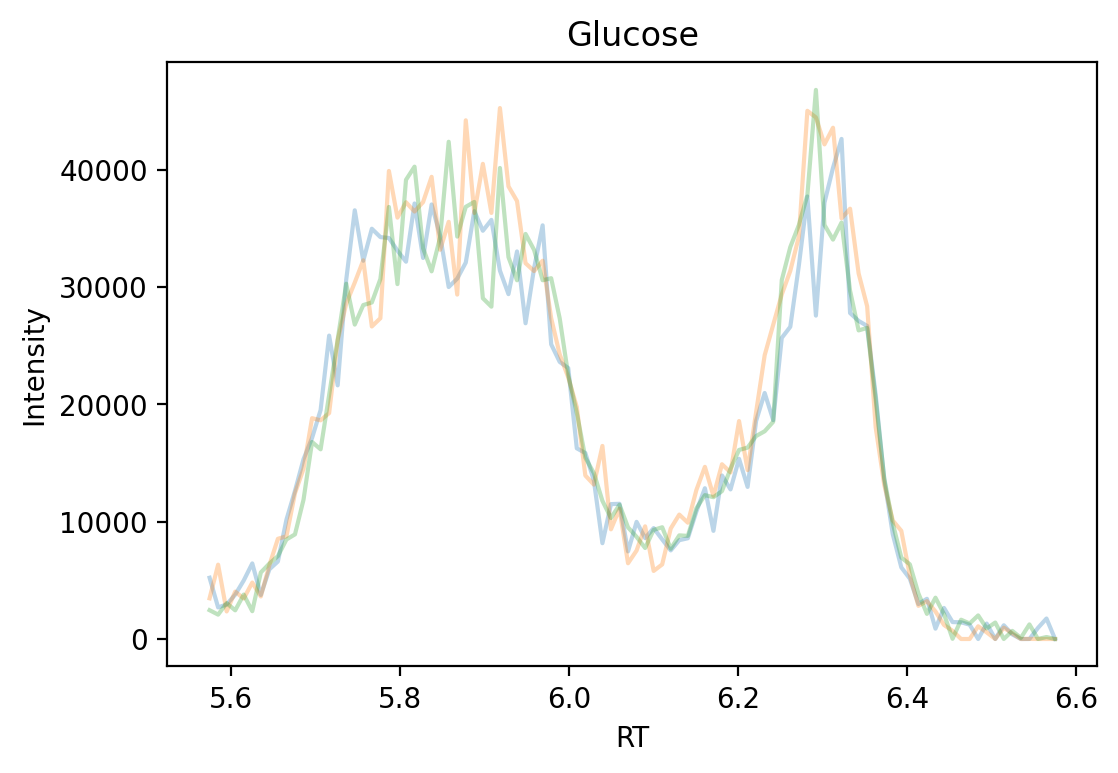

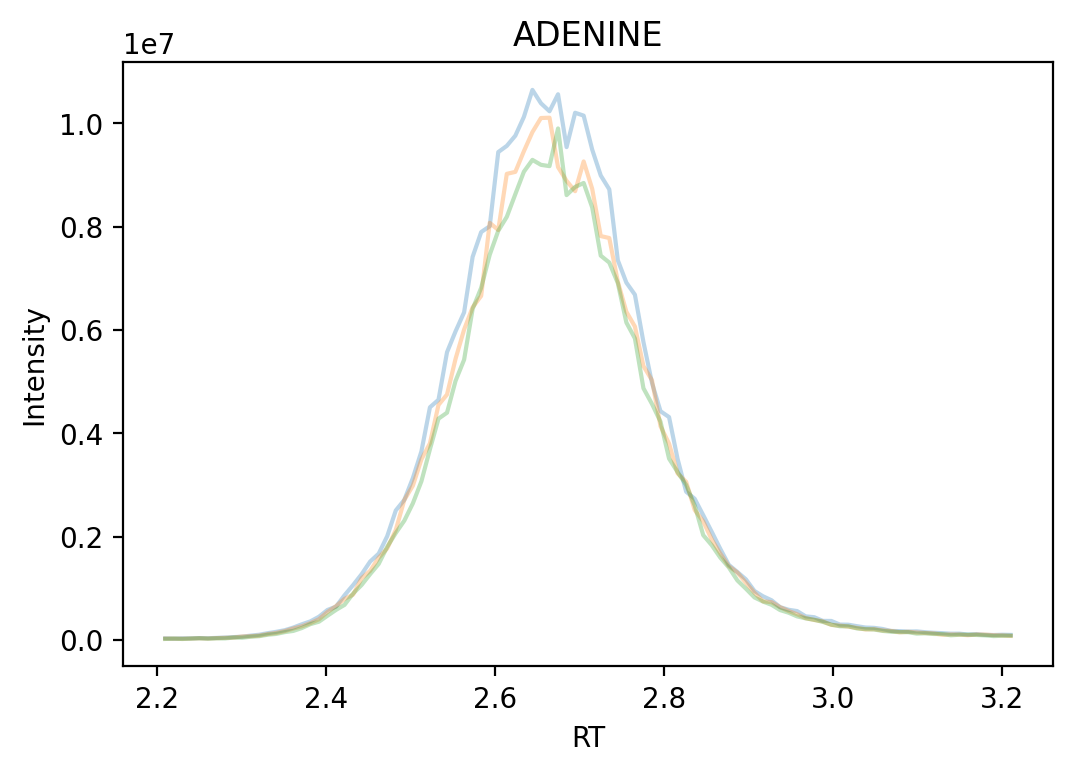

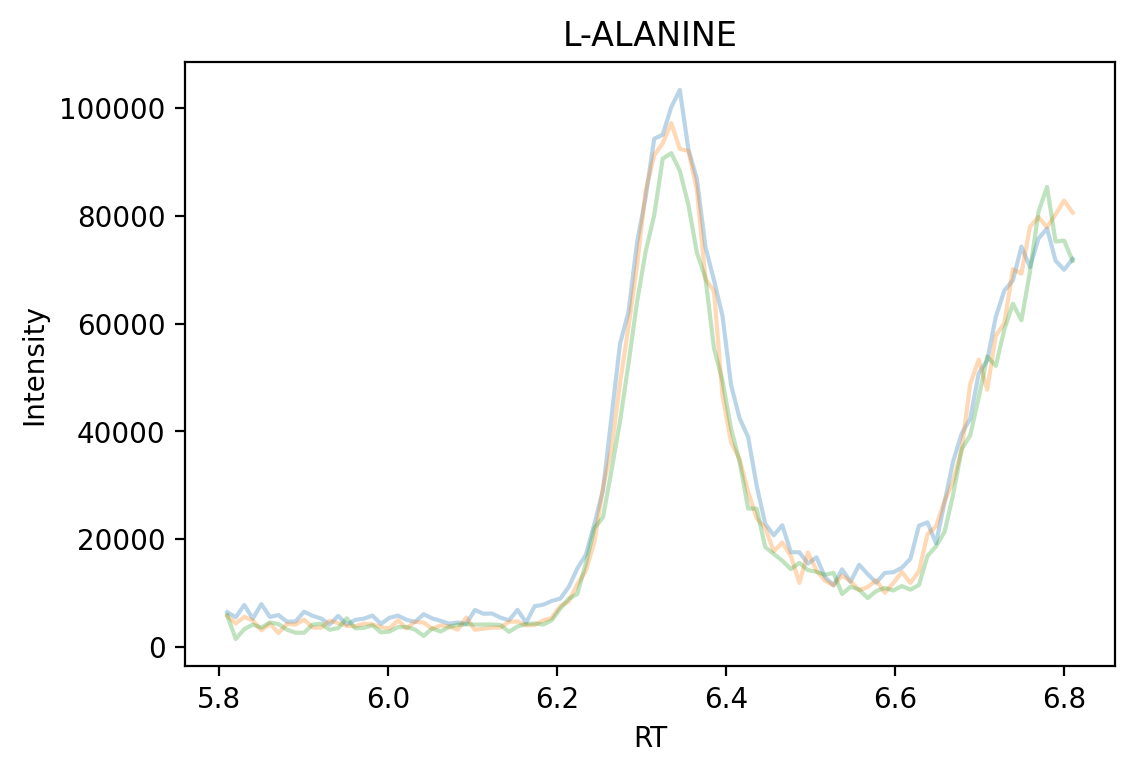

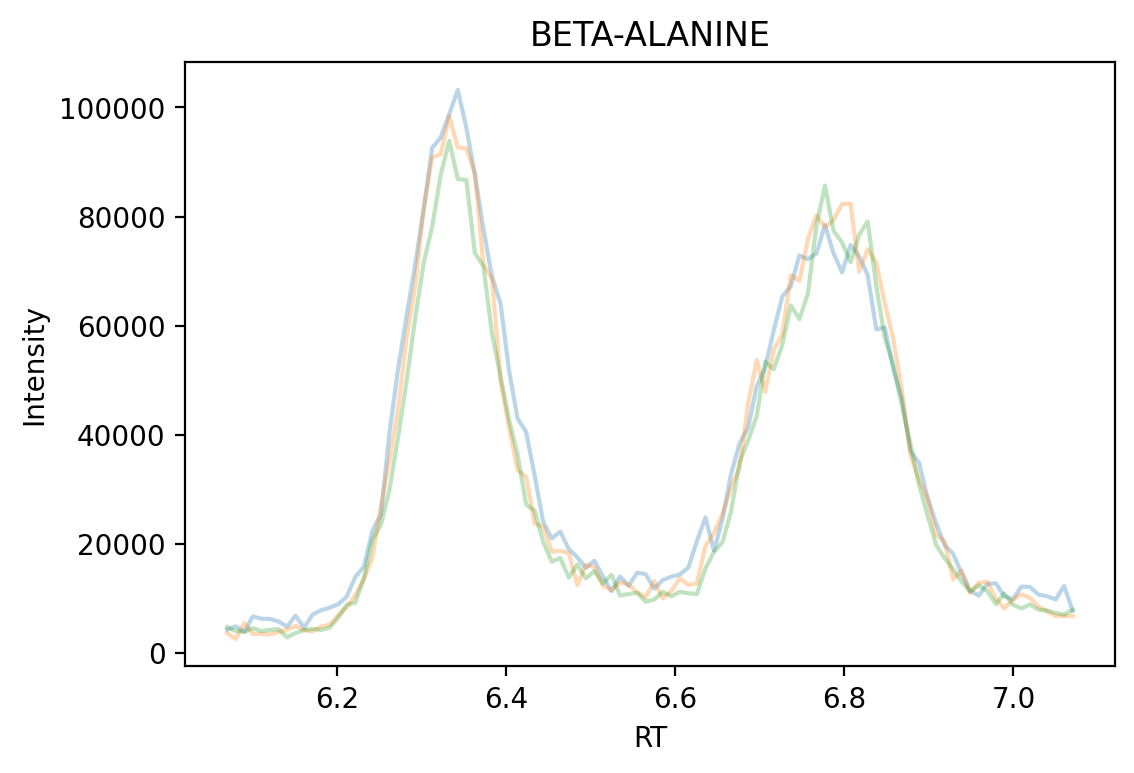

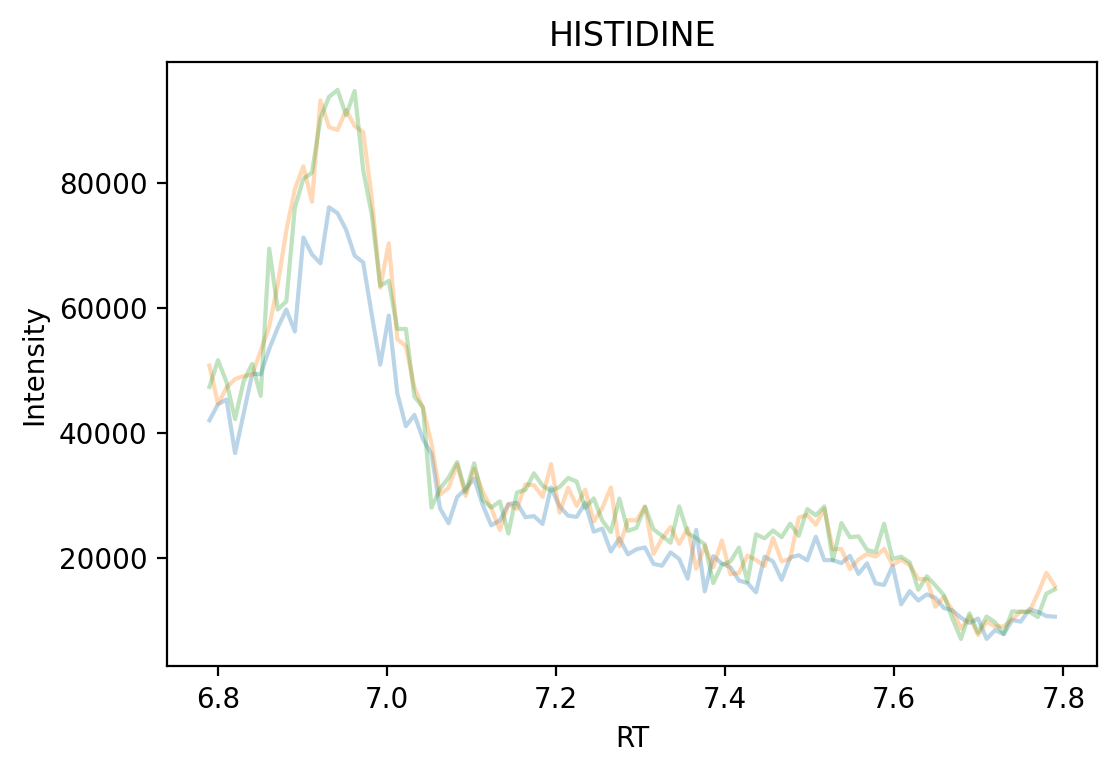

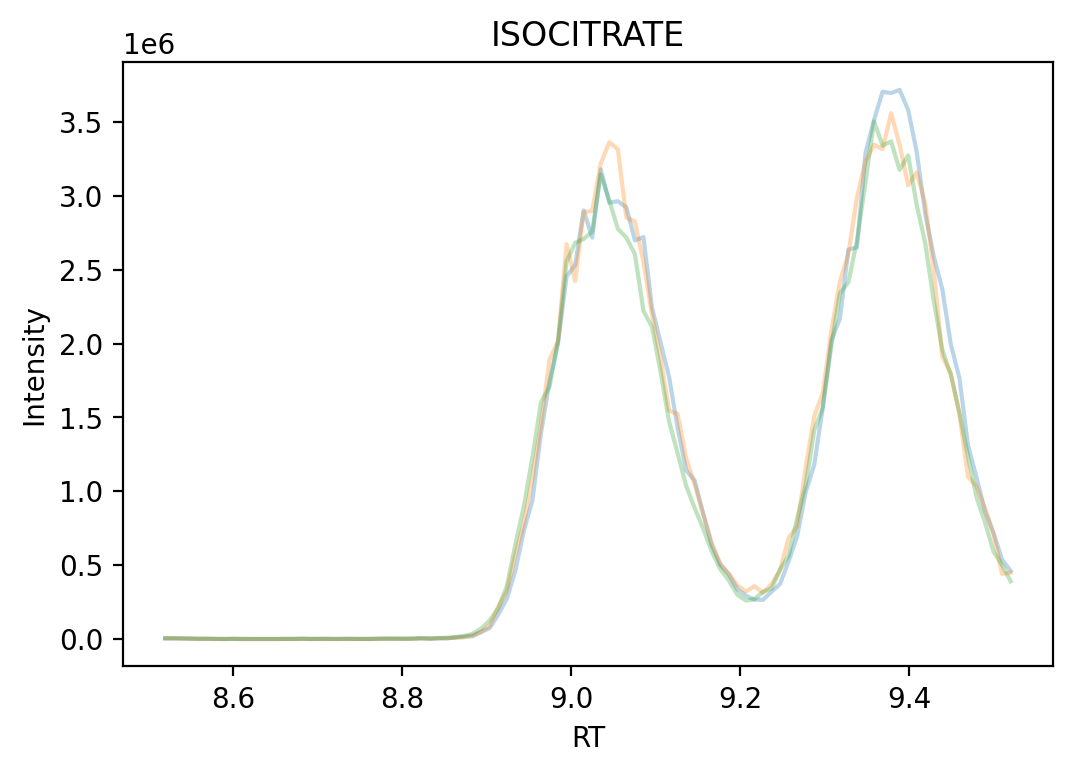

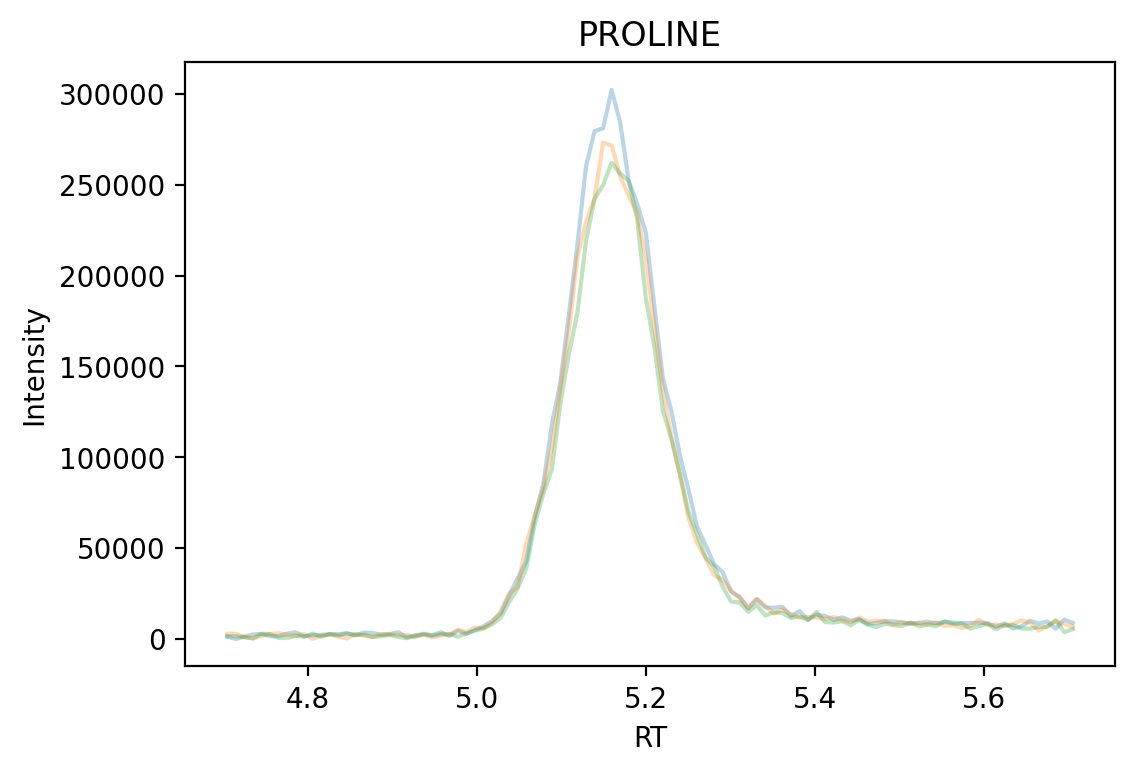

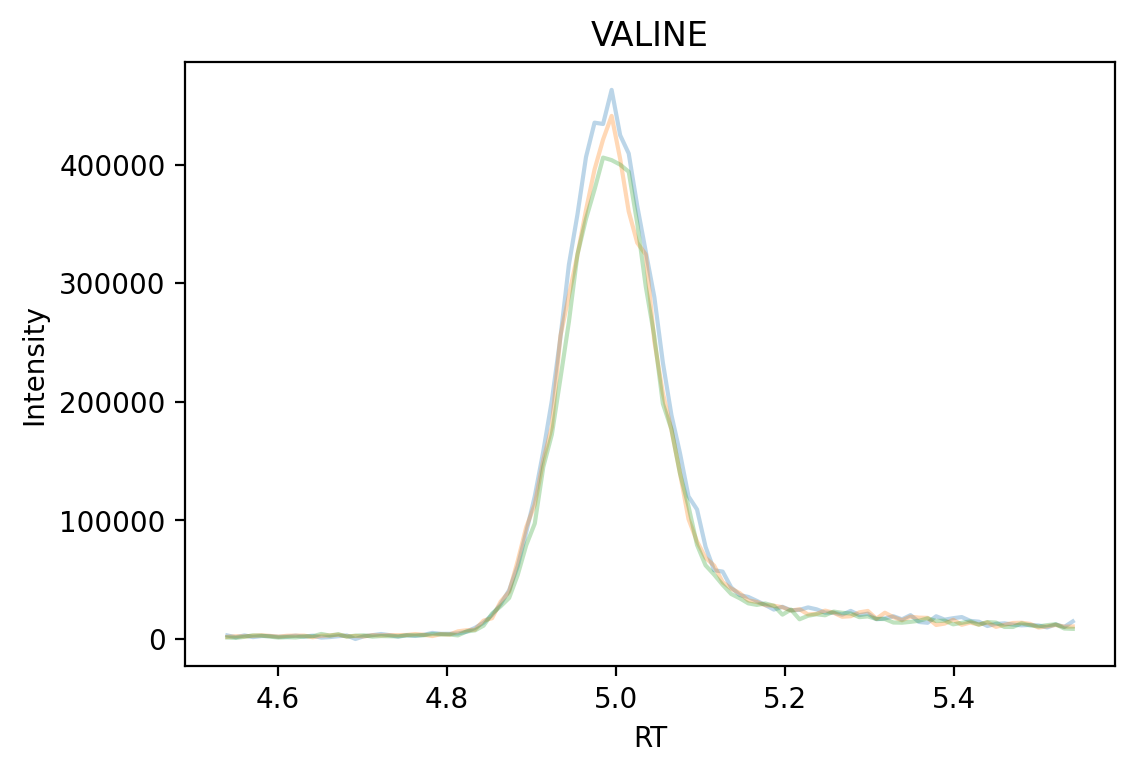

In [34]:
for mz,rt,name in real_peaks:
    if name in misClass["metabolite"].values:
        plt.figure()
        integ.plot_overlayedEIC([raw_data[file] for file in files],mz,rt-.5,rt + .5)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        plt.title(name)

In [35]:
corClass = df[df["classification"] == "true peak"]
corClass

metabolite classification  \
0                  Fructose 1,6-bisphosphate      true peak   
2                            Acetoacetyl-CoA      true peak   
3                                 Acetyl-CoA      true peak   
4                            Chelidamic Acid      true peak   
6                            CMP-sialic acid      true peak   
..                                       ...            ...   
205                                   URACIL      true peak   
206                                  URIDINE      true peak   
207  URIDINE DIPHOSPHATE-N-ACETYLGLUCOSAMINE      true peak   
208                                   VALINE      true peak   
209                             OXOGLUTARATE      true peak   

                       sample  
0    M3T-Std_neg_DDA_1mz.mzML  
2    M3T-Std_neg_DDA_1mz.mzML  
3    M3T-Std_neg_DDA_1mz.mzML  
4    M3T-Std_neg_DDA_1mz.mzML  
6    M3T-Std_neg_DDA_1mz.mzML  
..                        ...  
205  M3T-Std_neg_DDA_5mz.mzML  
206  M3T-Std_neg_DDA_5mz.mzML  
207  M3T-Std_neg_DDA_5mz.mzML  
208  M3T-Std_neg_DDA_5mz.mzML  
209  M3T-Std_neg_DDA_5mz.mzML  

[167 rows x 3 columns]

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



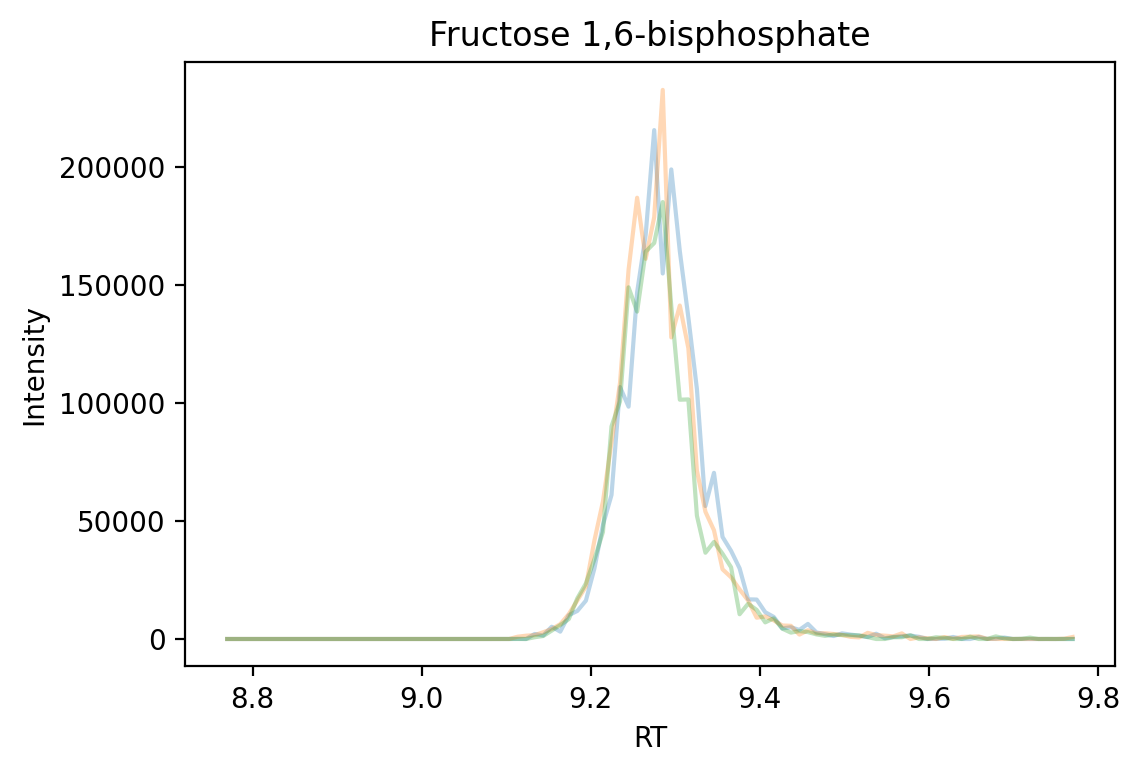

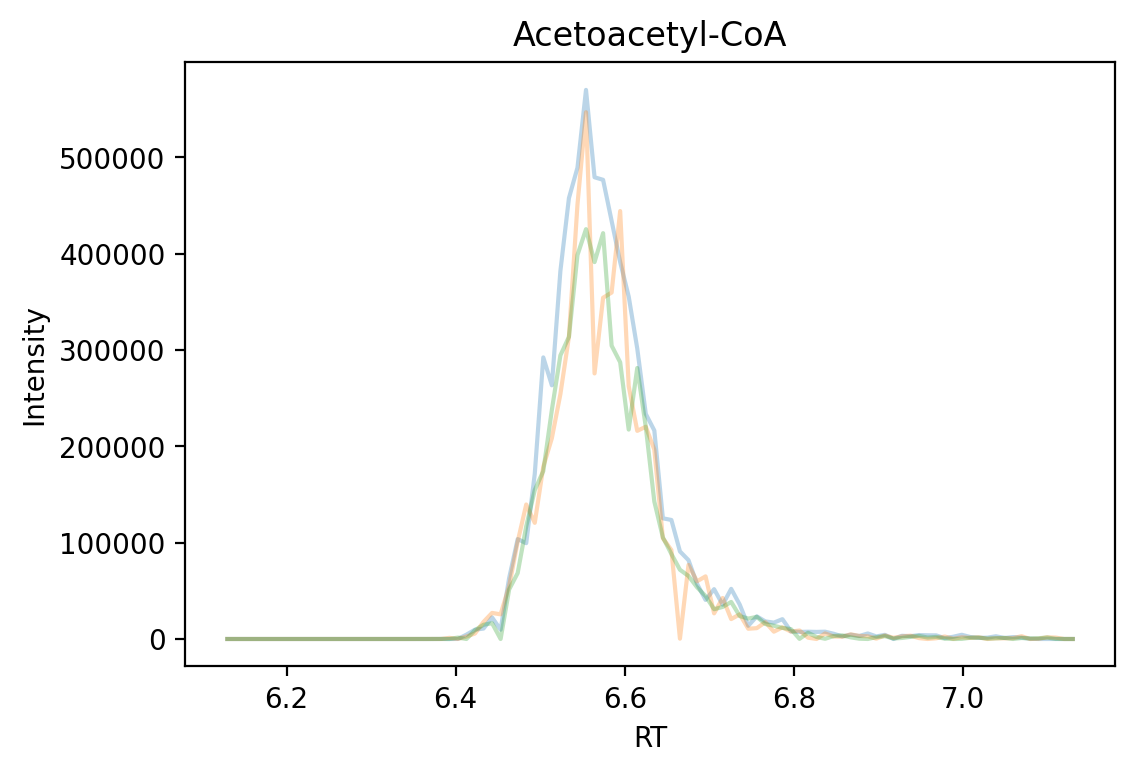

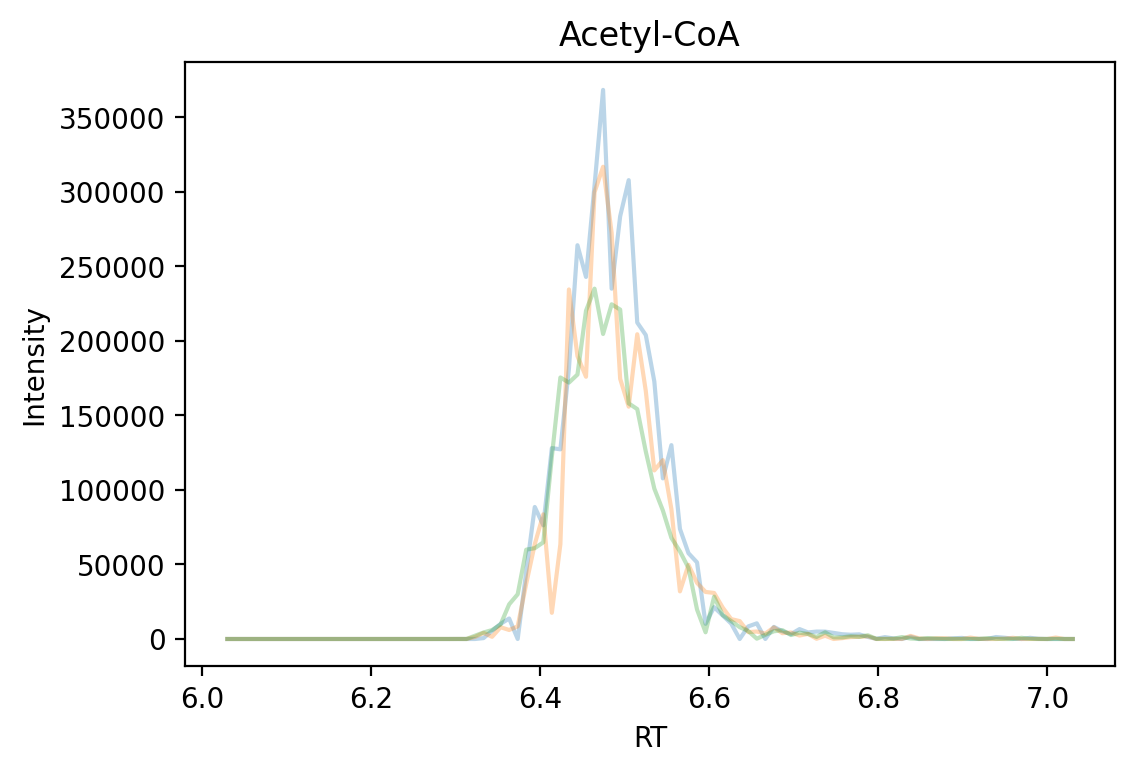

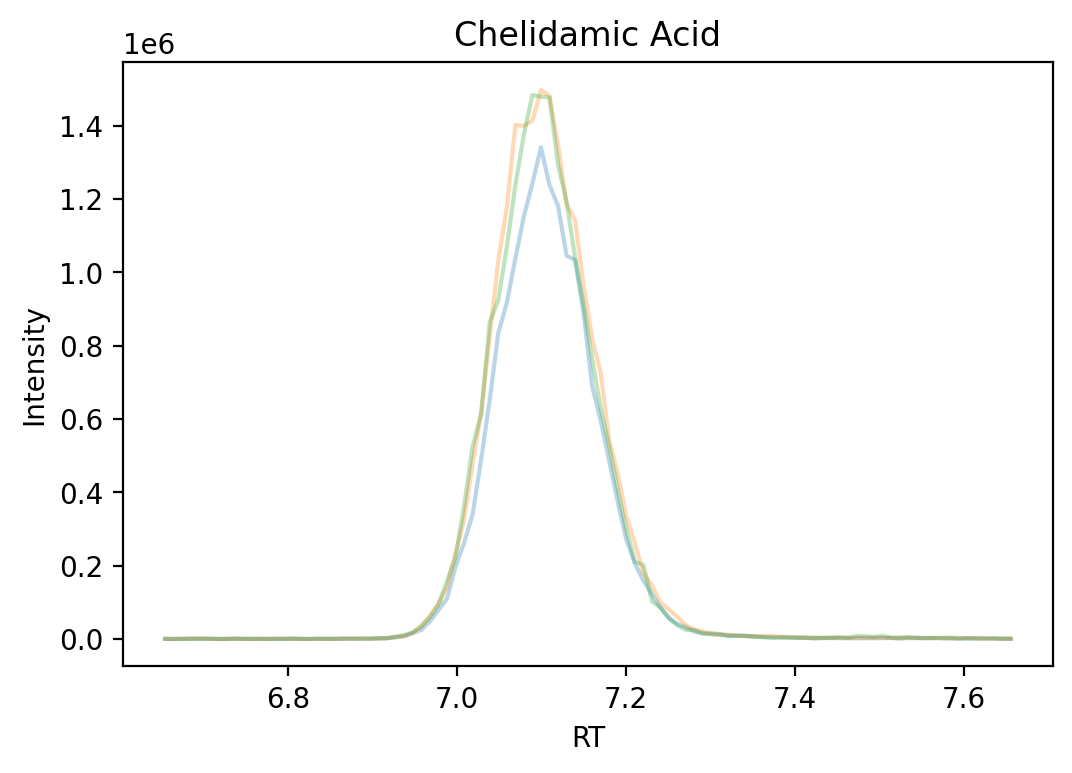

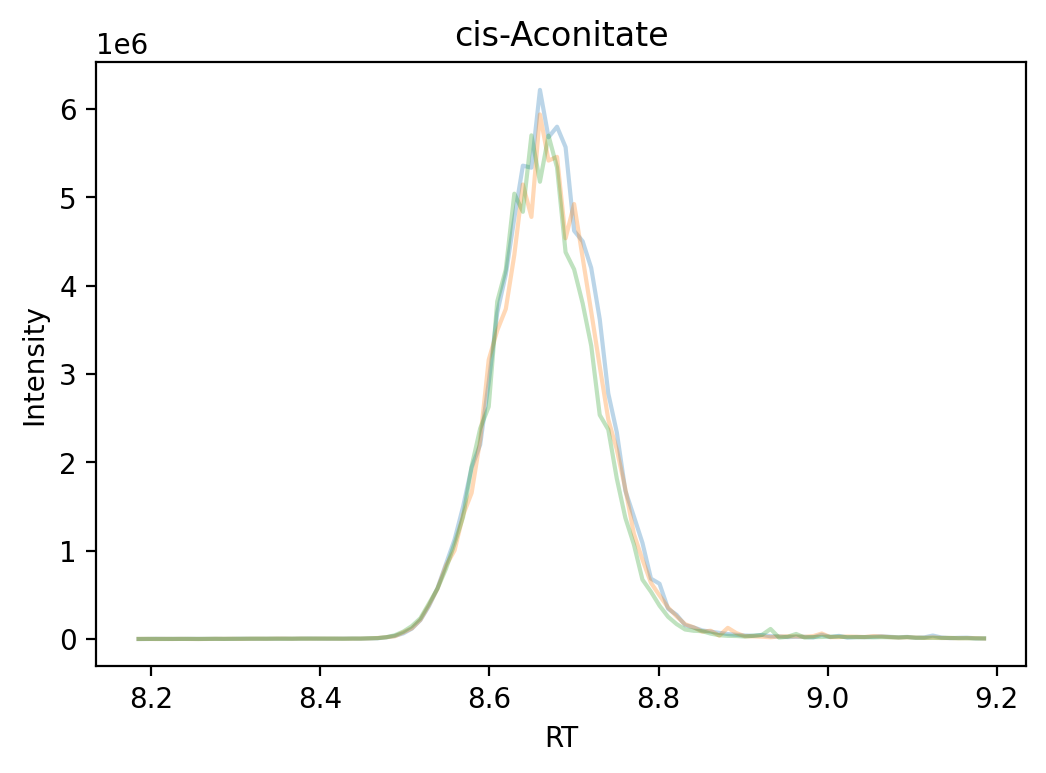

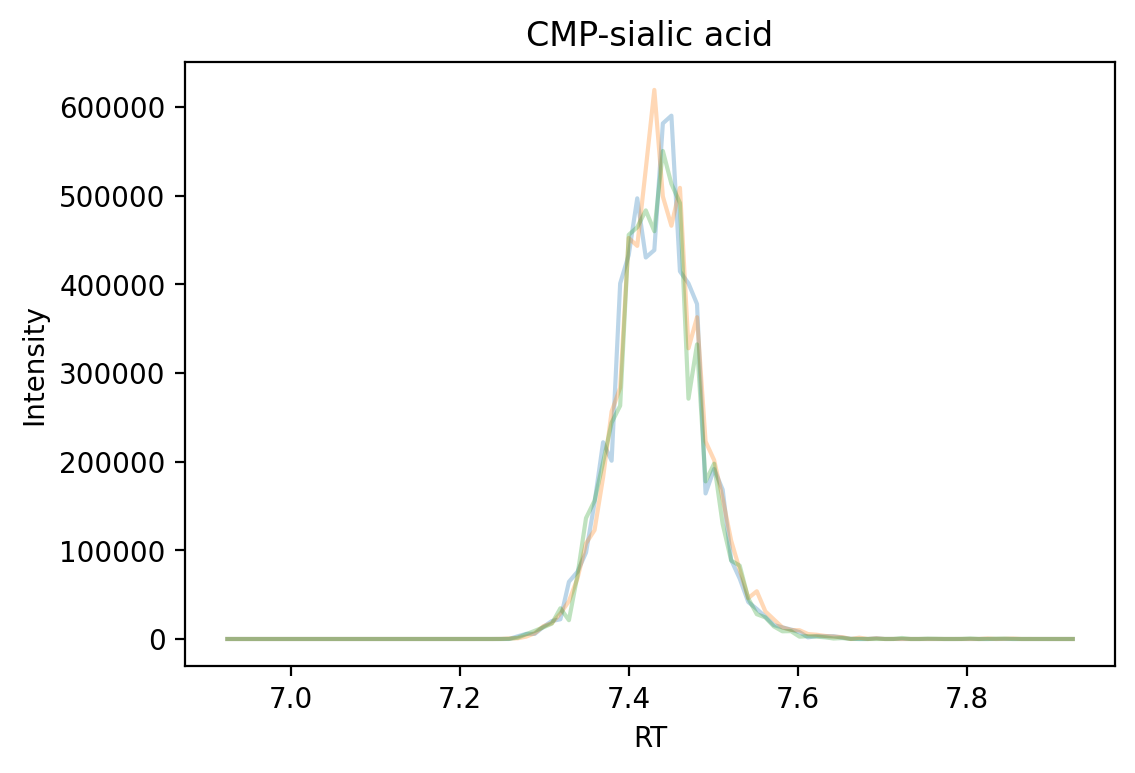

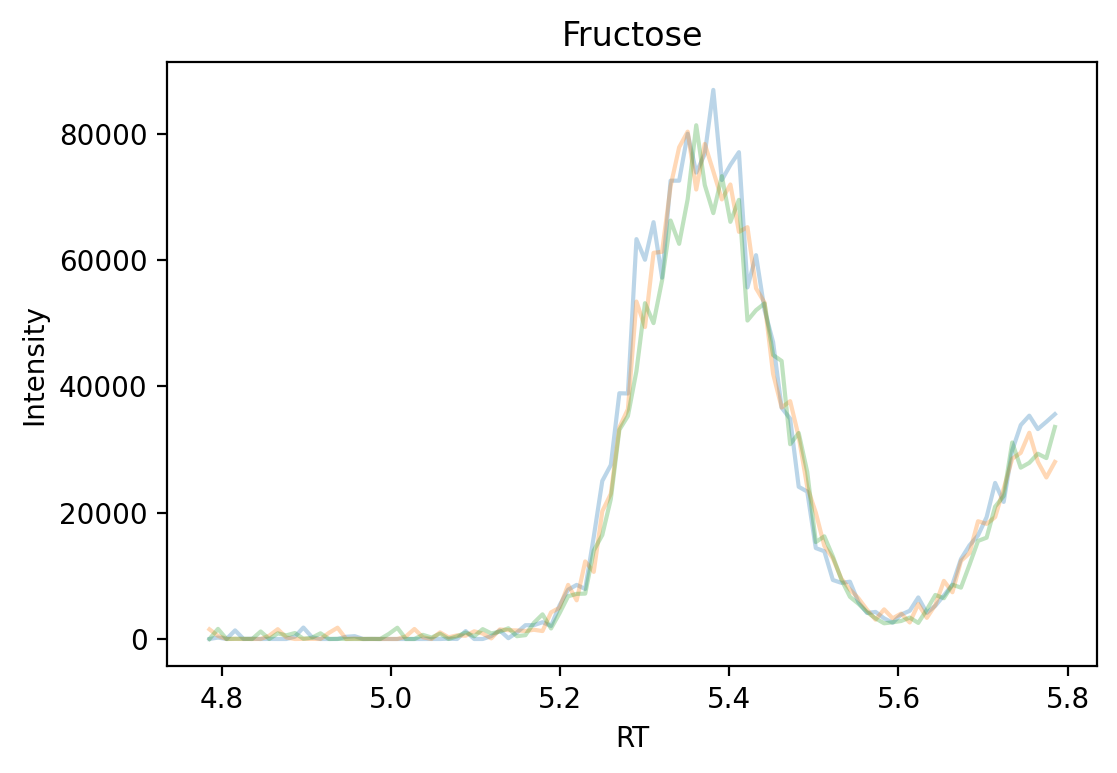

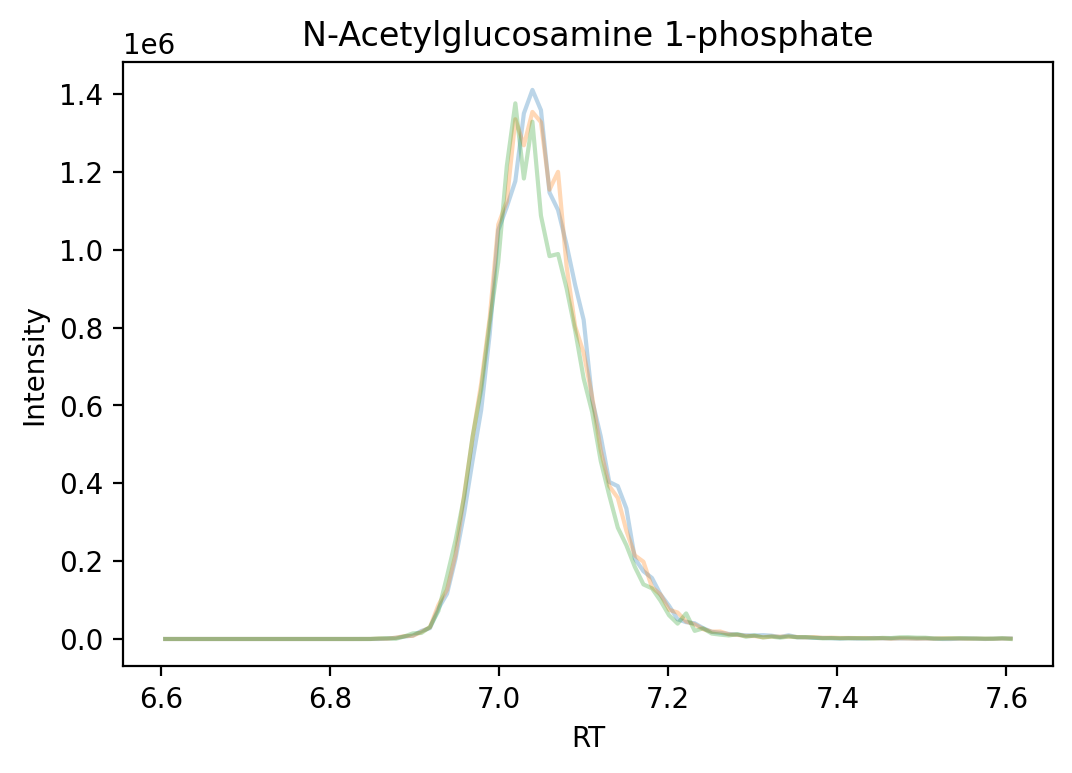

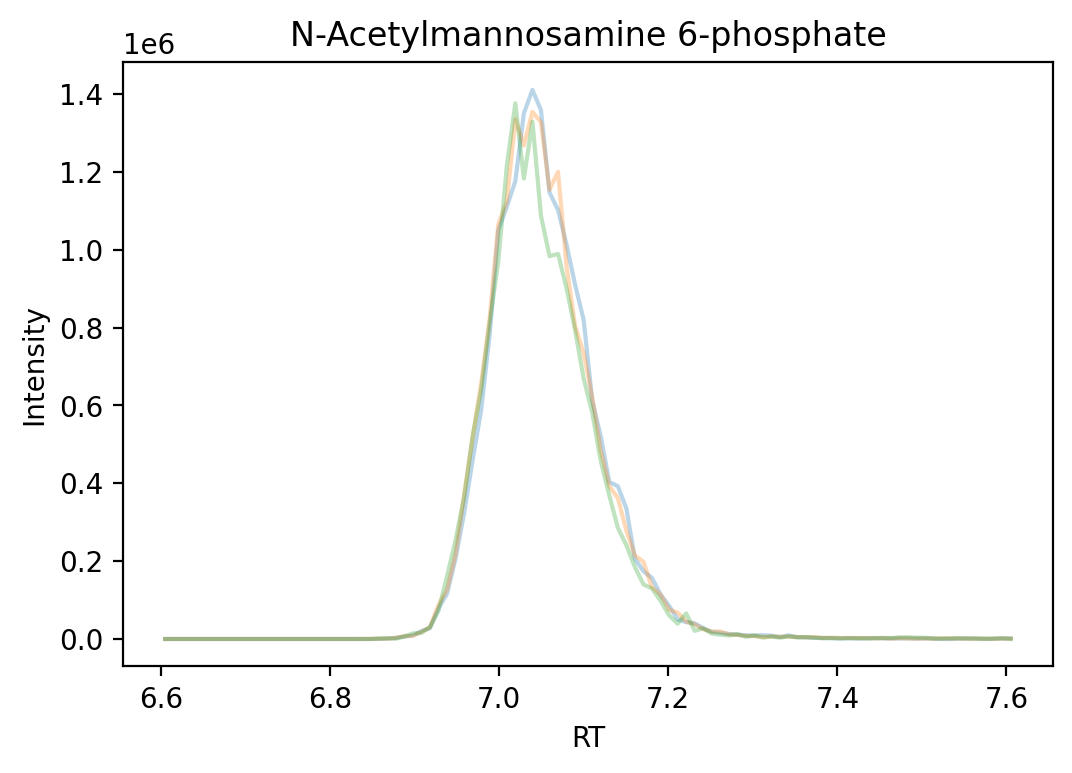

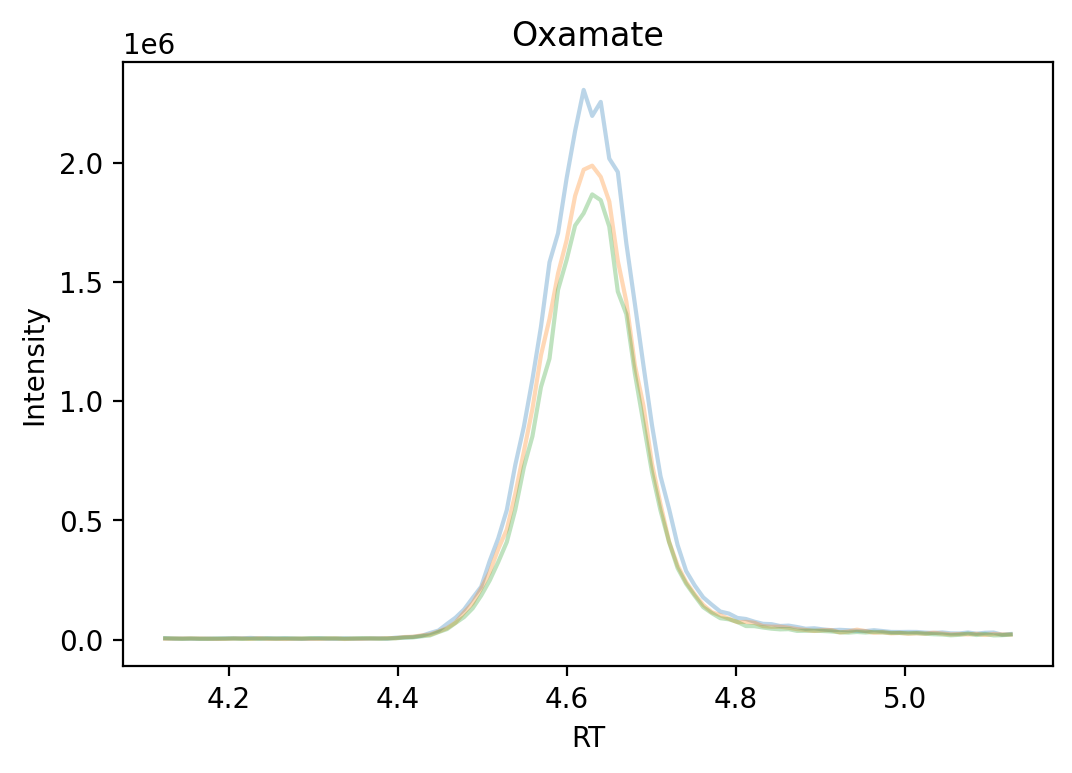

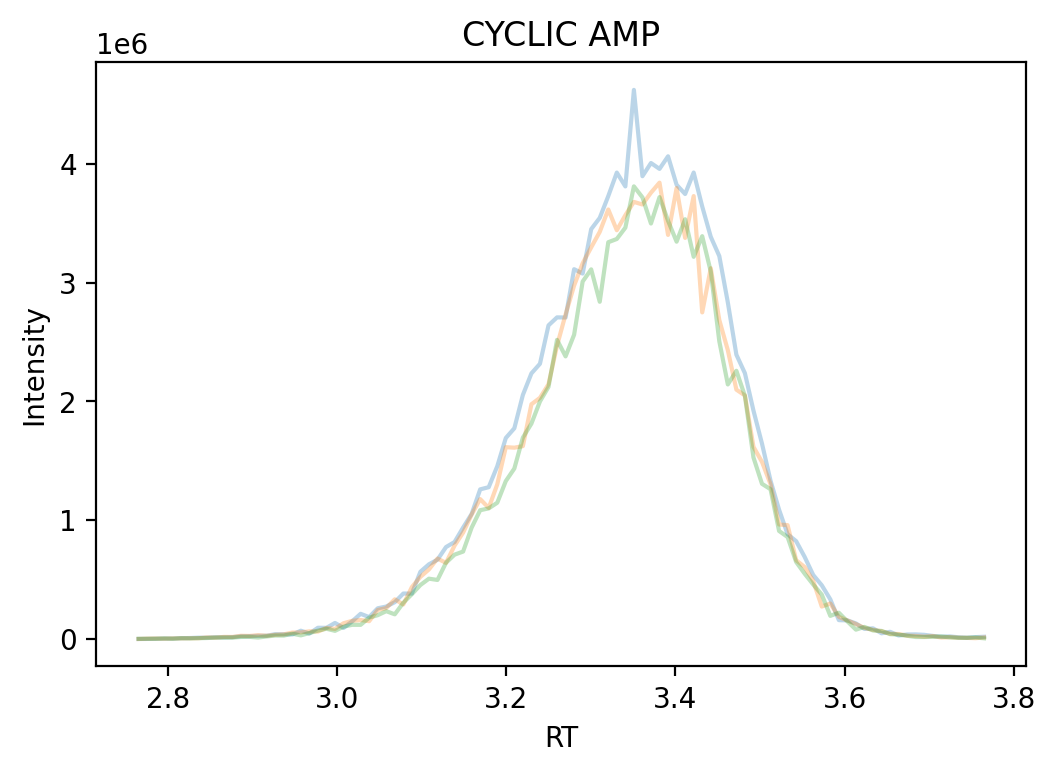

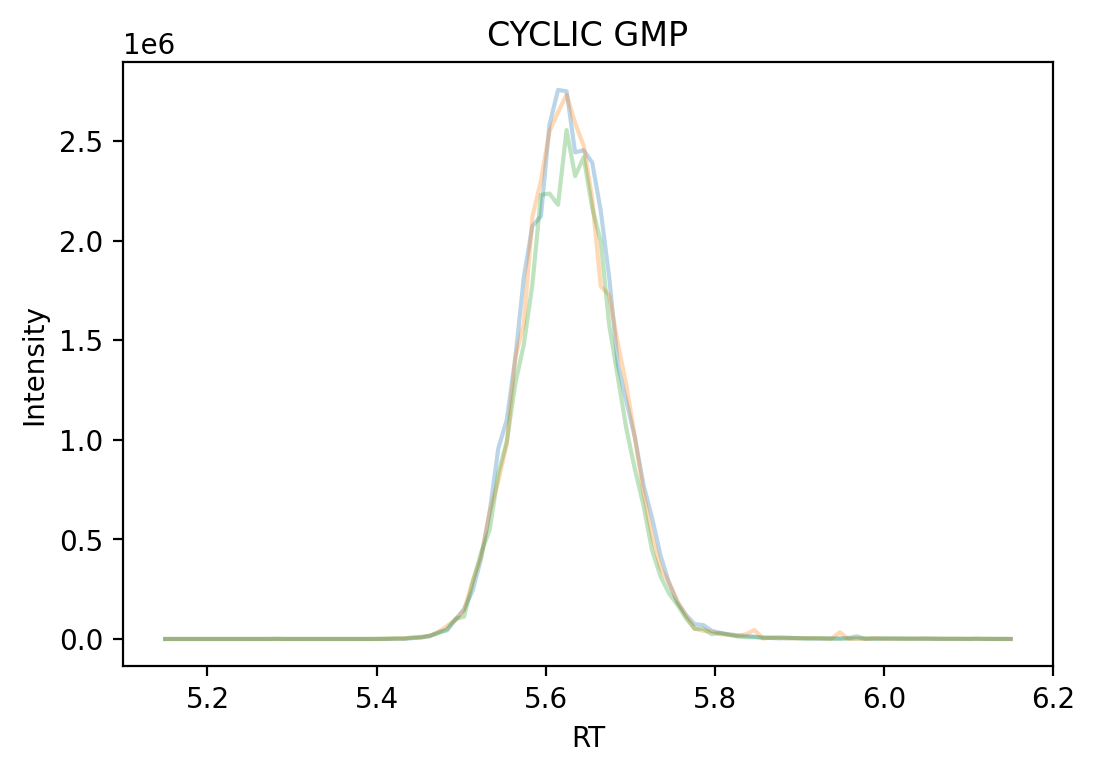

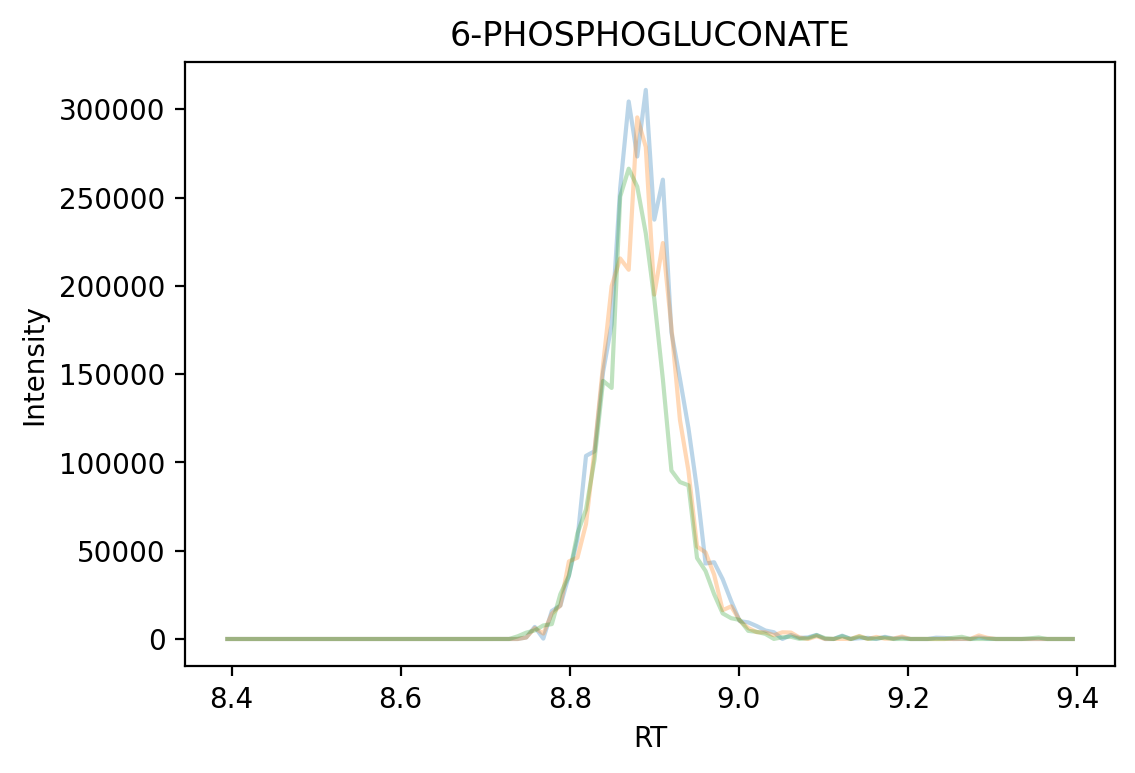

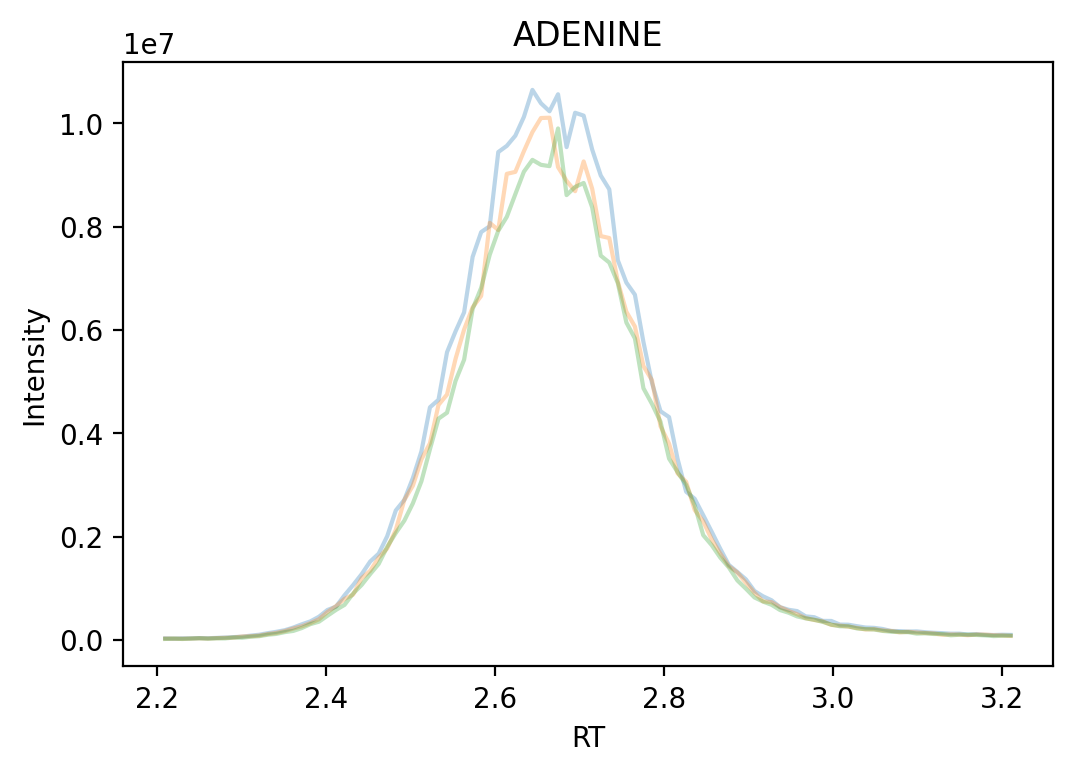

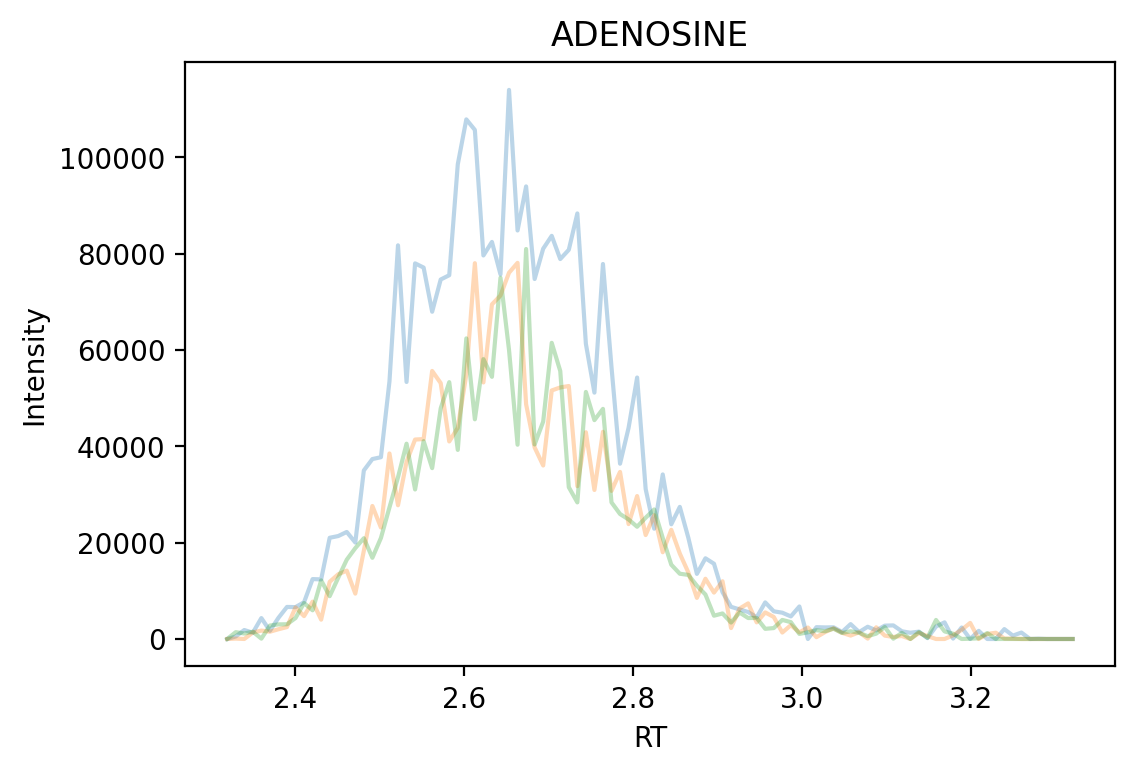

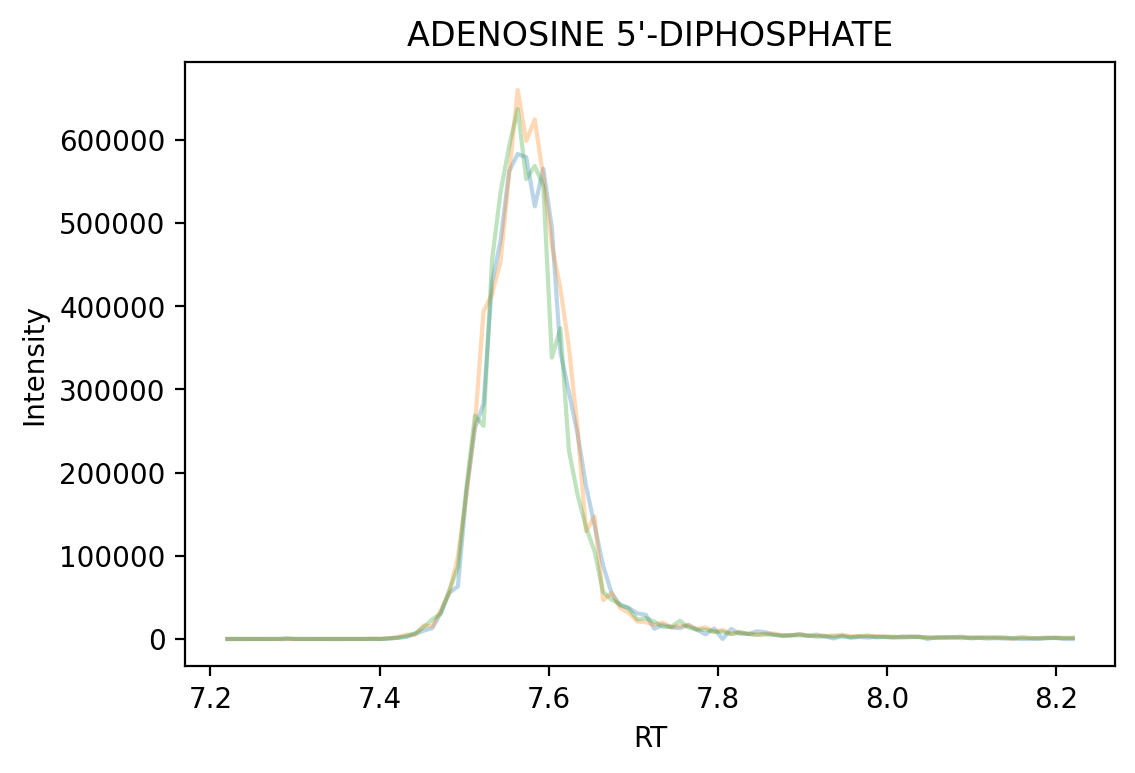

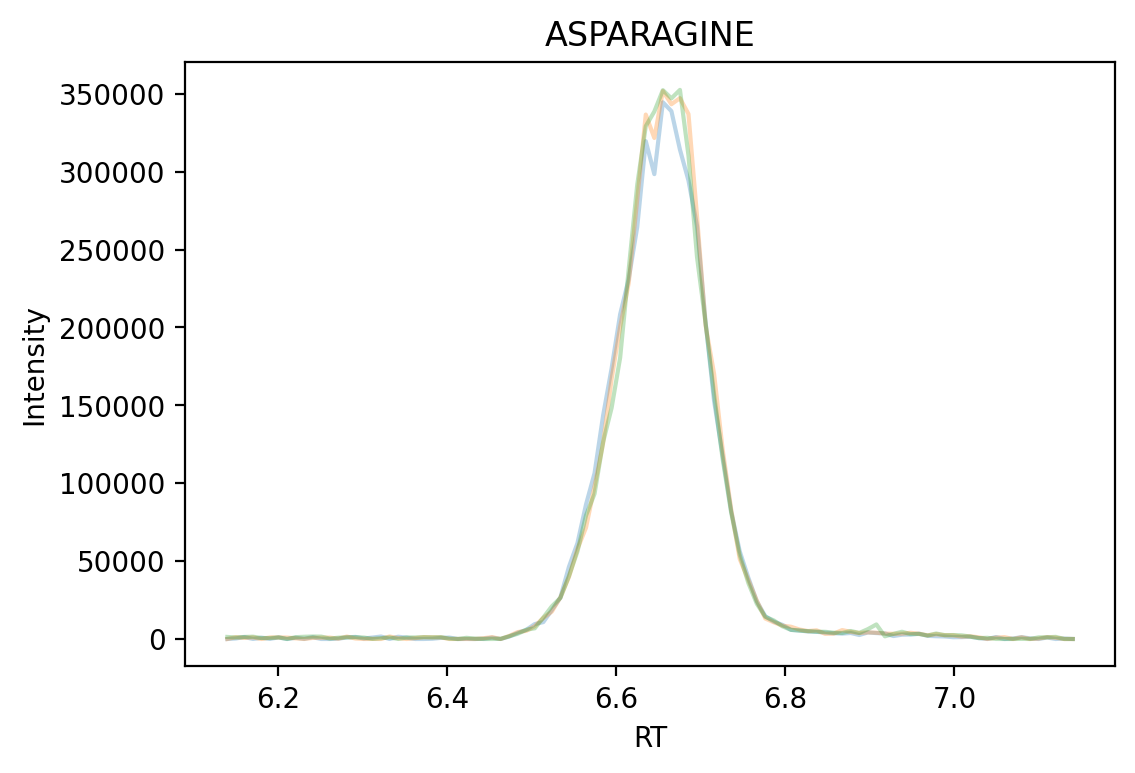

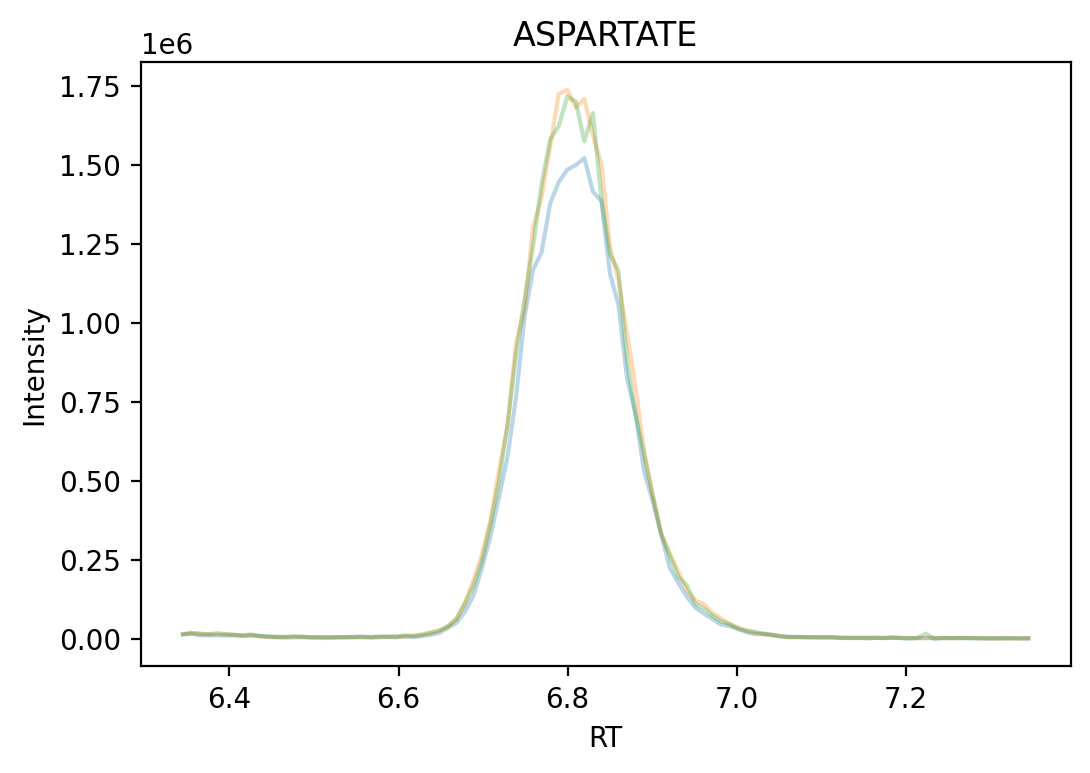

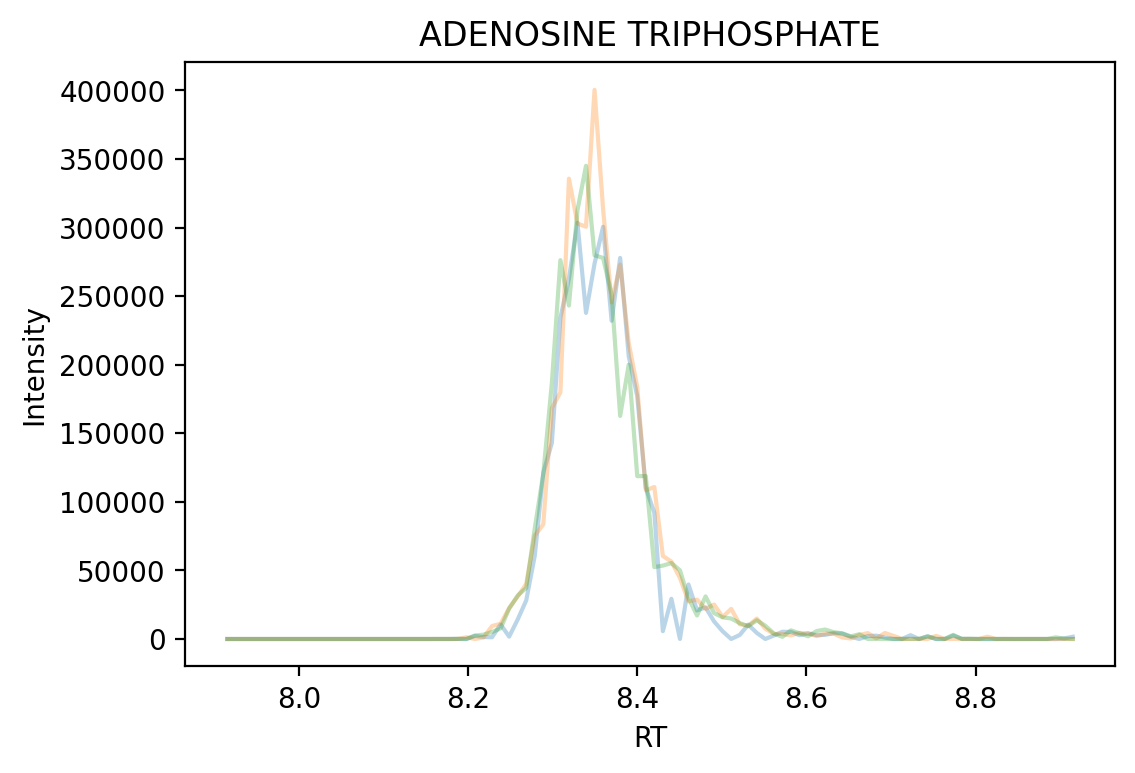

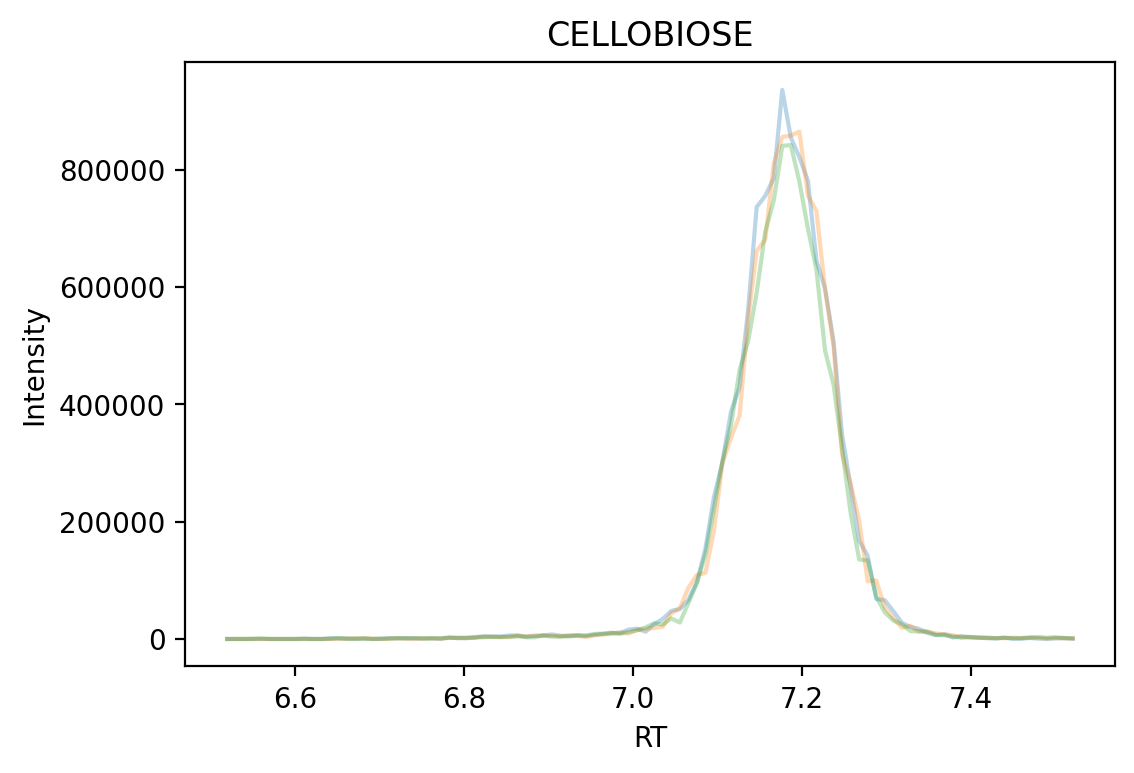

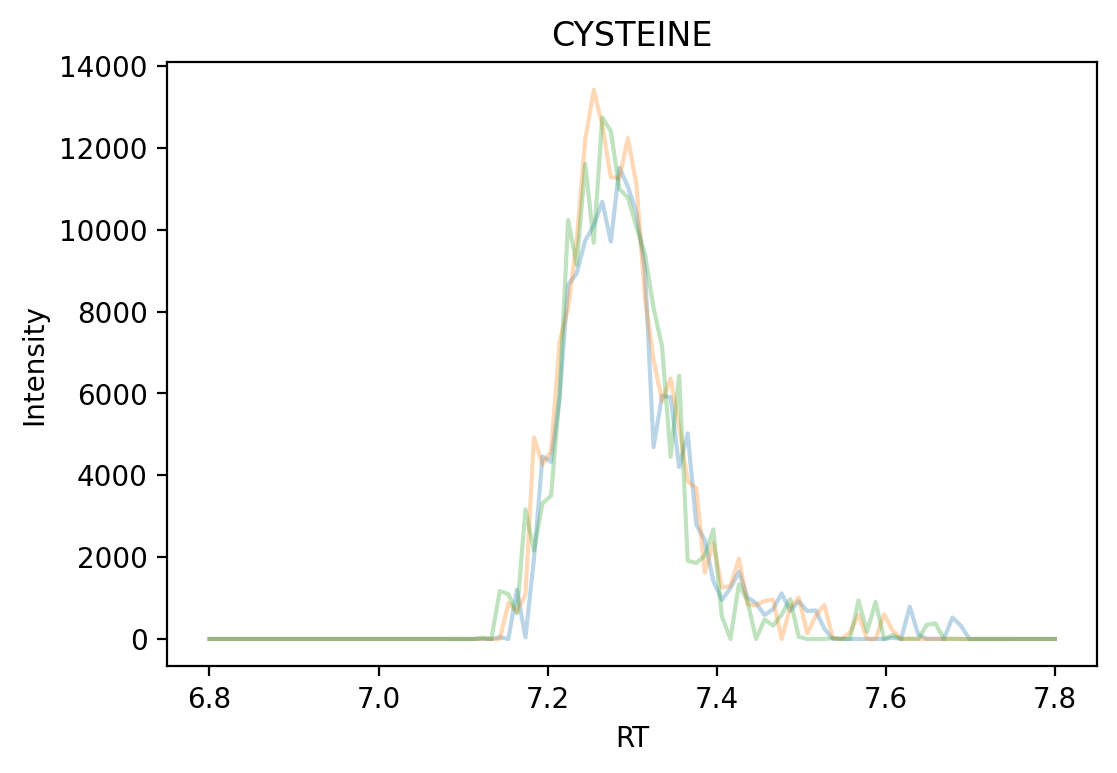

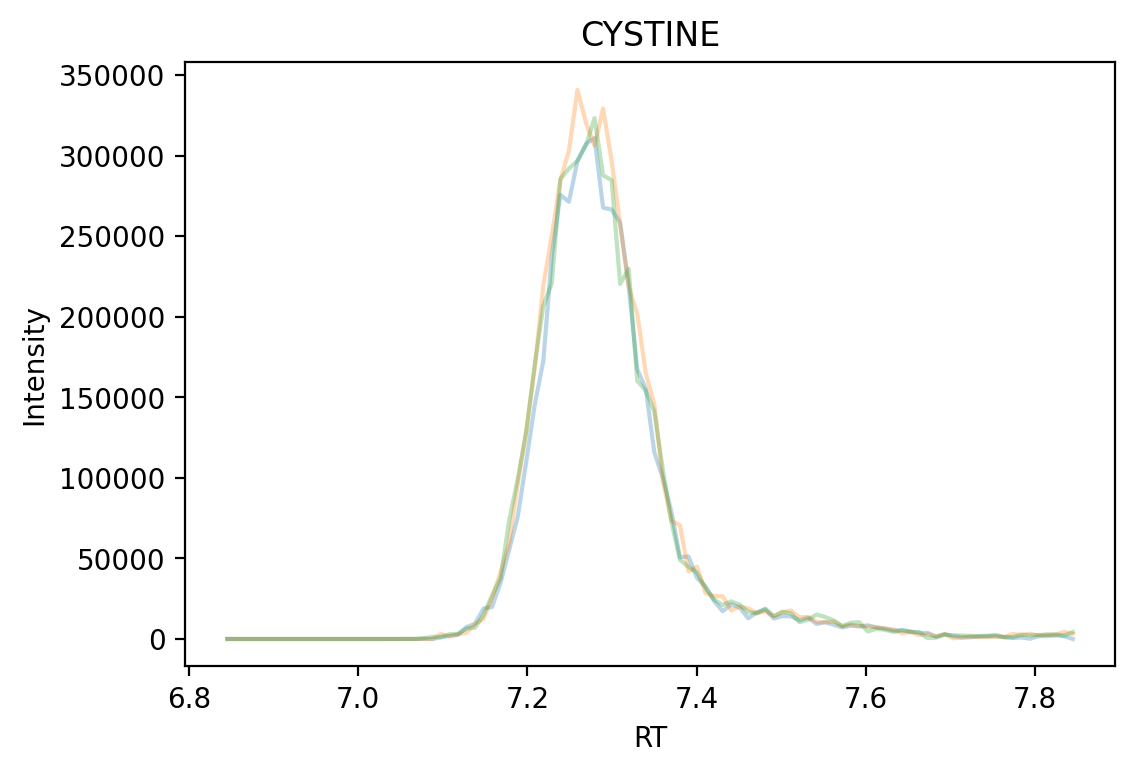

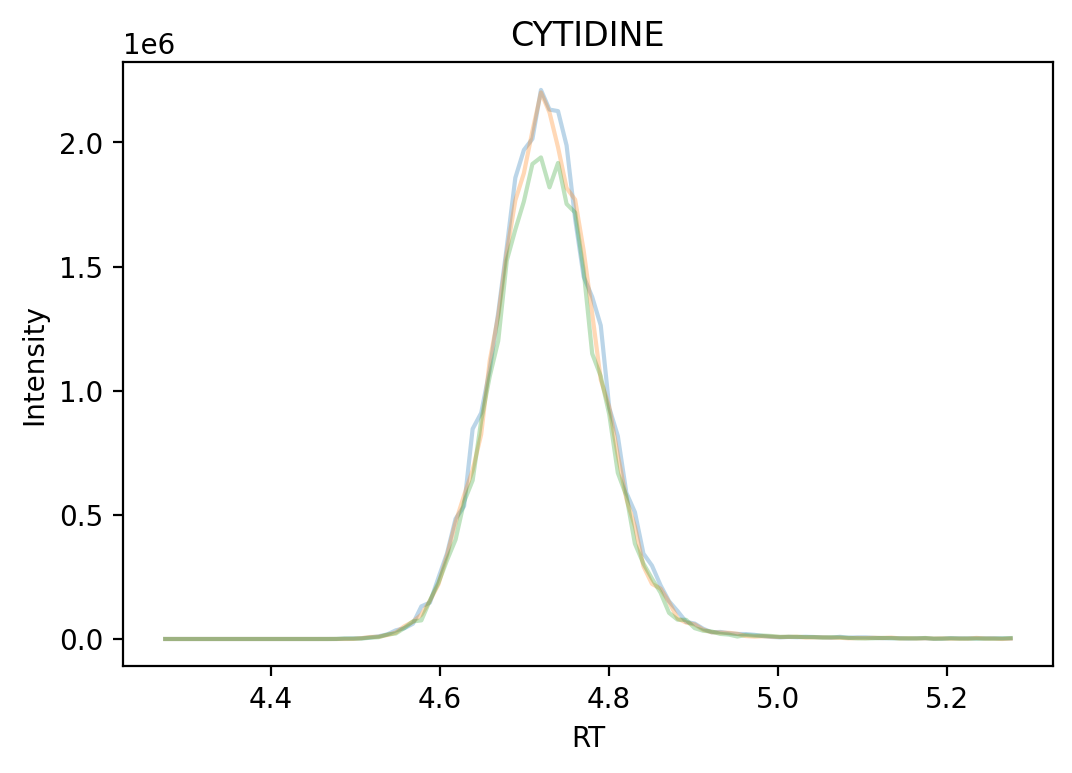

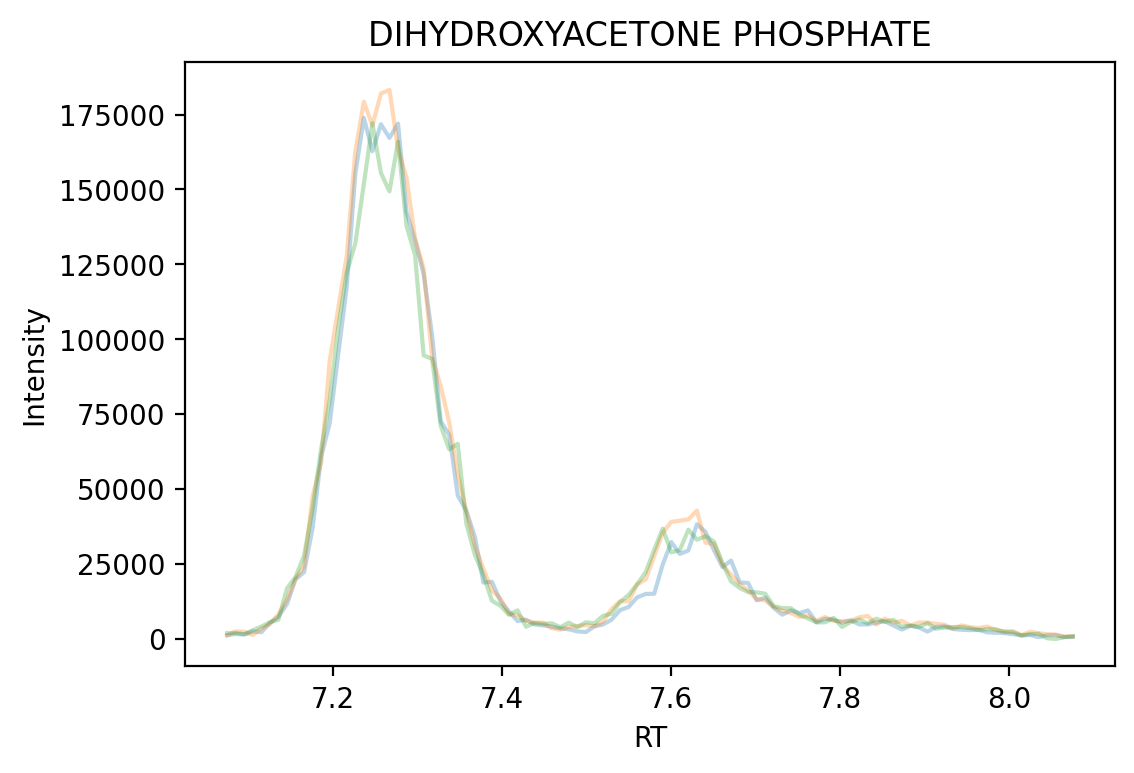

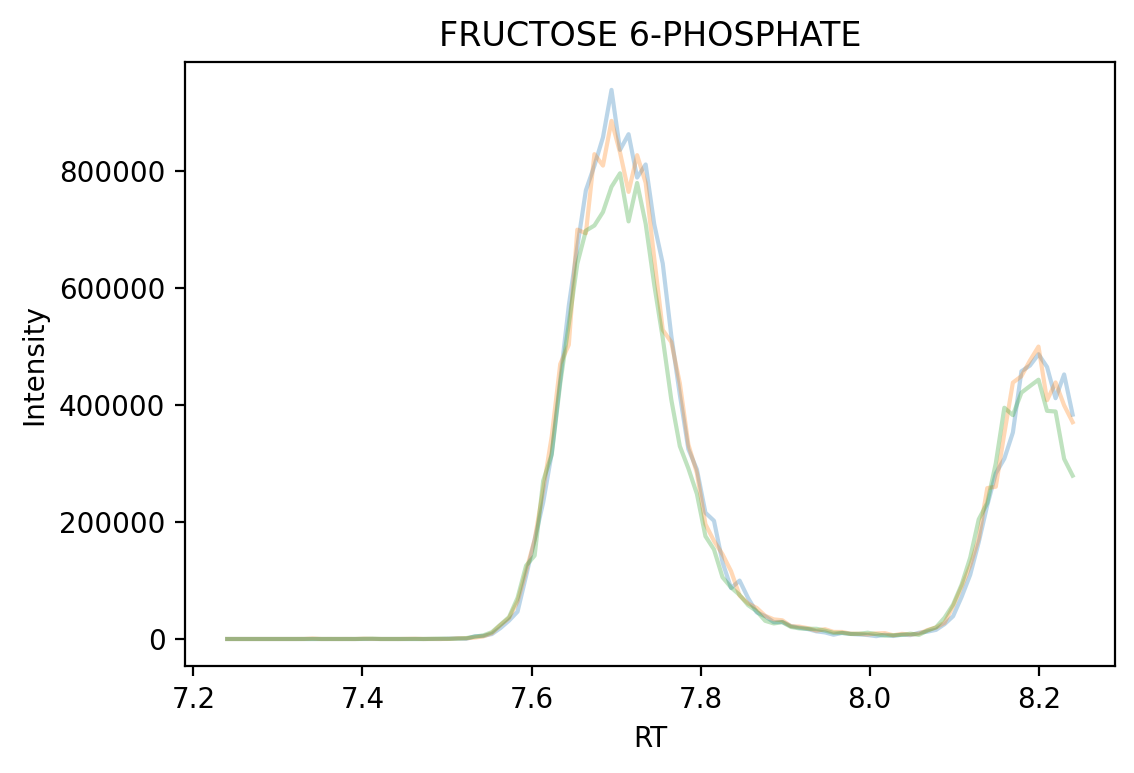

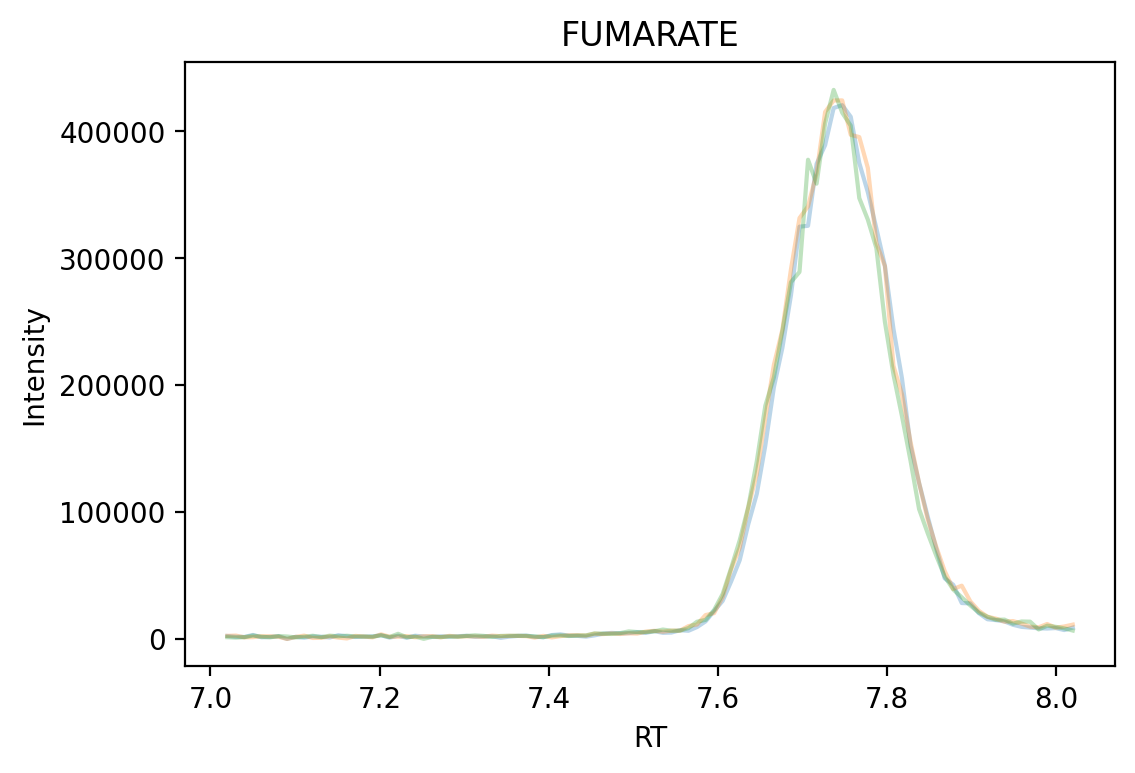

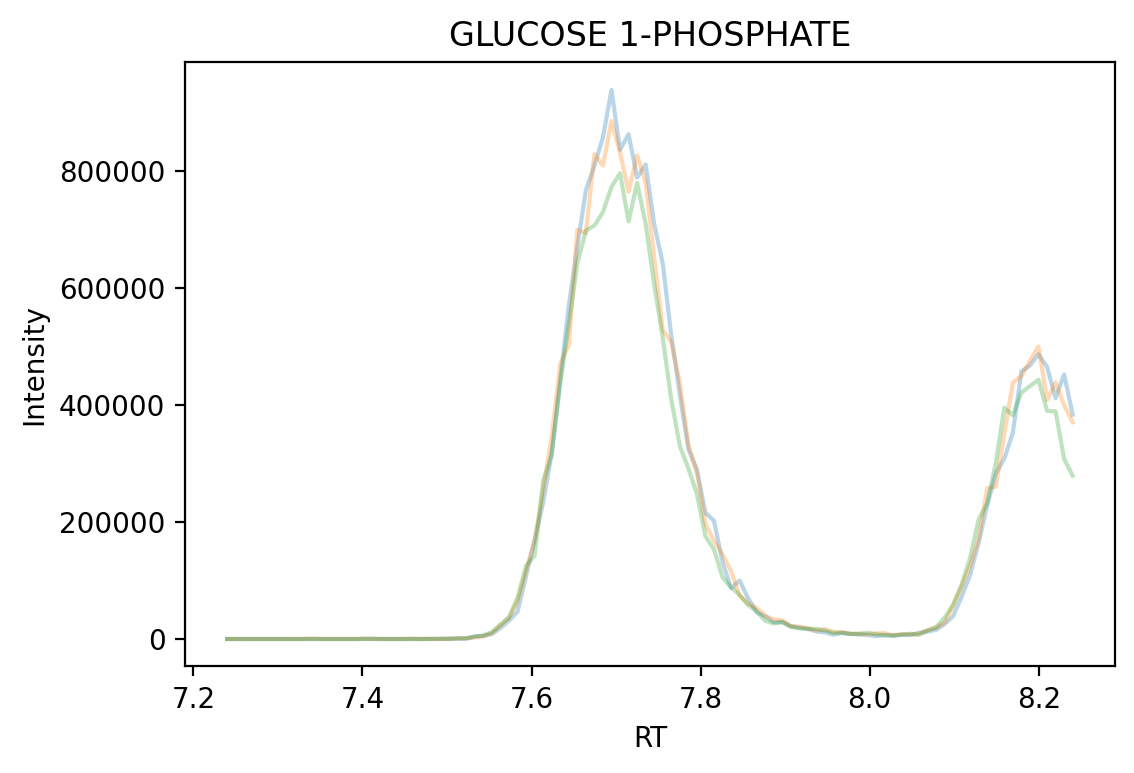

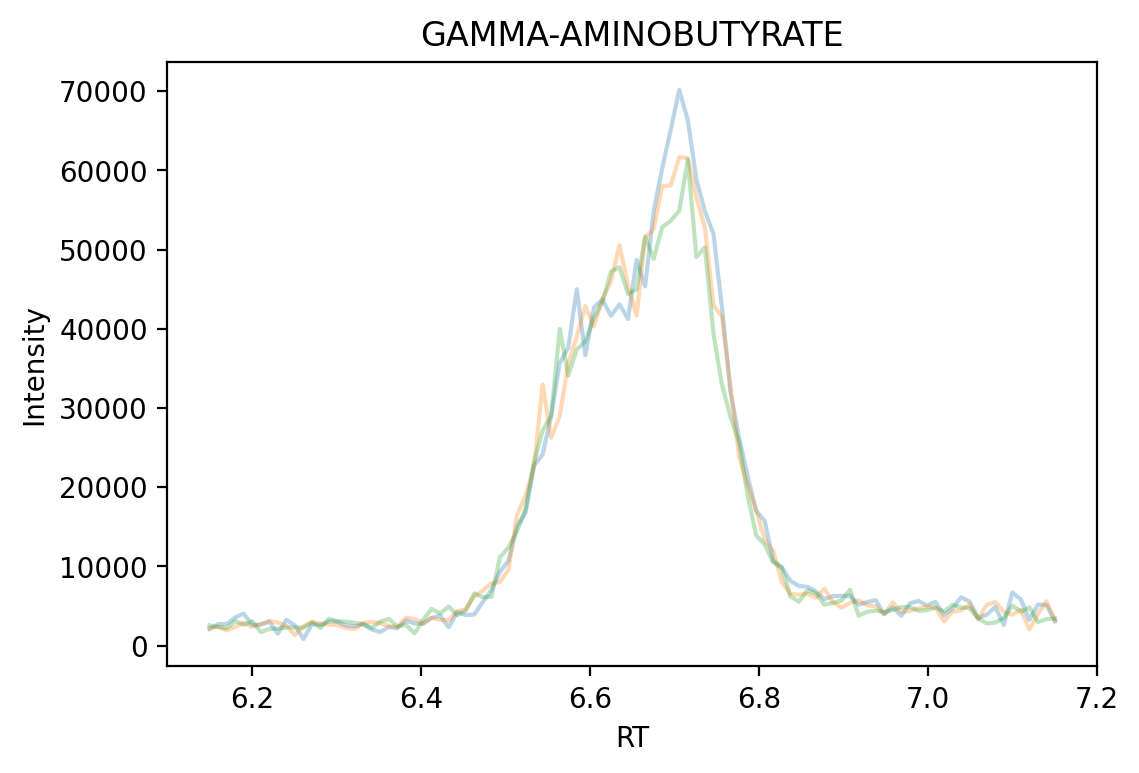

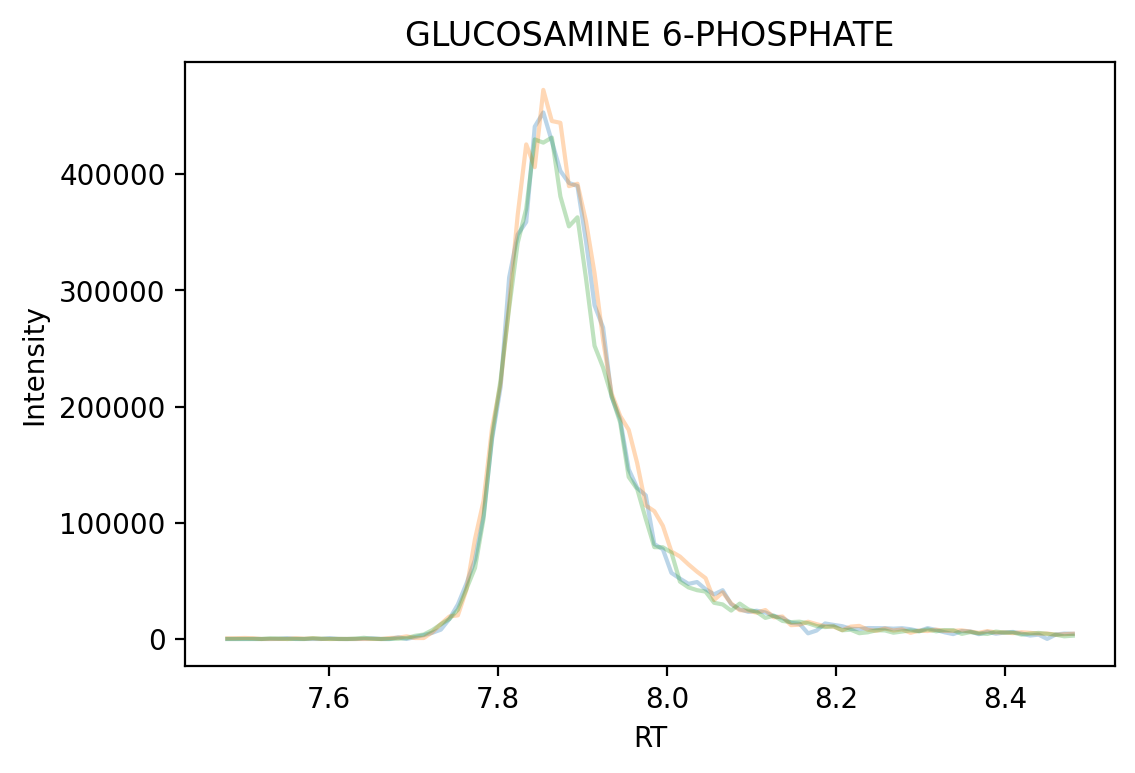

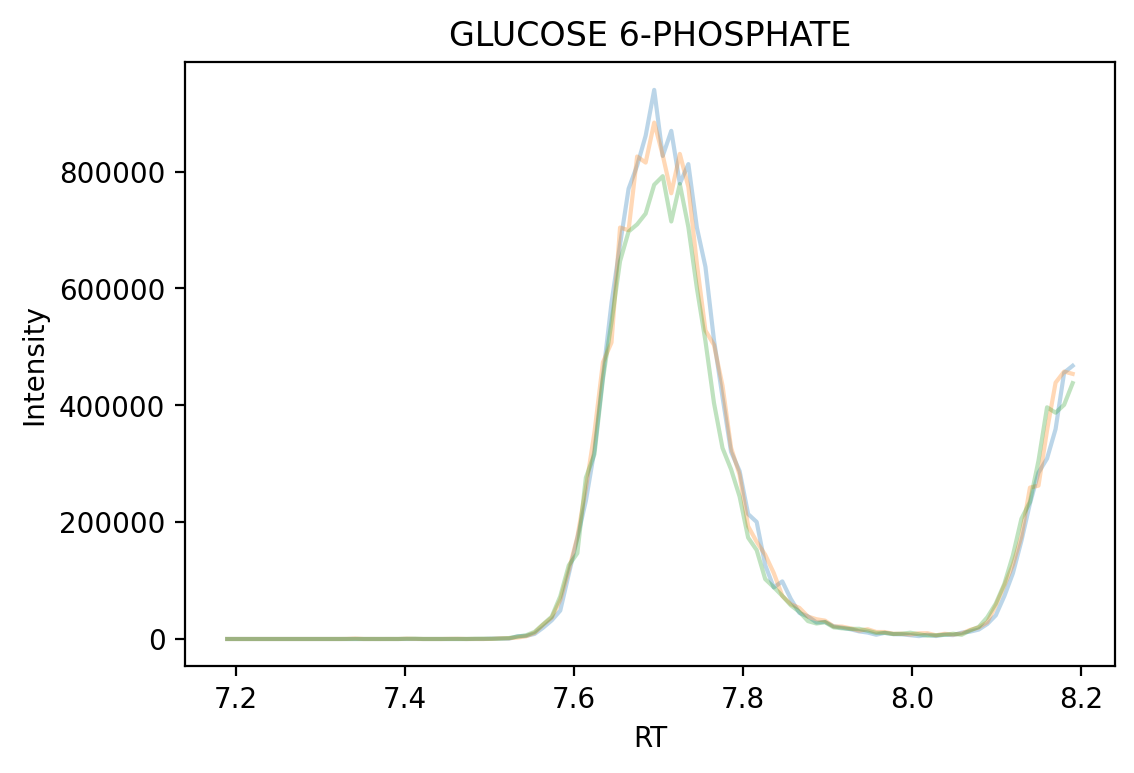

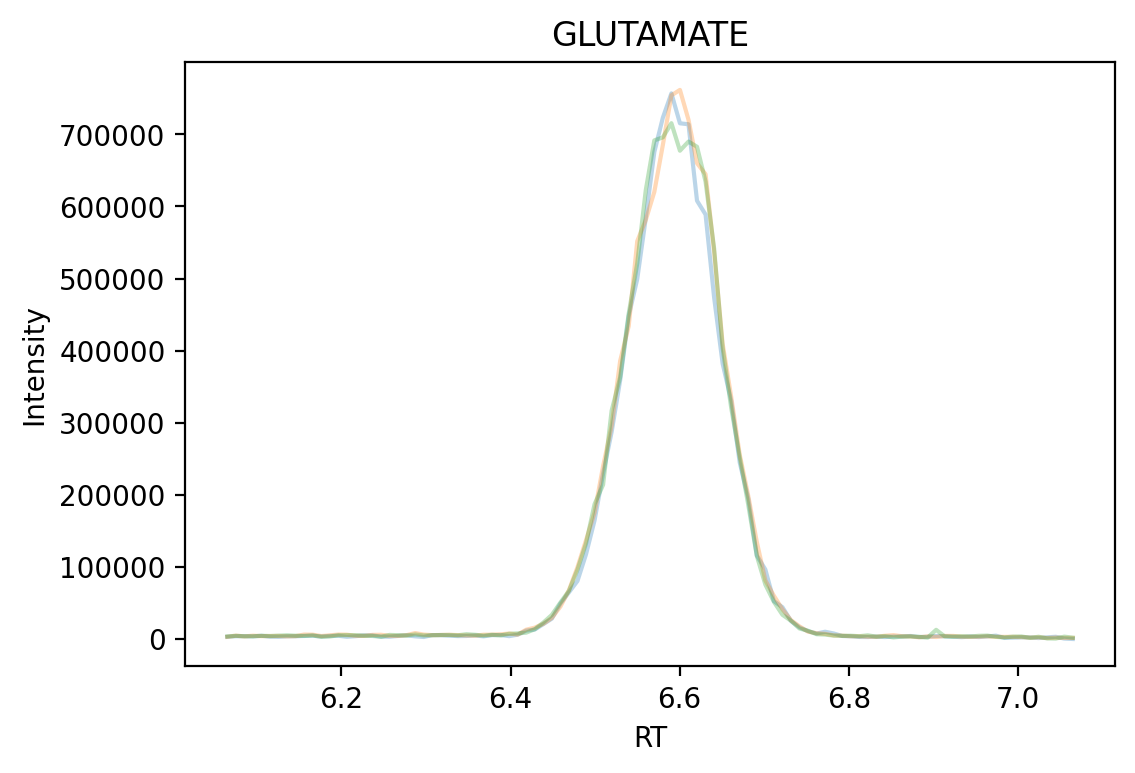

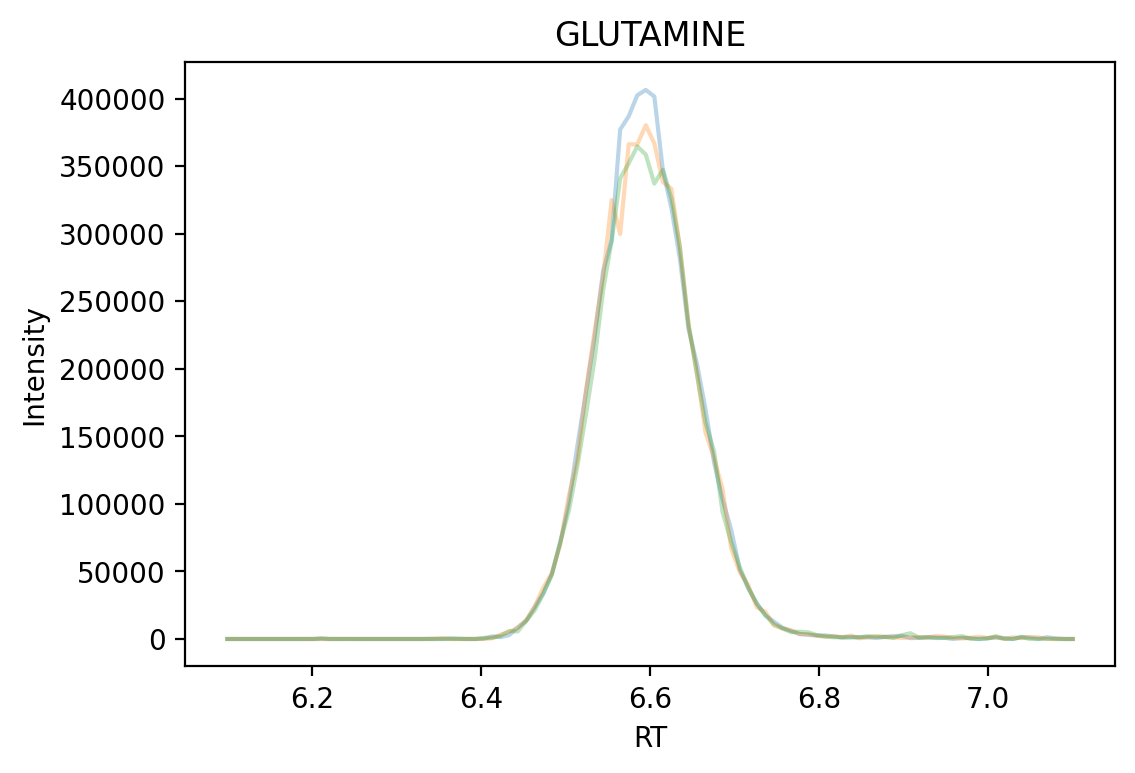

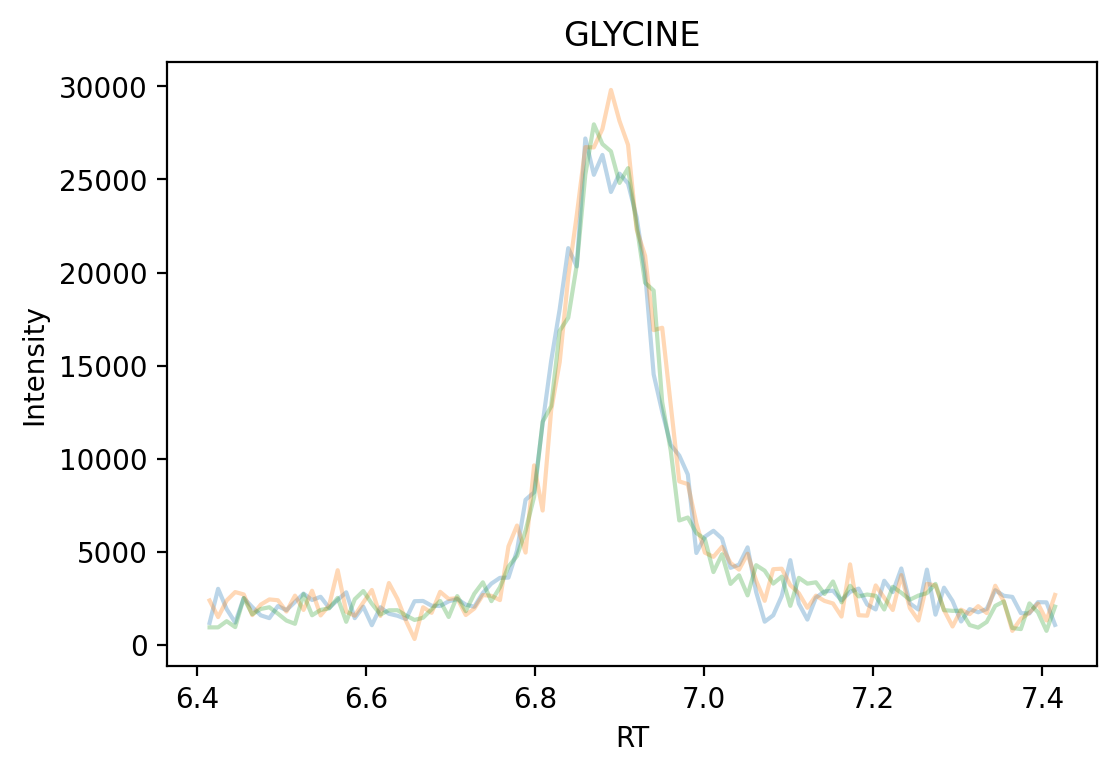

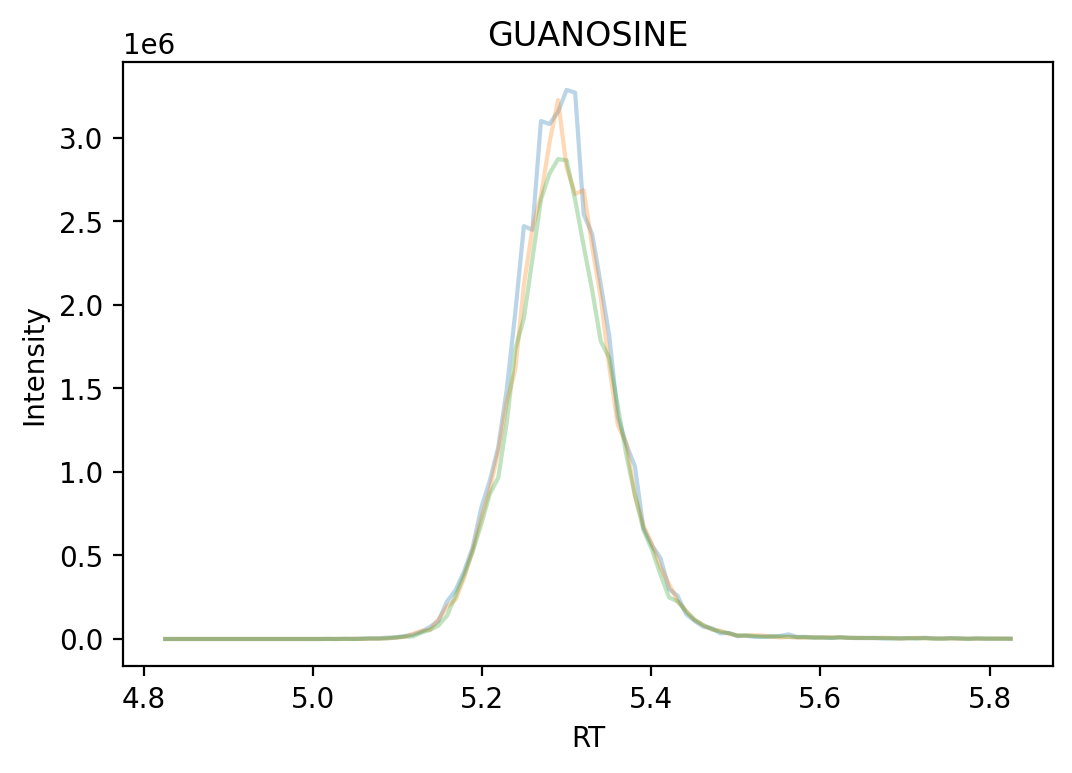

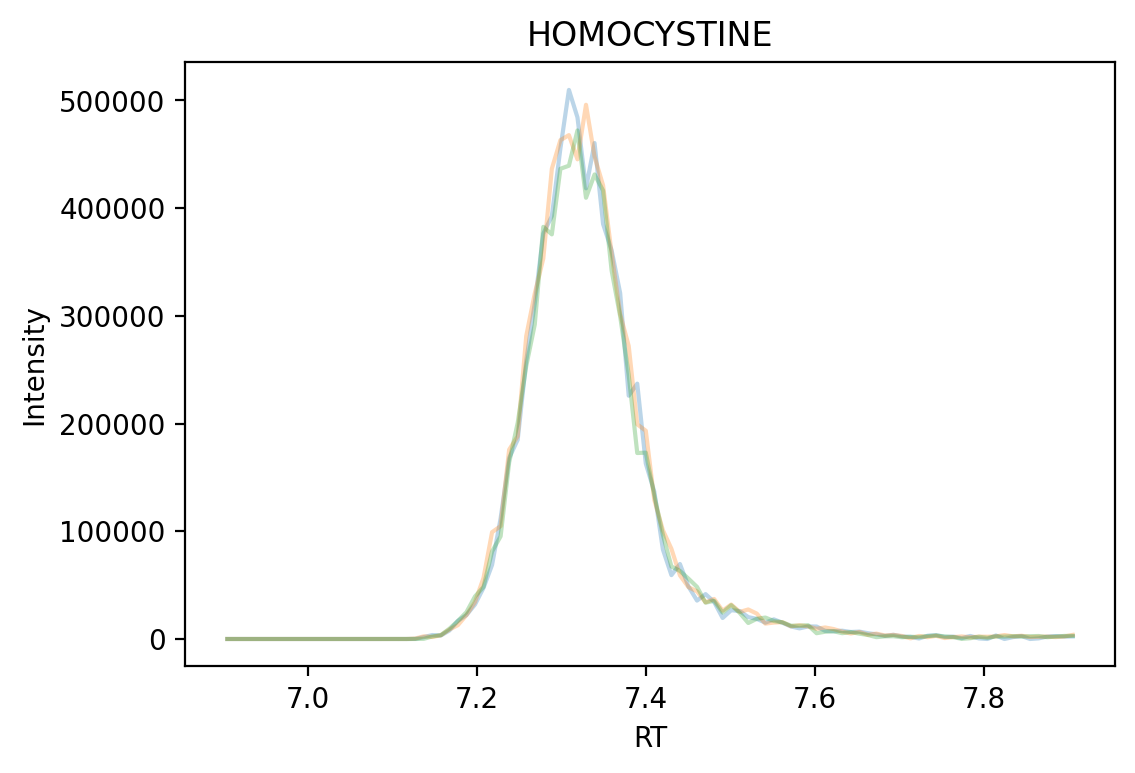

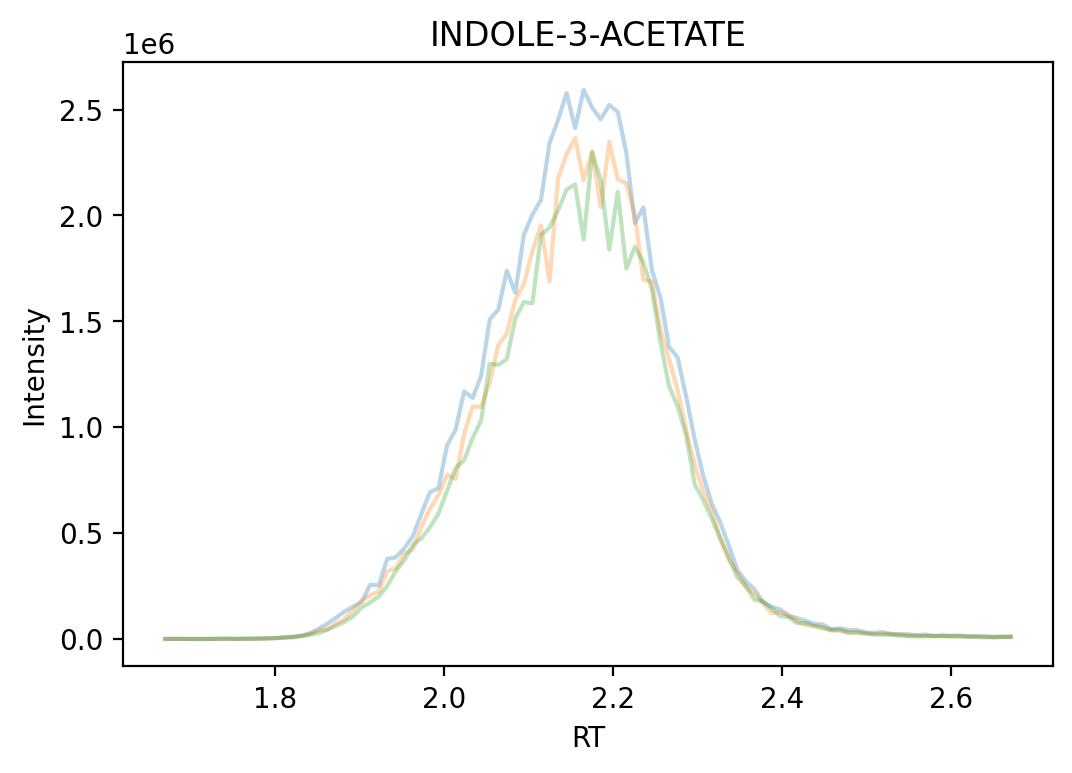

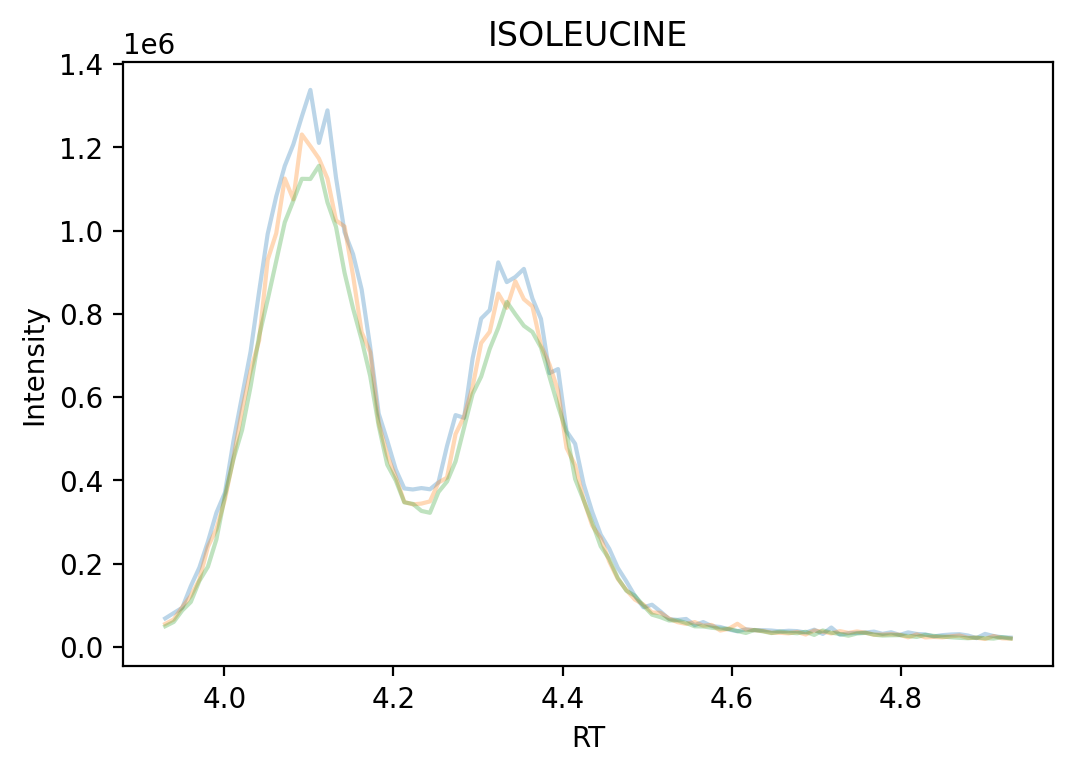

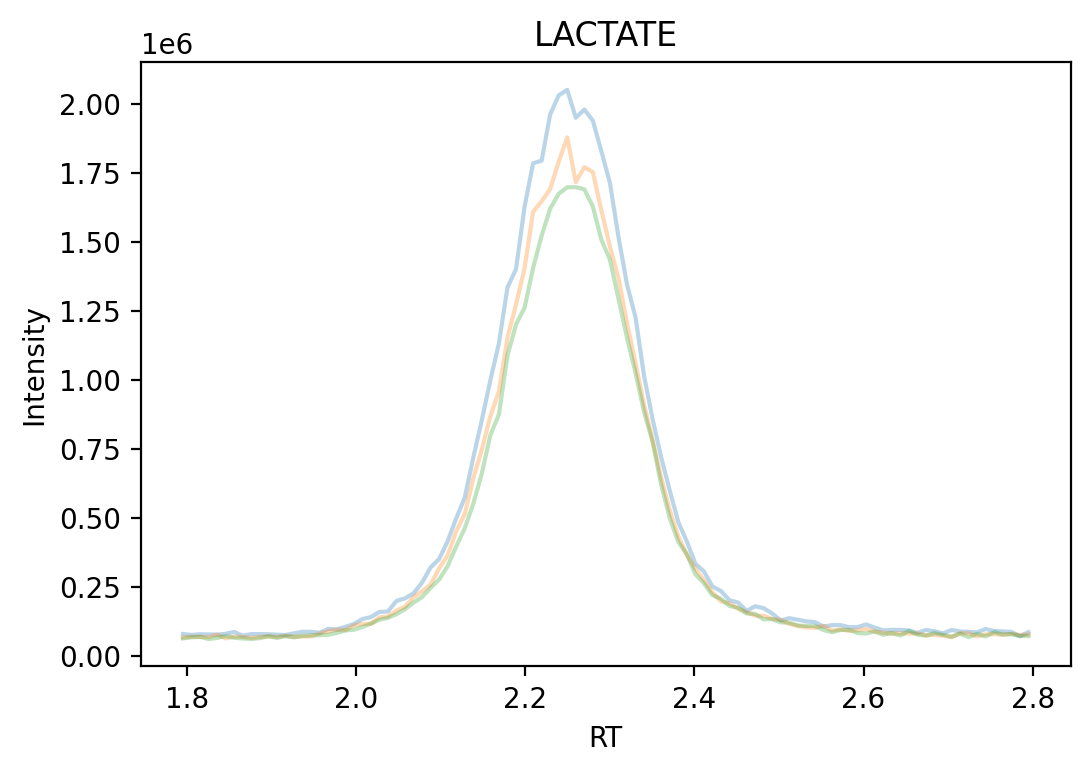

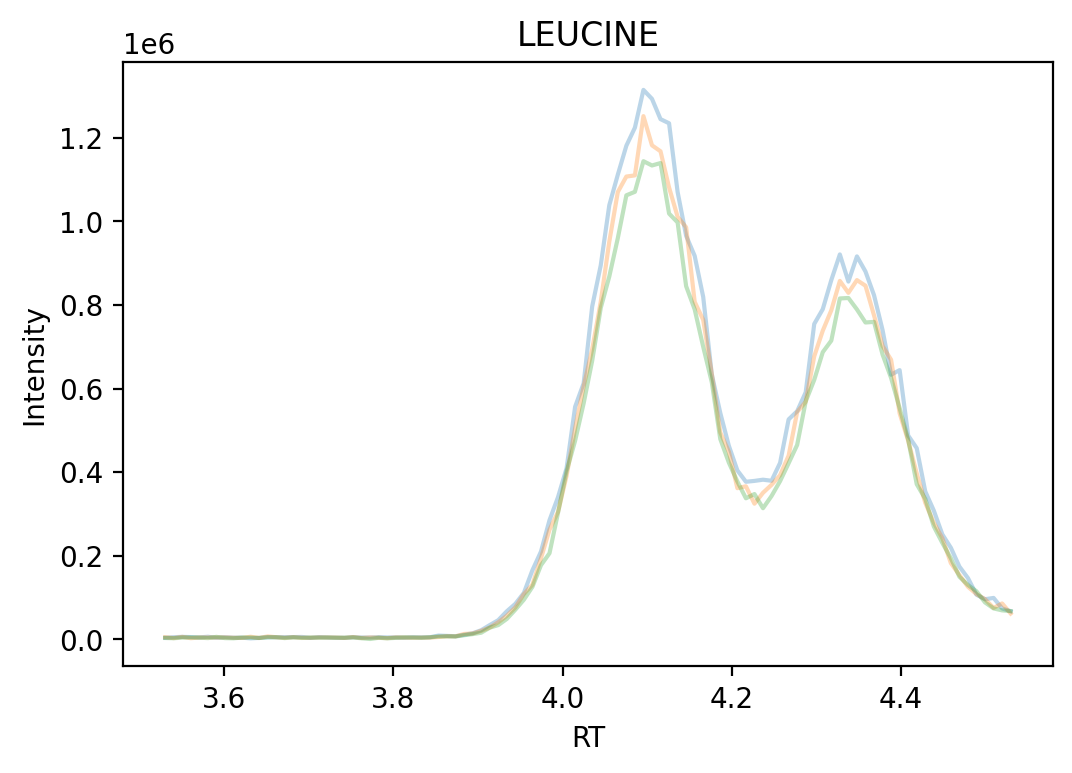

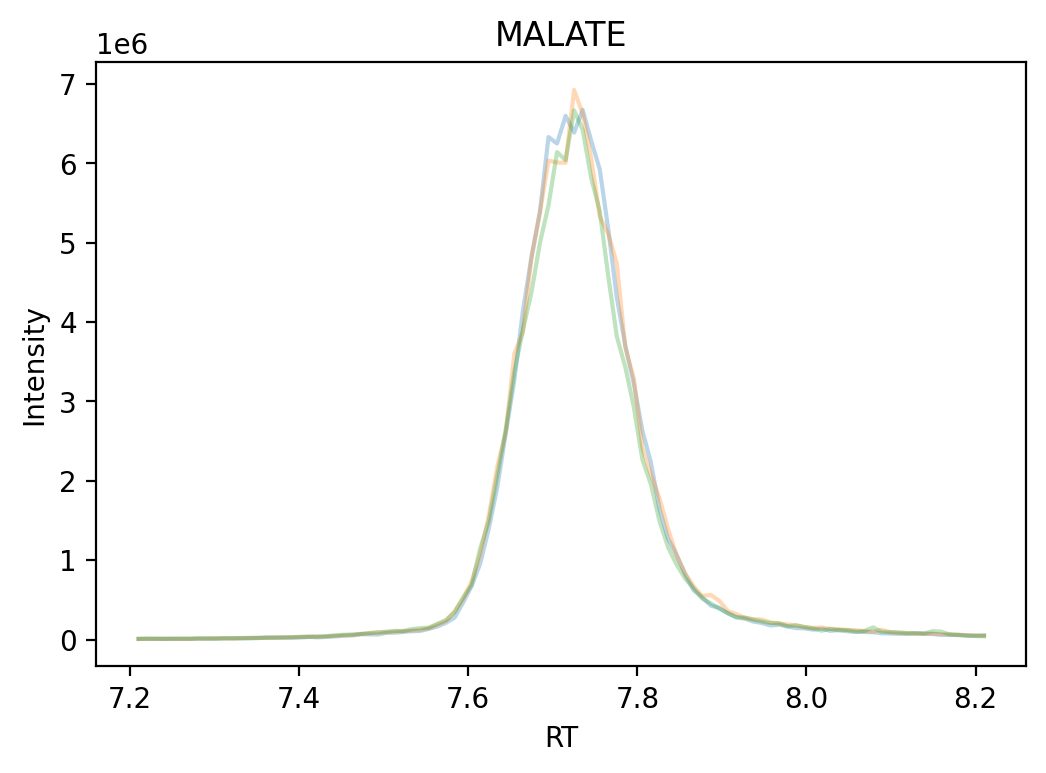

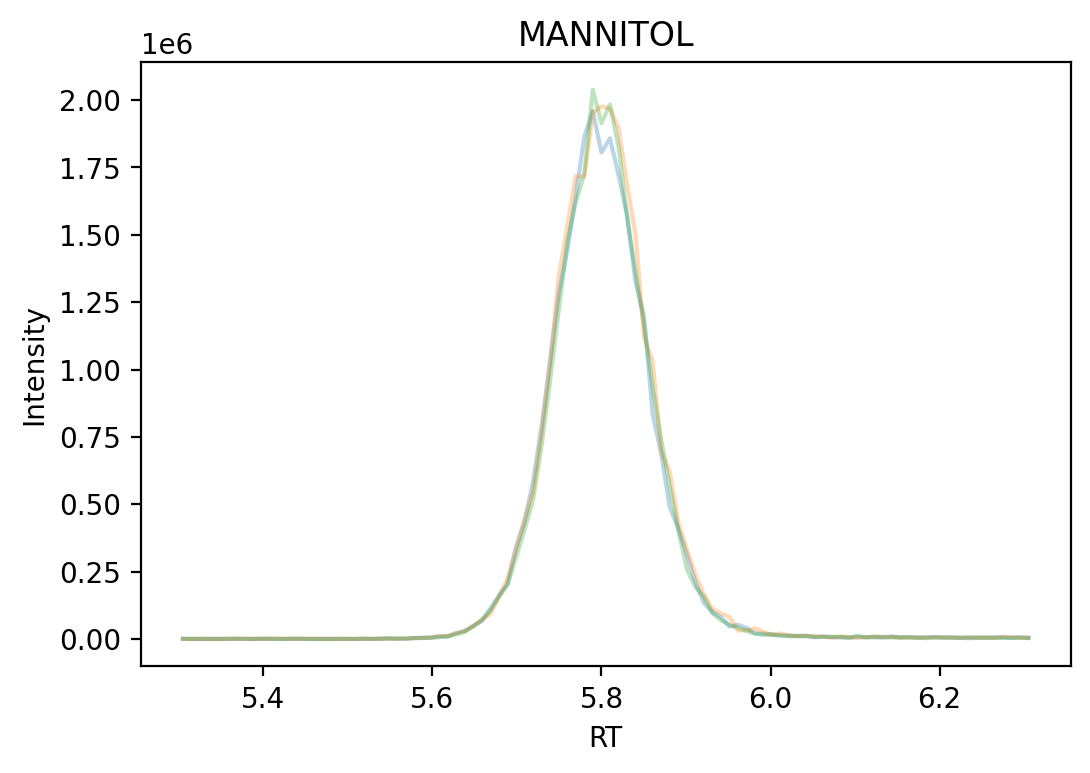

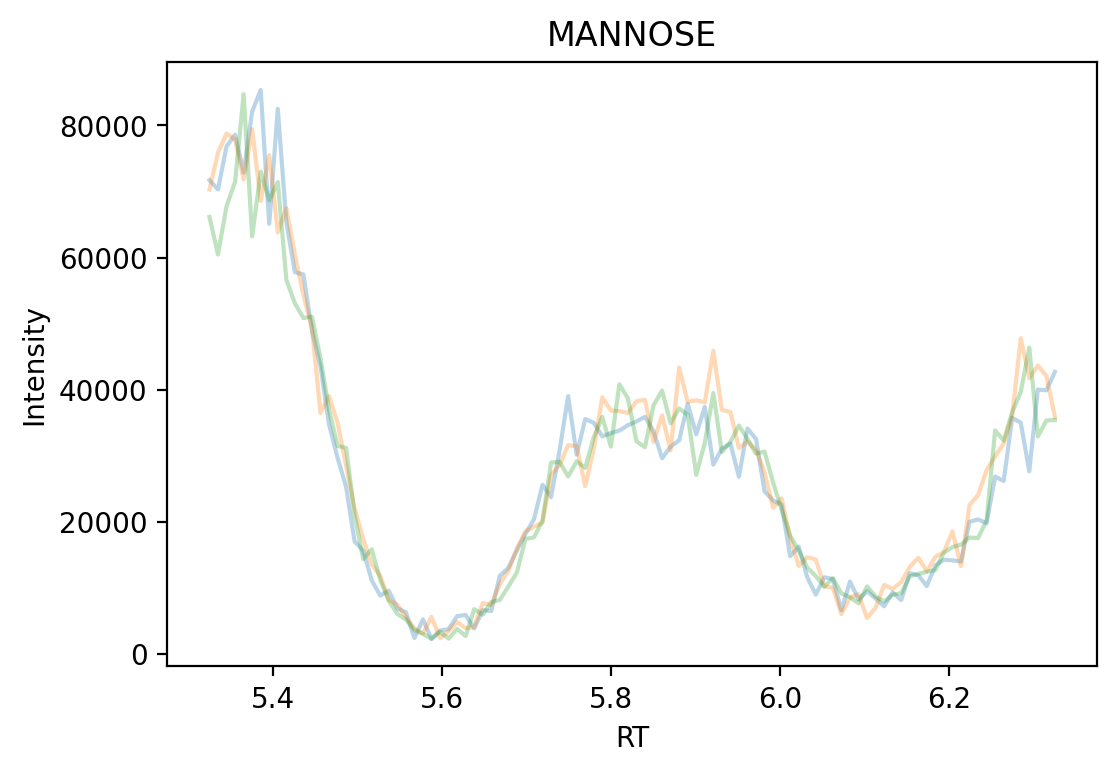

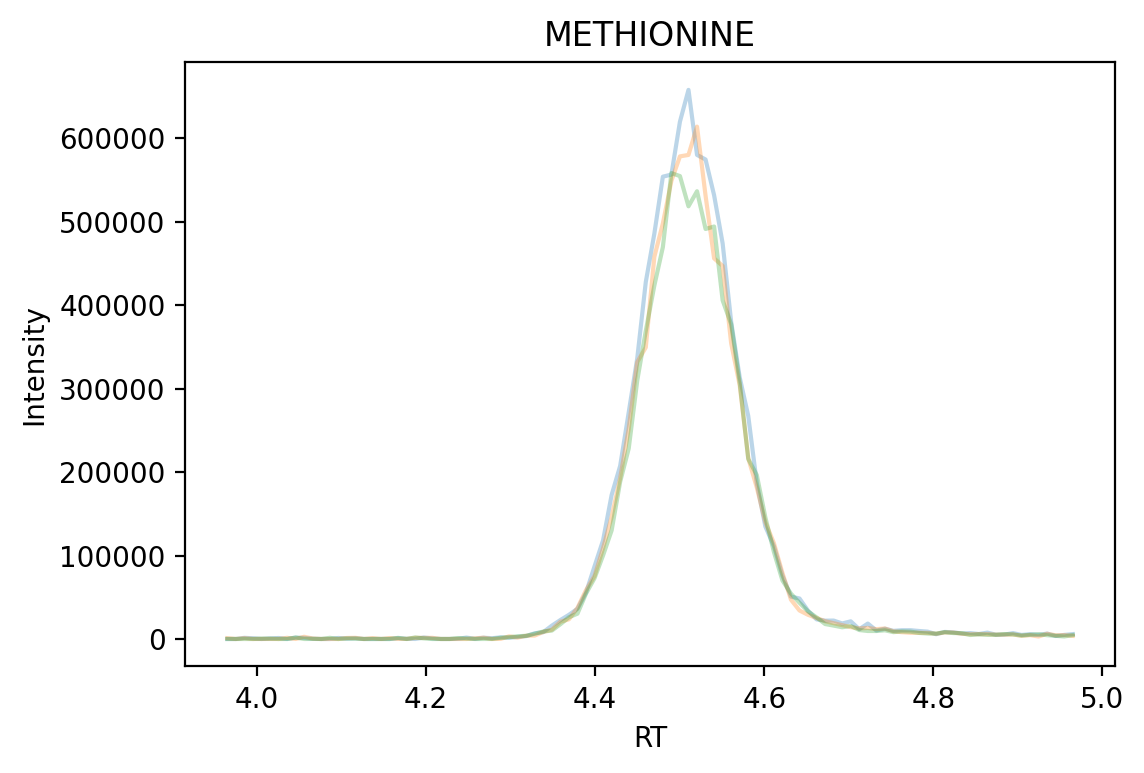

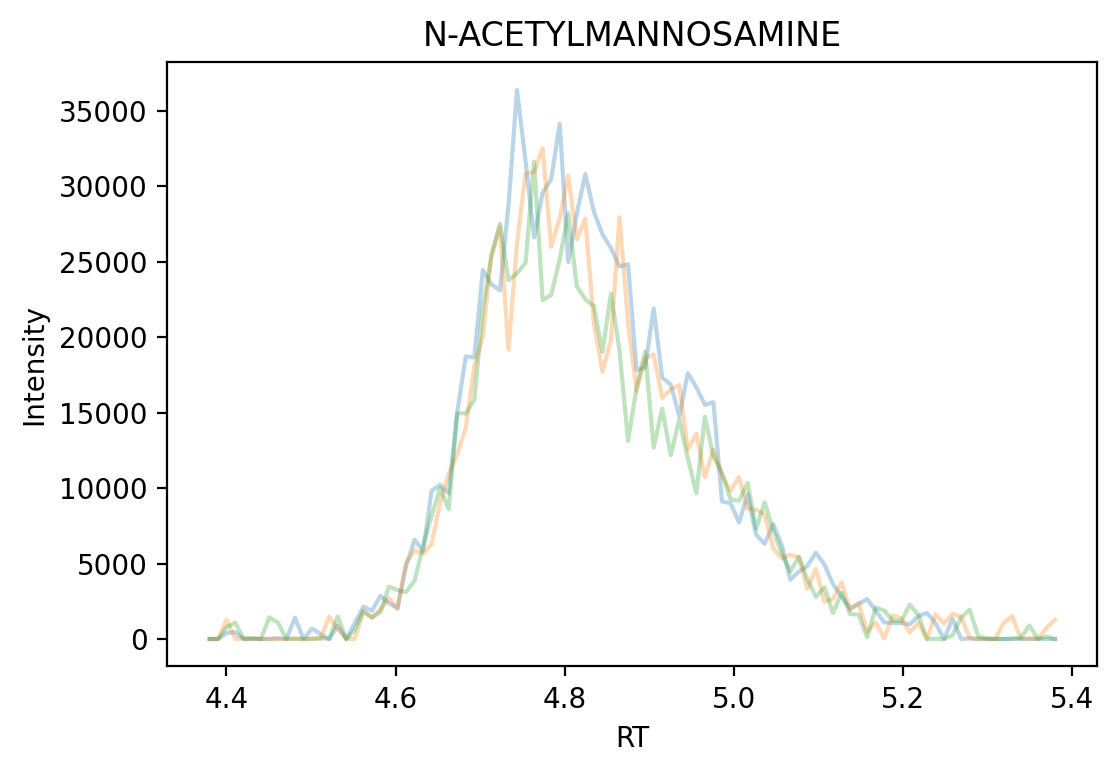

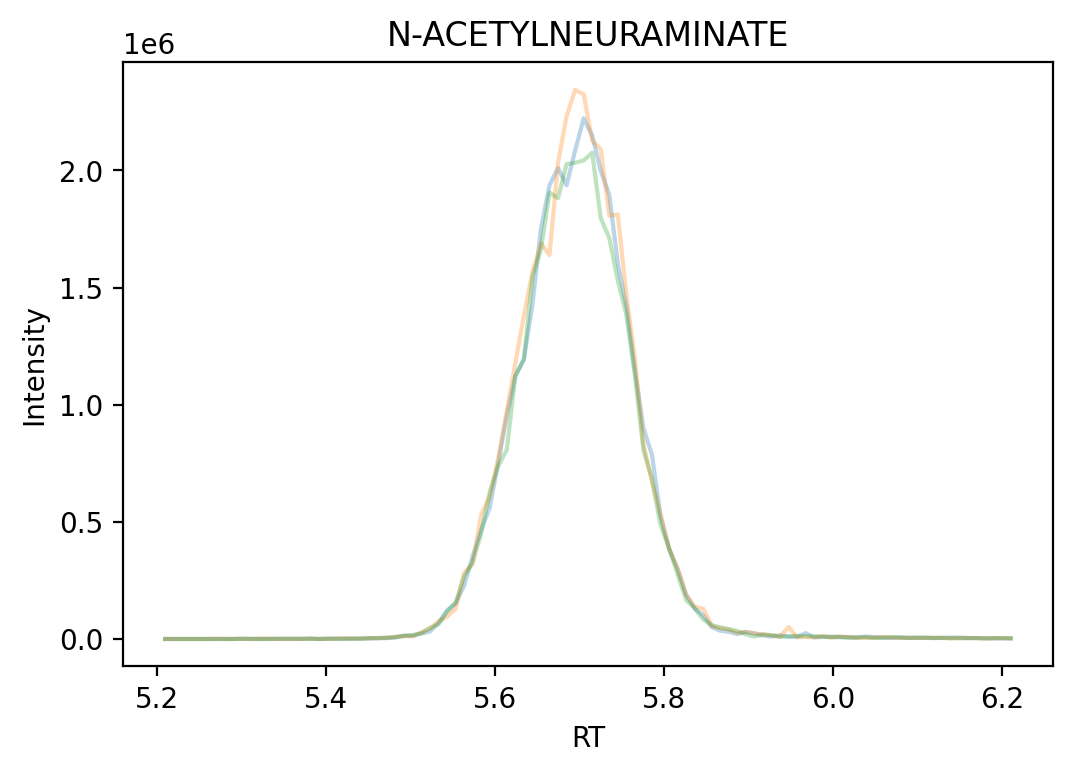

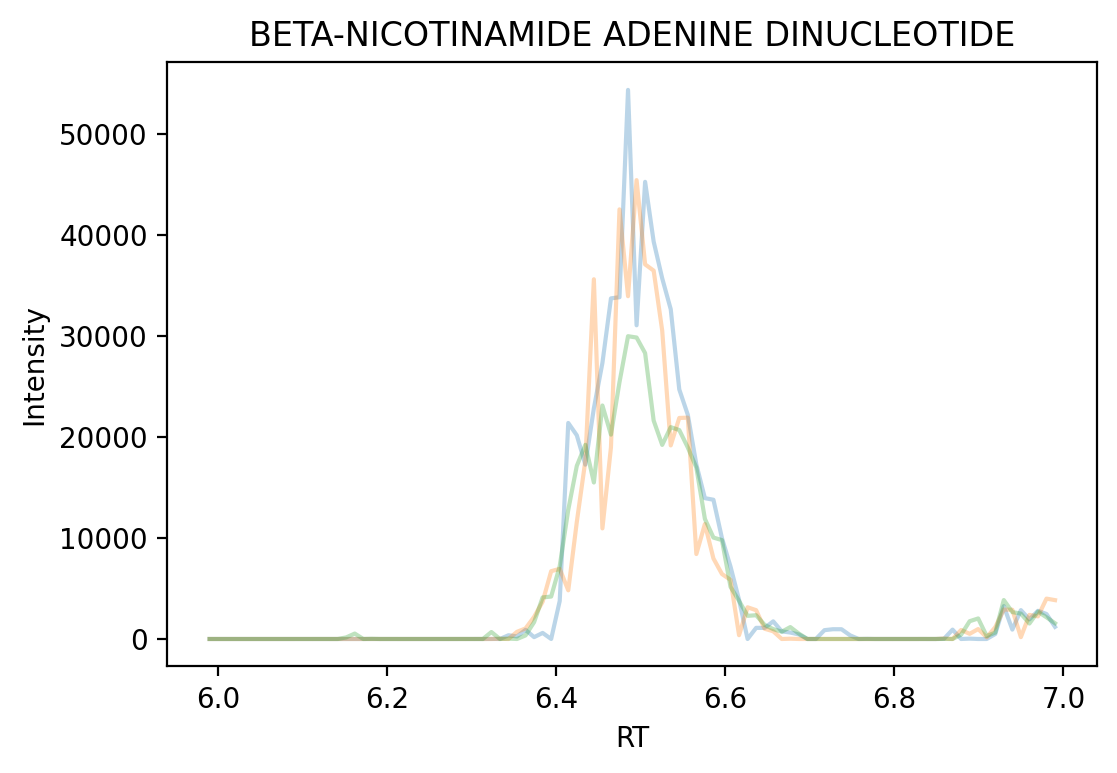

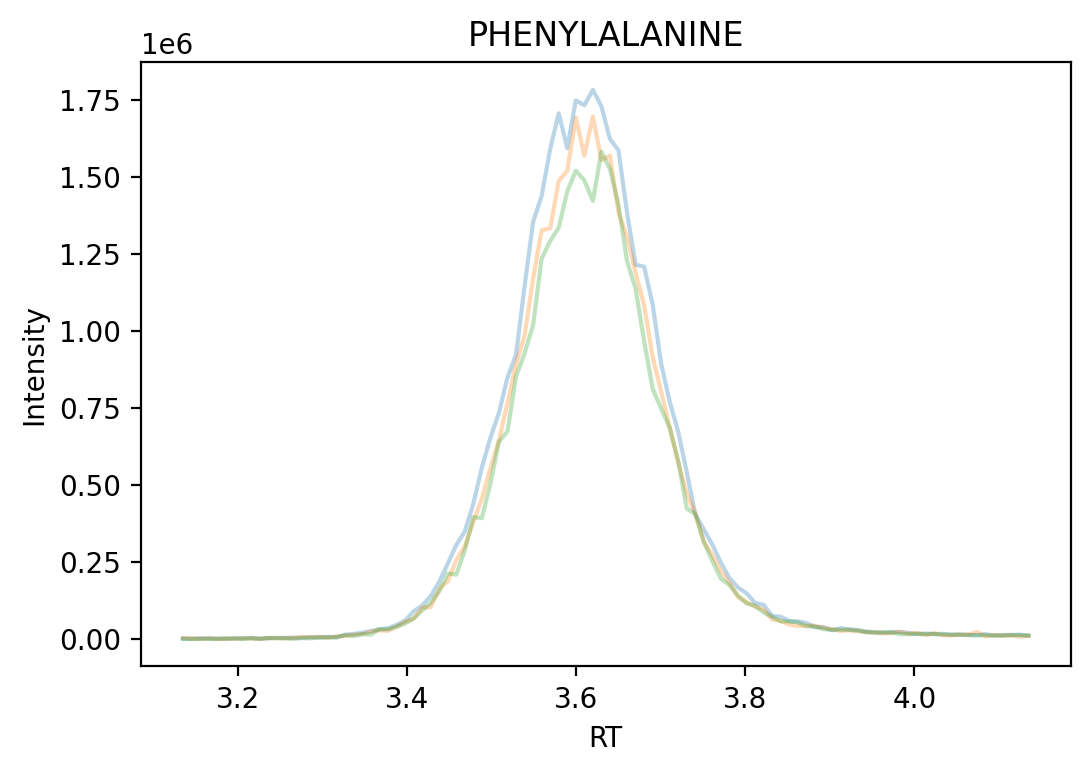

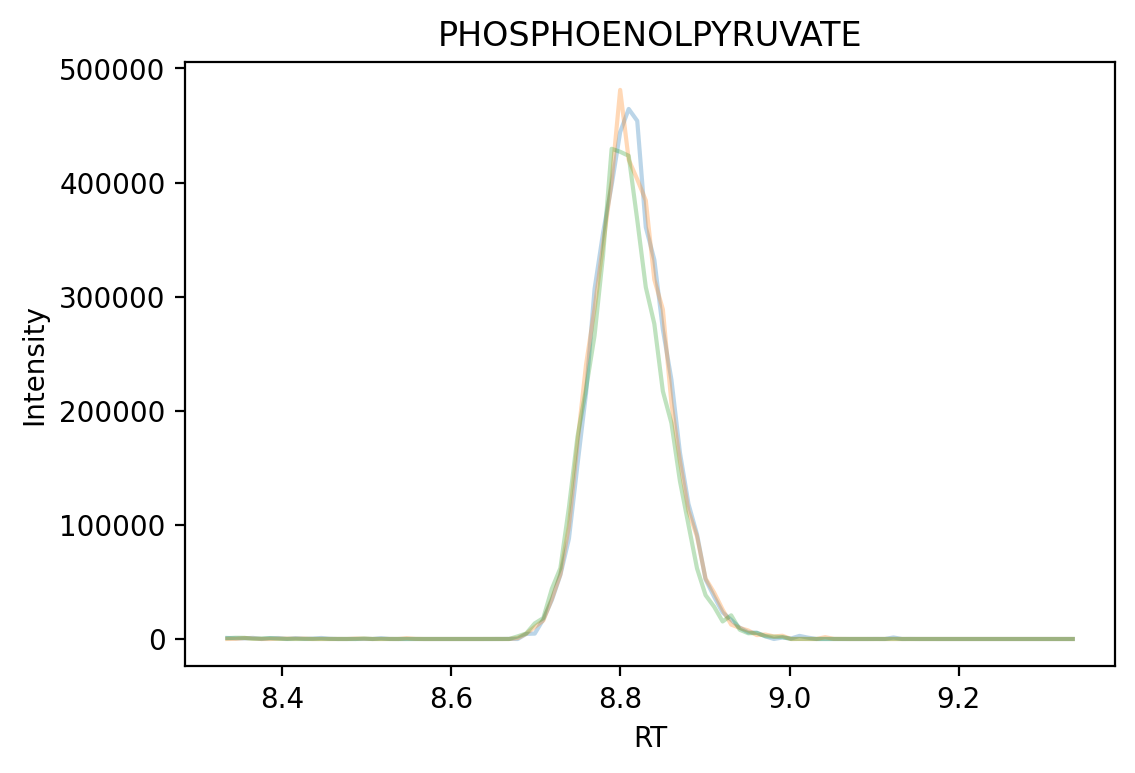

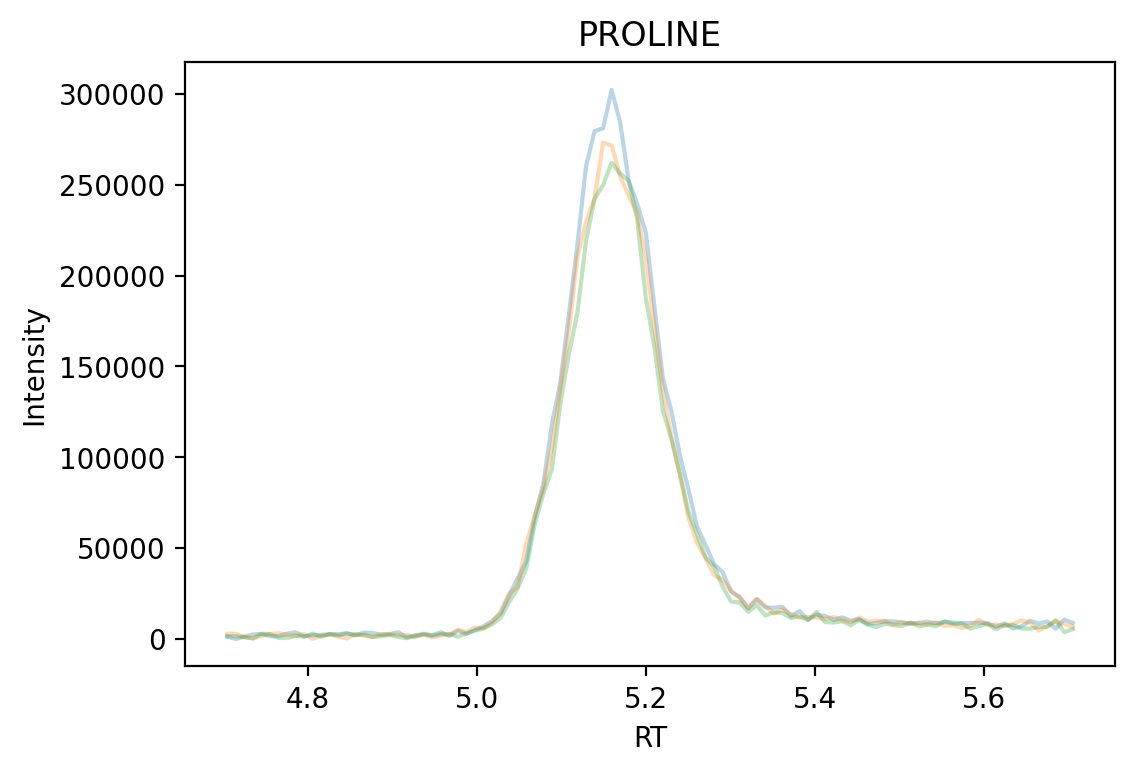

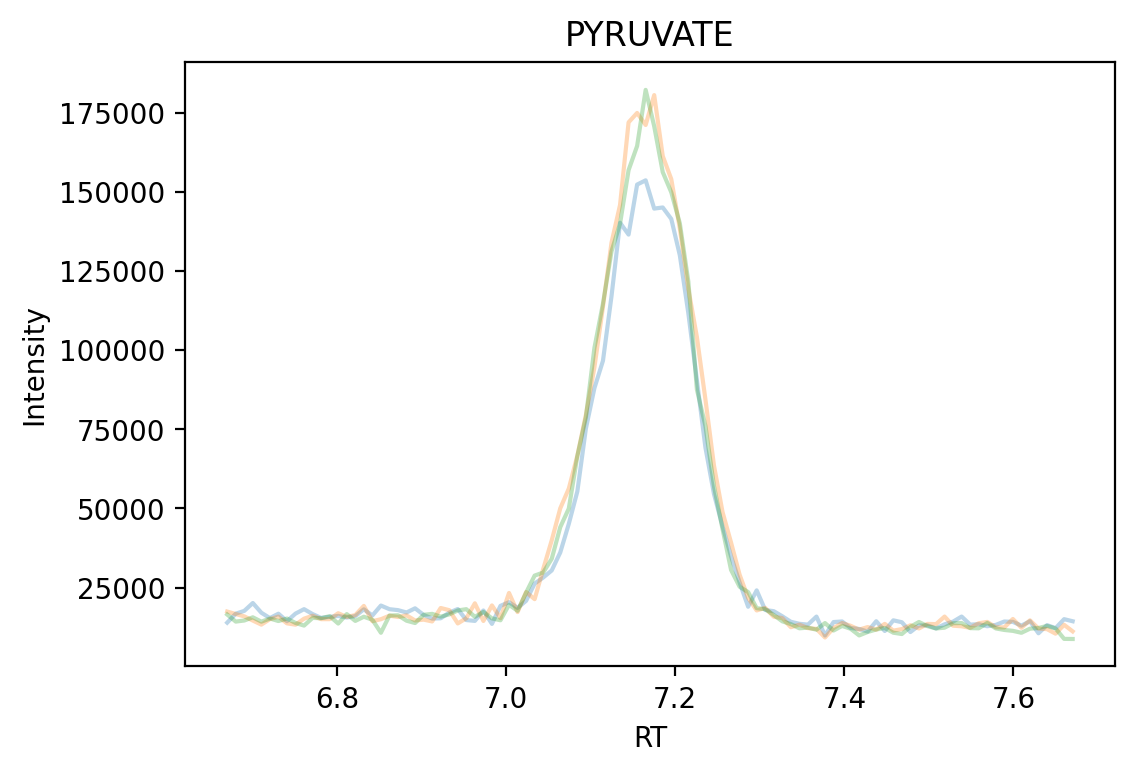

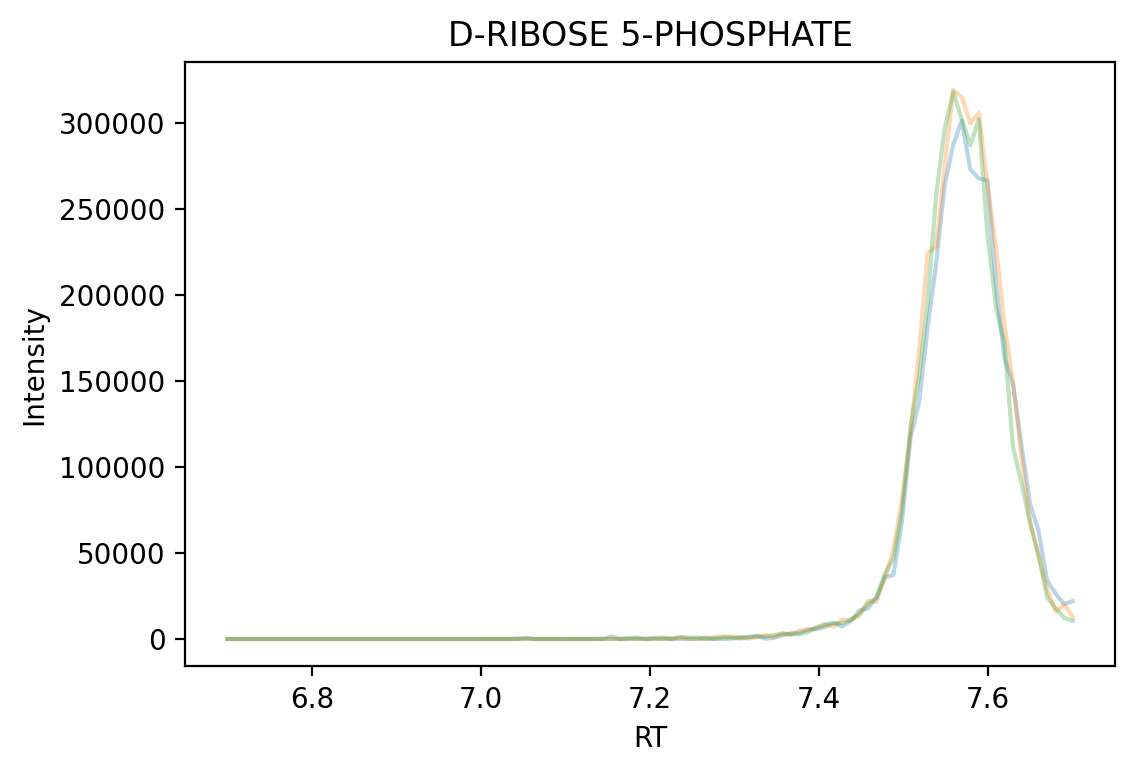

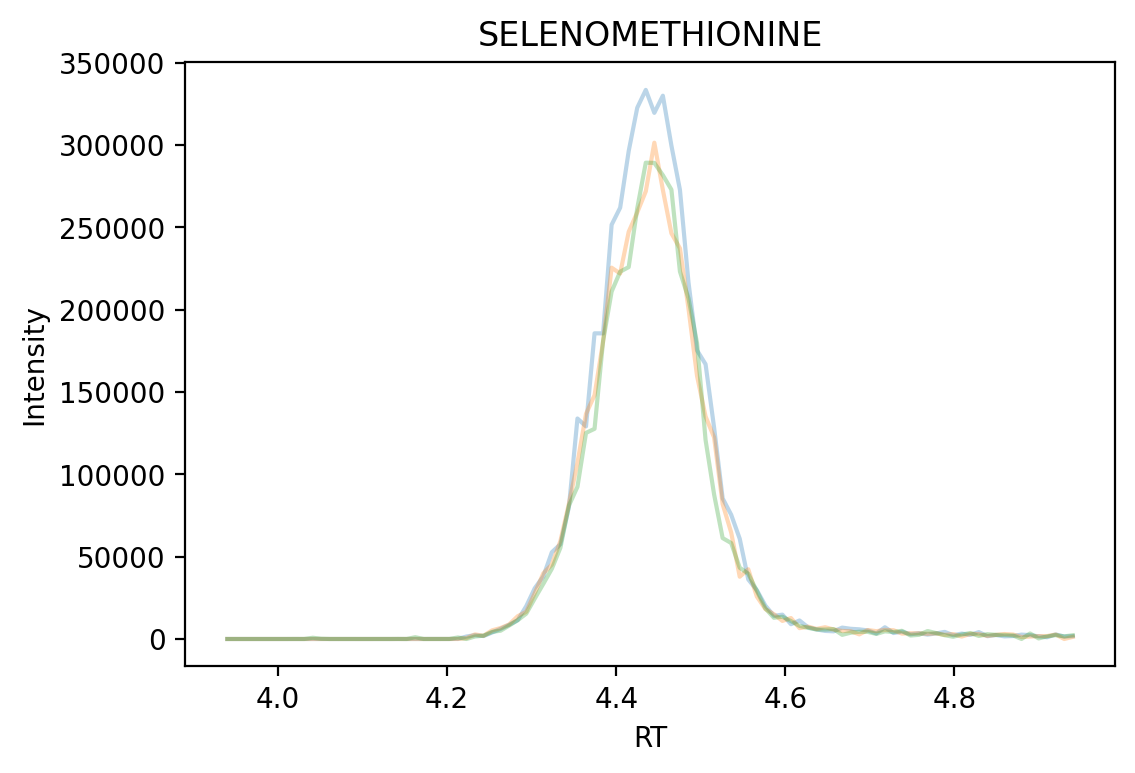

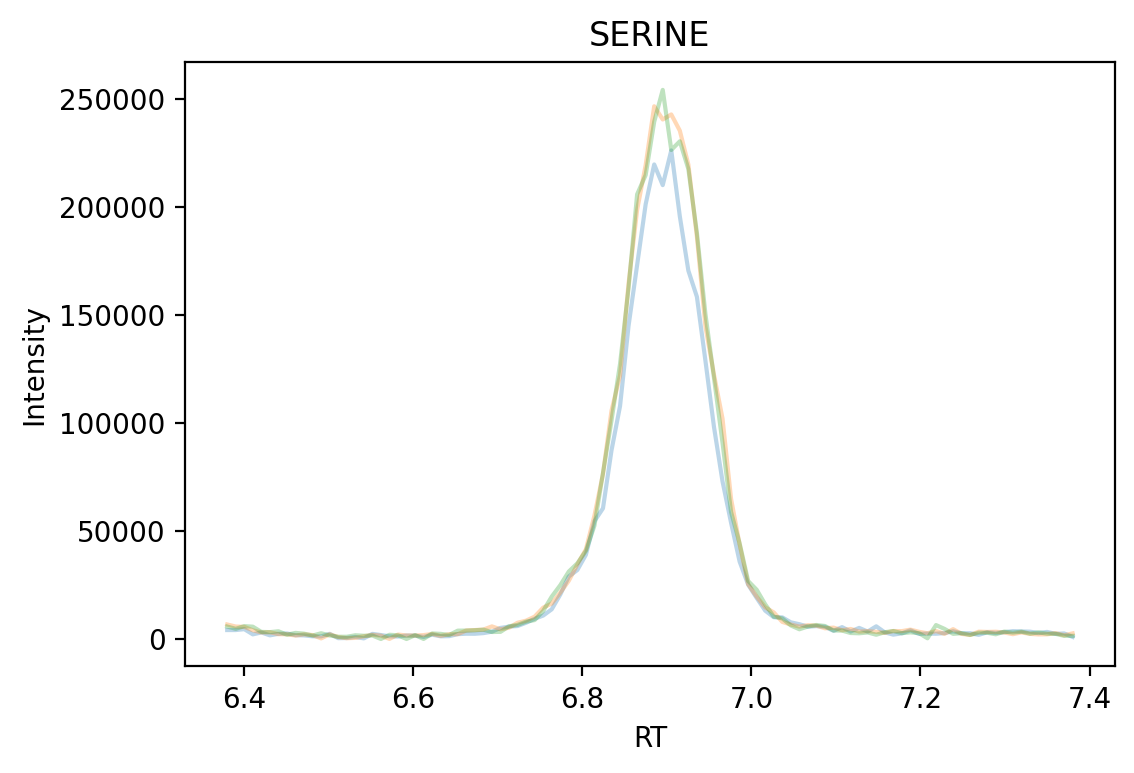

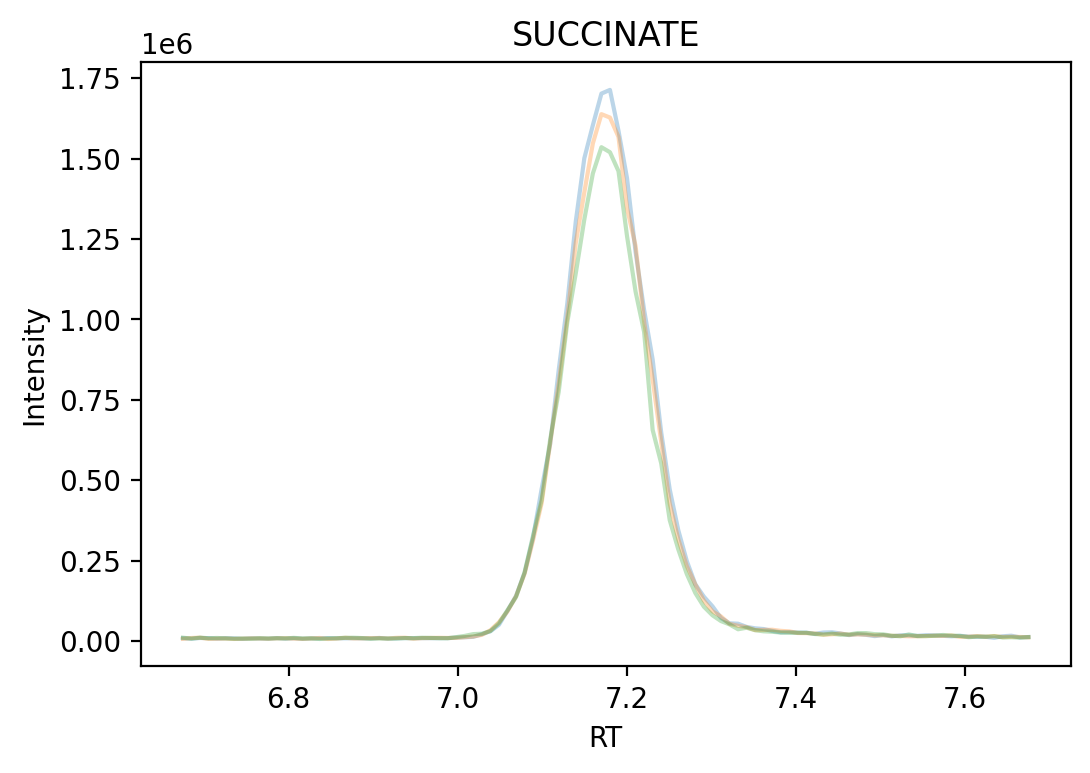

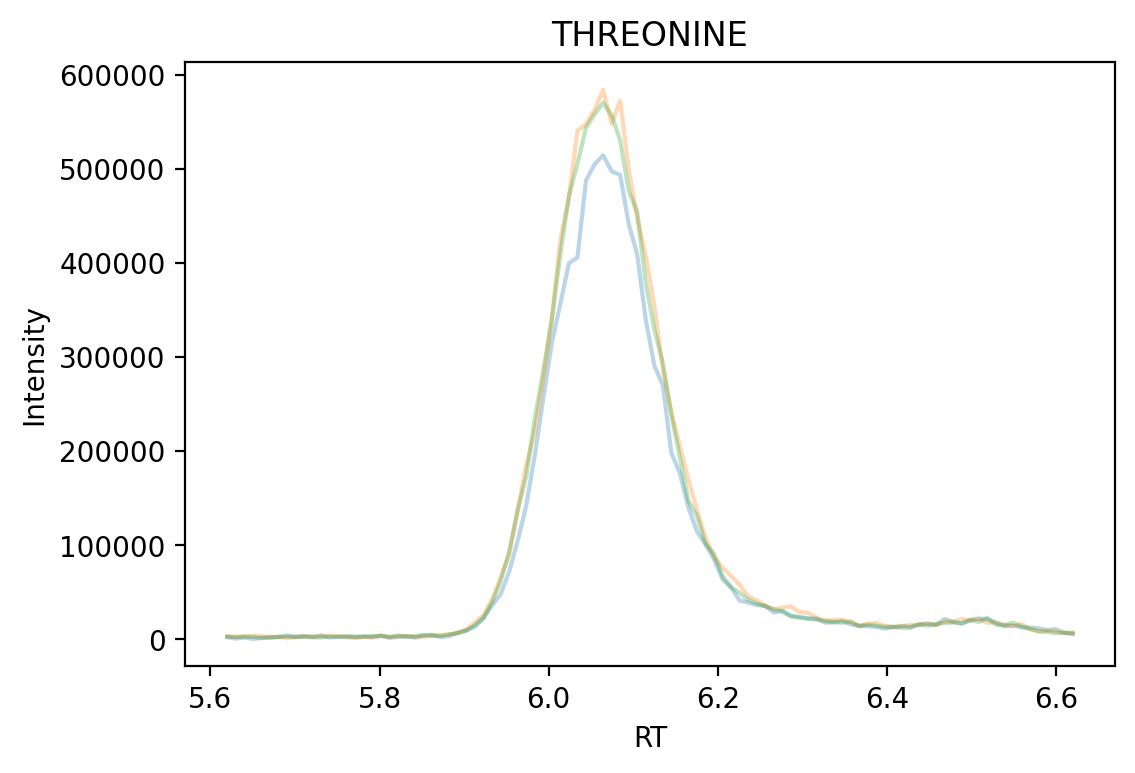

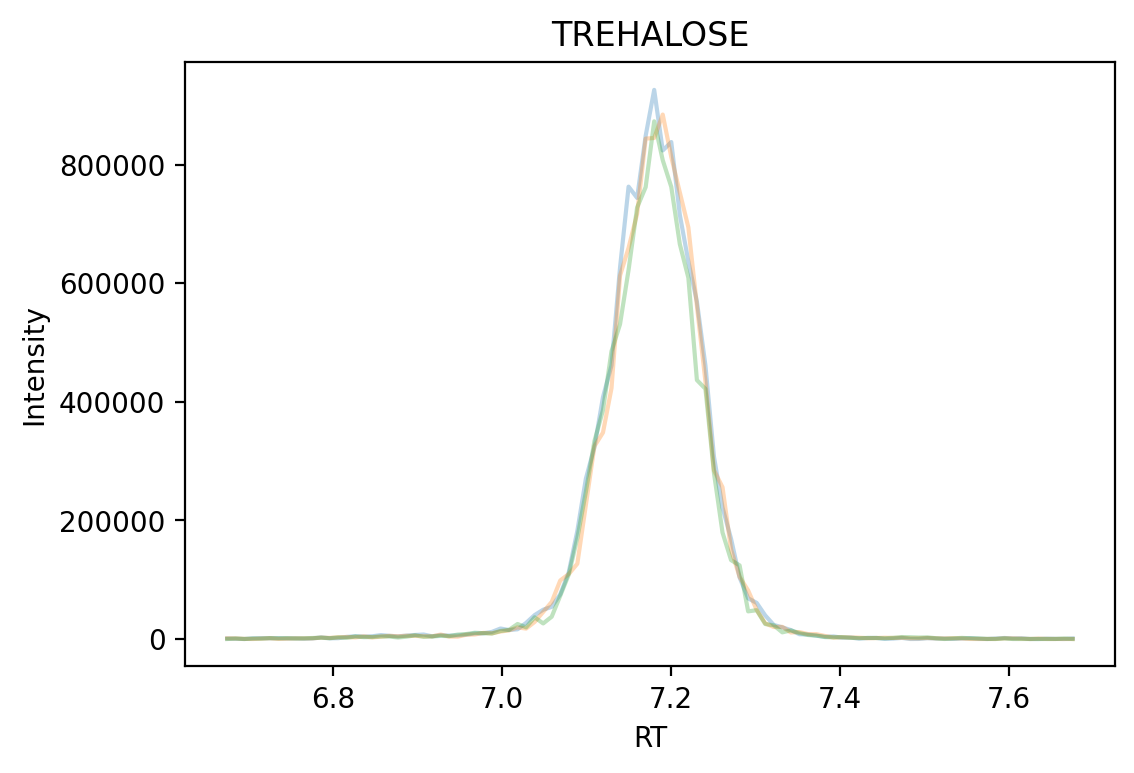

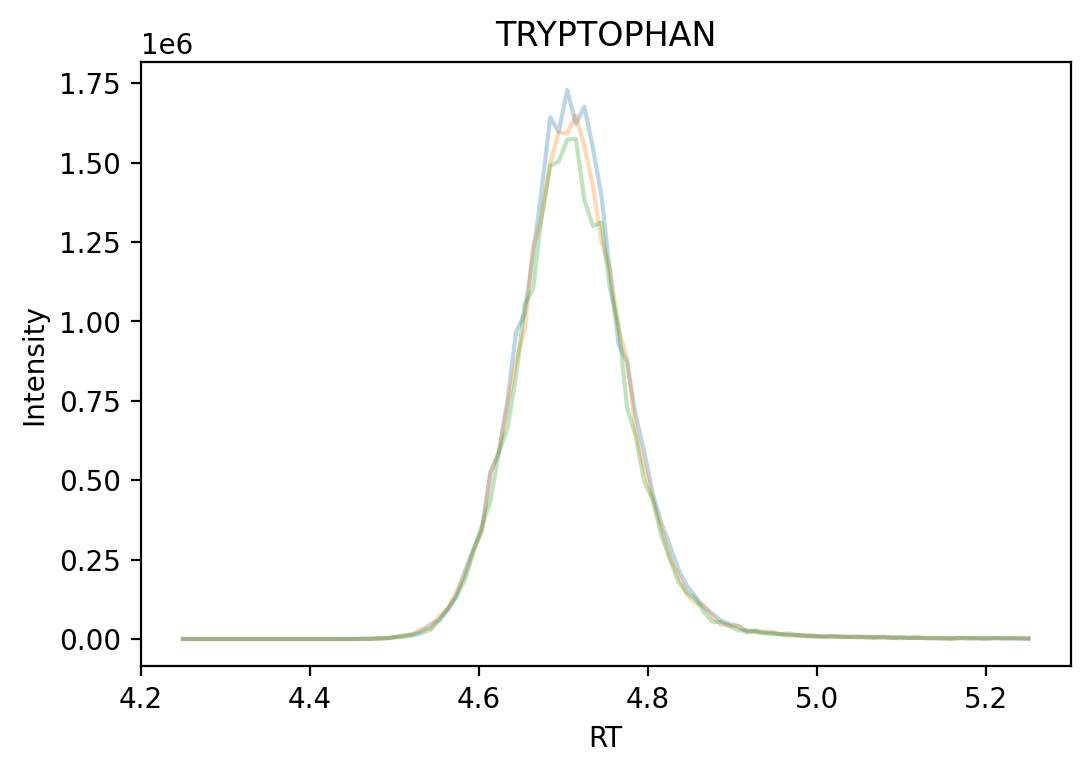

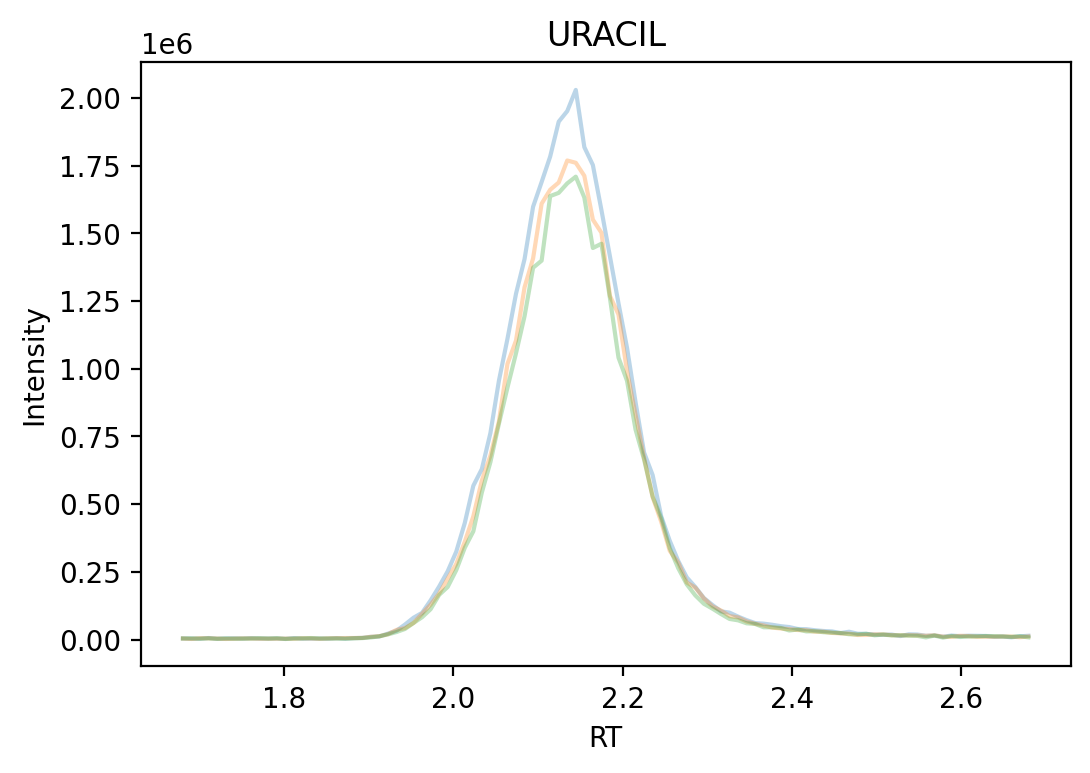

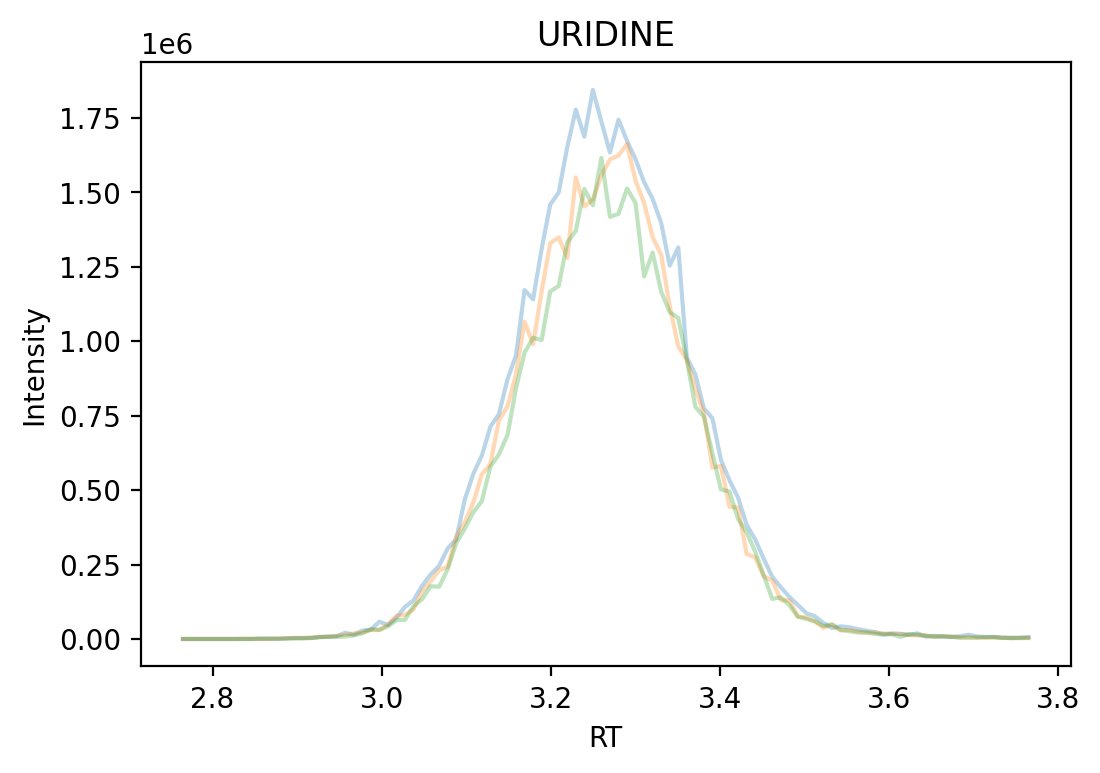

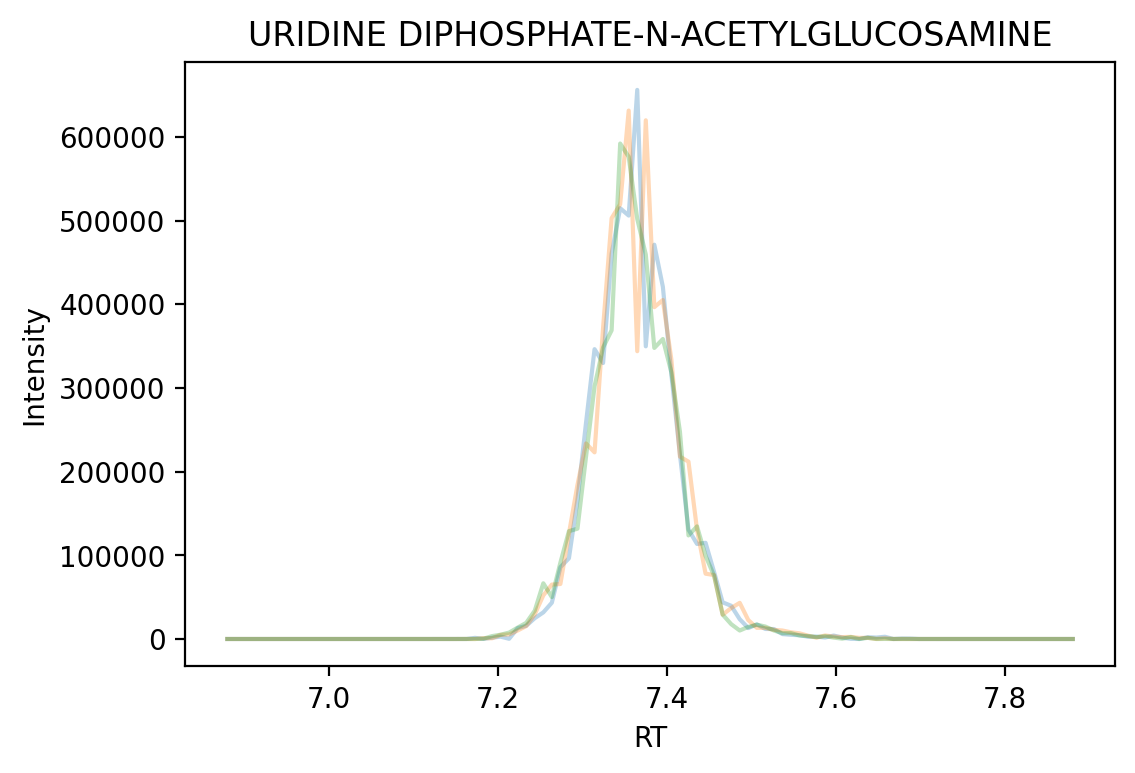

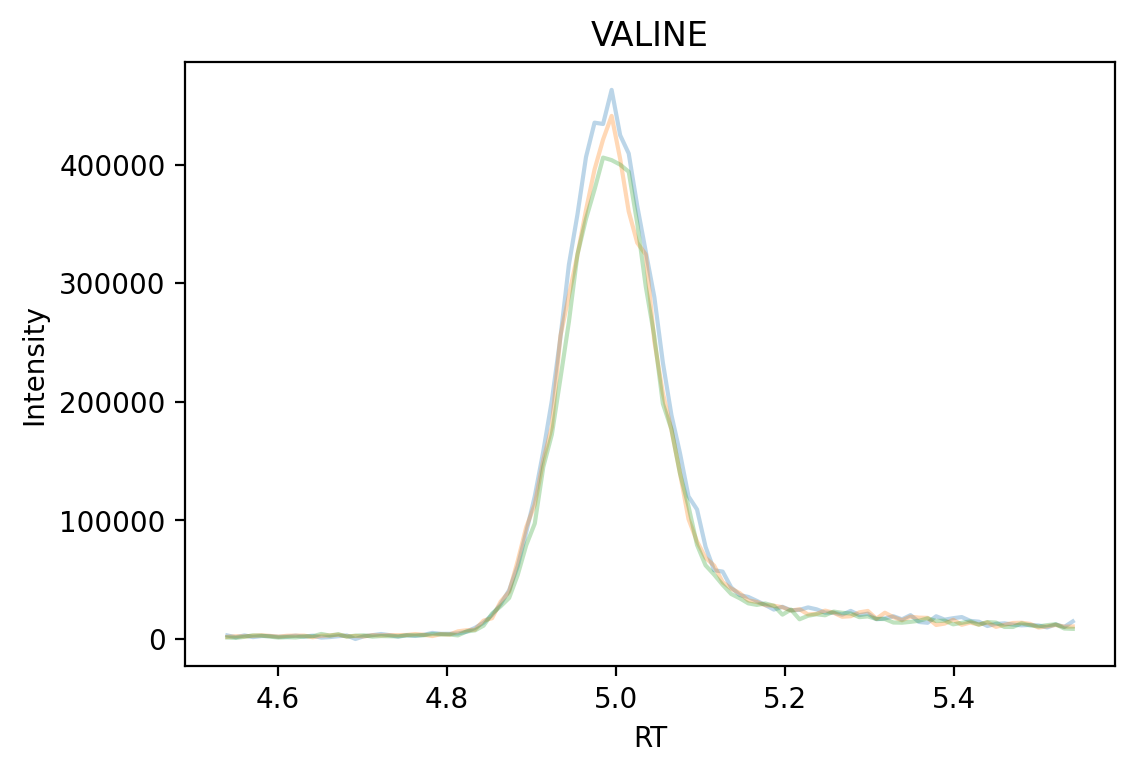

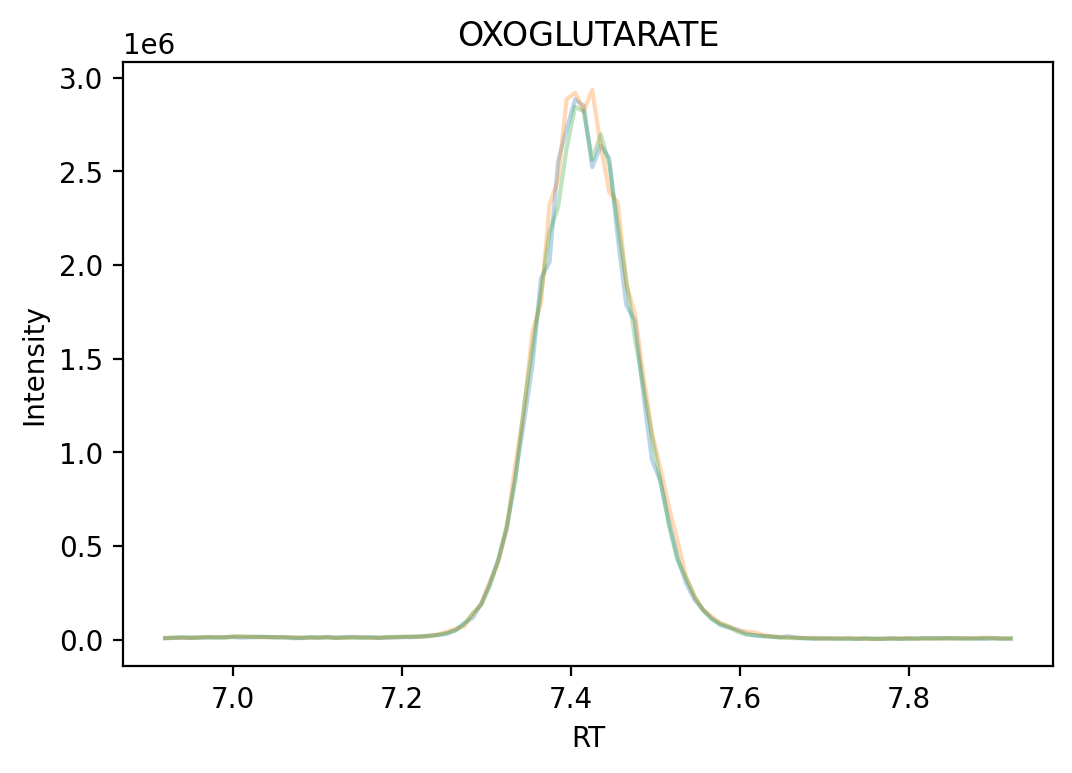

In [36]:
for mz,rt,name in real_peaks:
    if name in corClass["metabolite"].values:
        plt.figure()
        integ.plot_overlayedEIC([raw_data[file] for file in files],mz,rt-.5,rt + .5)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        plt.title(name)

Text(0, 0.5, '% of mixture metabolites ')

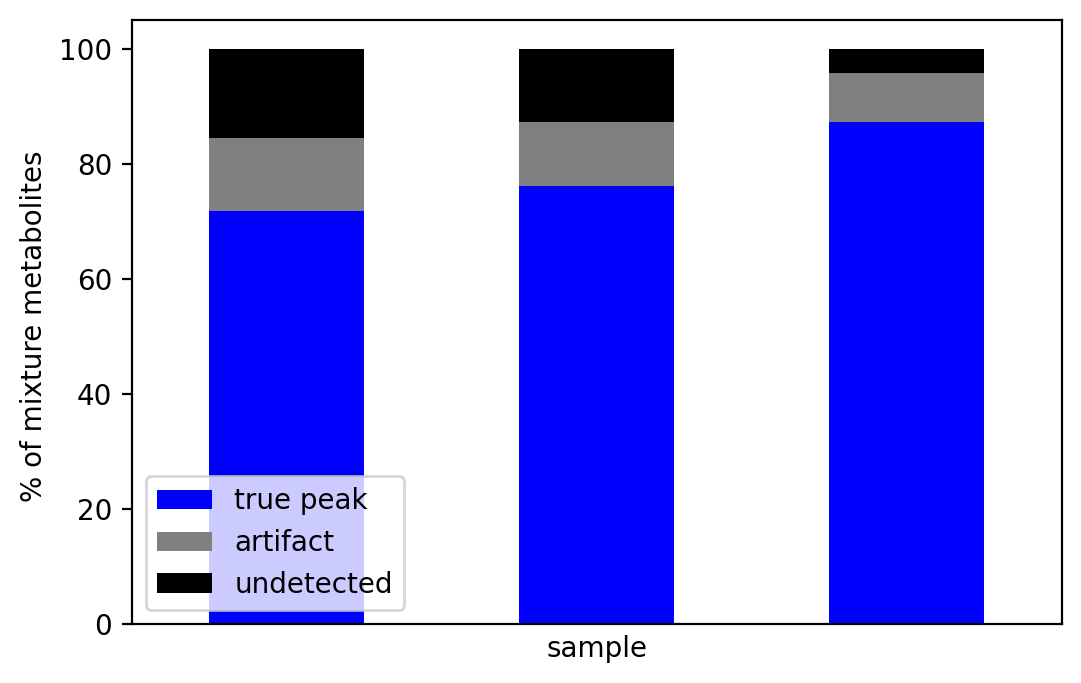

In [37]:
def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["blue","grey","black"])
plt.xticks([],[])
plt.ylabel("% of mixture metabolites ")
